### Git versioning

In [2]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : 443f5817a8c9c5daa0a75637f0d030edad51afb0 

Commit short SHA: 443f
Branch:  mensualisation_wip
Date (y/m/d): 2017-02-12 18:48:09  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : a6b02e6909ee9c27169cd5cf73c51df9b1640ef9  Date: 2016-05-31 15:54:47 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [3]:
%matplotlib inline
from __future__ import division

import calendar

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import AutoMinorLocator


import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


# Create Survey Scenario

In [4]:
period = periods.period(2009)

In [5]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [6]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(52189,) (42709,) (48195,) (80431,)


In [7]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [8]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [9]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [10]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [11]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [12]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [13]:
uc_famille.shape

(48195,)

In [14]:
weight_familles.shape

(48195,)

In [15]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0
période 2009-01
rsa_last_month 2.30956e+06
période 2009-02
rsa_last_month 2.50738e+06
période 2009-03
rsa_last_month 2.58349e+06
période 2009-04
rsa_last_month 2.84413e+06
période 2009-05
période 2009-01
rsa_last_month 2.87149e+06
période 2009-06
rsa_last_month 2.87782e+06
période 2009-07
rsa_last_month 2.91029e+06
période 2009-08
rsa_last_month 2.92267e+06
période 2009-09
rsa_last_month 2.96265e+06
période 2009-10
rsa_last_month 2.93266e+06
période 2009-11
rsa_last_month 2.95259e+06
période 2009-12


In [16]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([    0.       ,     0.       ,     0.       , ..., -1824.6550293,
           0.       ,     0.       ])

In [17]:
revdisp_negatif = (rev_disp_uc < 0)

In [18]:
pd.value_counts(revdisp_negatif)

False    42709
dtype: int64

In [19]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    80191
True       240
dtype: int64

In [20]:
simulation.persons.count

80431

In [21]:
hello = simulation.entity_by_key_singular["menage"]

In [22]:
simulation.holder_by_name[hello.index_for_person_variable_name].array

array([    0,     0,     0, ..., 22229, 39367,  5598], dtype=int32)

In [23]:
survey_scenario.compute_aggregate("irpp")/10**9

-67.713927343444126

## Share of more than 20% variation per decile

In [24]:
import pandas as pd


In [25]:
income_month_list = ["income_month_{}".format(month) for month in range(1,13)]

In [26]:
df = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df["income_month_{}".format(month)] = month_income

In [27]:
df["yearly_income"] = df[income_month_list].sum(1)
df["diff_rev"] = df[income_month_list].max(1) - df[income_month_list].min(1)
df["relative_var"] = (df[income_month_list].max(1) - df[income_month_list].min(1))/df[income_month_list].max(1)

In [28]:
has_rev_filter = df["yearly_income"]>1

In [29]:
print df["diff_rev"].mean()
print df["diff_rev"][has_rev_filter].mean()

315.795882838
392.298808459


In [30]:
df[has_rev_filter & (df.diff_rev <2000)].shape[0]/df[has_rev_filter].shape[0]

0.9564760757421308

In [31]:
%%time
range_to_use = range(1,7000,20)
income_rep_func =[df[has_rev_filter & (df.diff_rev<income)].shape[0]/df[has_rev_filter].shape[0] for income in range_to_use]

CPU times: user 3.23 s, sys: 1.18 s, total: 4.41 s
Wall time: 5.04 s


In [32]:
income_rep_func

[0.8603774750563742,
 0.8614586229265129,
 0.862292651283477,
 0.8633583541840423,
 0.8644858369629012,
 0.8652735304111451,
 0.8663701232508572,
 0.8675902758471565,
 0.8686096438390016,
 0.869567231952553,
 0.8705711549748247,
 0.8716831927841102,
 0.872918790349983,
 0.8742933926420164,
 0.8755135452383159,
 0.8767800327433355,
 0.8779229604917679,
 0.8792357829055076,
 0.8805022704105273,
 0.8818305377938406,
 0.88305069039014,
 0.8841009483211318,
 0.8850430914651098,
 0.8864331387267167,
 0.8873135019924011,
 0.8885954344669941,
 0.8897846971241467,
 0.8907268402681247,
 0.8921168875297316,
 0.8933061501868841,
 0.8942482933308621,
 0.895715565440336,
 0.897105612701943,
 0.8984338800852563,
 0.8996231427424088,
 0.9010131900040157,
 0.9022333426003151,
 0.9032990455008804,
 0.9043184134927255,
 0.9053532264541438,
 0.9066969388070305,
 0.9078089766163161,
 0.9088437895777345,
 0.9101102770827542,
 0.9111759799833195,
 0.9122725728230315,
 0.9133537206931702,
 0.914512093411176,


In [33]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_m["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'menage')
    
df_m["yearly_income"] = df_m[income_month_list].sum(1)
df_m["diff_rev"] = df_m[income_month_list].max(1) - df_m[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)

has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

In [34]:
df_f = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_f["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'foyer_fiscal')
    
df_f["yearly_income"] = df_f[income_month_list].sum(1)
df_f["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_f["relative_var"] = (df_f[income_month_list].max(1) - df_f[income_month_list].min(1))/df_f[income_month_list].max(1)


has_rev_filter_f = df_f["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_f =[df_f[has_rev_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_filter_f].shape[0] for income in range_to_use]

In [35]:
df_f.shape

(52189, 15)

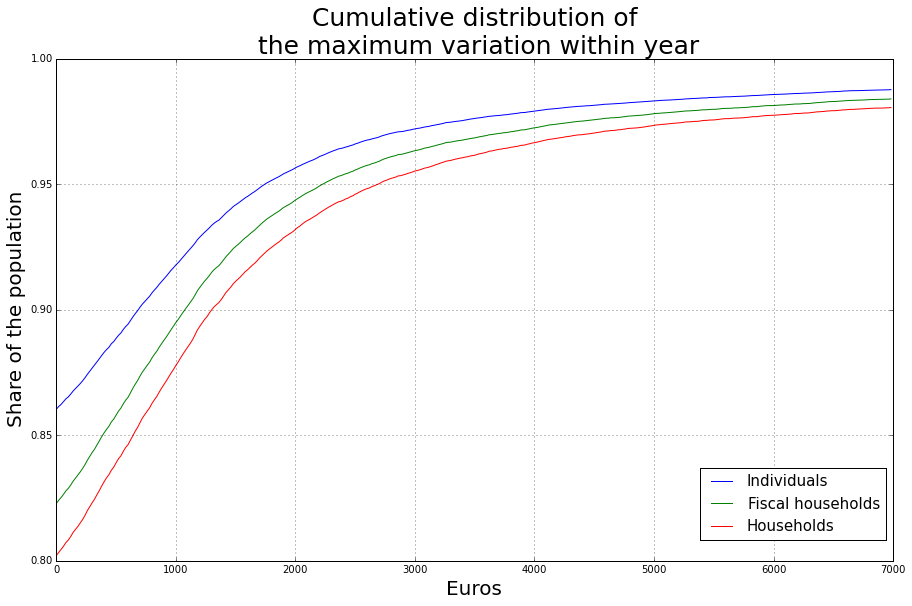

In [36]:

plt.figure(figsize=(15,9))
plt.plot(range_to_use,income_rep_func,label = 'Individuals')
plt.plot(range_to_use,income_rep_func_f,label = 'Fiscal households')
plt.plot(range_to_use,income_rep_func_m,label = 'Households')


plt.ylabel("Share of the population", fontsize=20 )
plt.xlabel("Euros", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year', fontsize = 25)

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
plt.figure(figsize = (10,20))

### Cumulative only for those with a unique income for each month (with no null income)

In [37]:
revenu_diff_0_per_month = np.zeros(weight_individus.shape)
for var in ['salaire_imposable', 'chomage_imposable', 'retraite_imposable']:
    for month in range(1,13):
        revenu_diff_0_per_month += pd.Series(simulation.calculate('{}'.format(var), '2009-{}'.format(month))) != 0 

In [38]:
unique_income = (revenu_diff_0_per_month == 12)

In [39]:
filter_rev_but_not_unique = (pd.Series(has_rev_filter) & (~ pd.Series(unique_income)))

In [40]:
un_seul_revenu_m = sum_array_by_entity(month_income, 'menage')

In [41]:
has_rev_unic_each_month_filter = (df["yearly_income"]>1) & unique_income
has_rev_unic_each_month_filter_m = sum_array_by_entity(filter_rev_but_not_unique, 'menage')
has_rev_unic_each_month_filter_m = ~ has_rev_unic_each_month_filter_m.astype('bool')

In [42]:
has_rev_unic_each_month_filter_f = sum_array_by_entity(filter_rev_but_not_unique, 'foyer_fiscal')
has_rev_unic_each_month_filter_f = ~ has_rev_unic_each_month_filter_f.astype('bool')

In [43]:
%%time
range_to_use = range(1,7000,20)
income_rep_func_unique_m =[df_m[has_rev_unic_each_month_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_unic_each_month_filter_m].shape[0] for income in range_to_use]


CPU times: user 1.46 s, sys: 25 ms, total: 1.48 s
Wall time: 1.51 s


In [44]:

range_to_use = range(1,7000,20)
income_rep_func_unique_f =[df_f[has_rev_unic_each_month_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_unic_each_month_filter_f].shape[0] 
                           for income in range_to_use]


In [45]:
%%time
range_to_use = range(1,7000,20)
income_rep_func_unique =[df[has_rev_unic_each_month_filter & (df.diff_rev<income)].shape[0]/df[has_rev_unic_each_month_filter].shape[0]
                         for income in range_to_use]


CPU times: user 2.92 s, sys: 1.04 s, total: 3.96 s
Wall time: 4.09 s


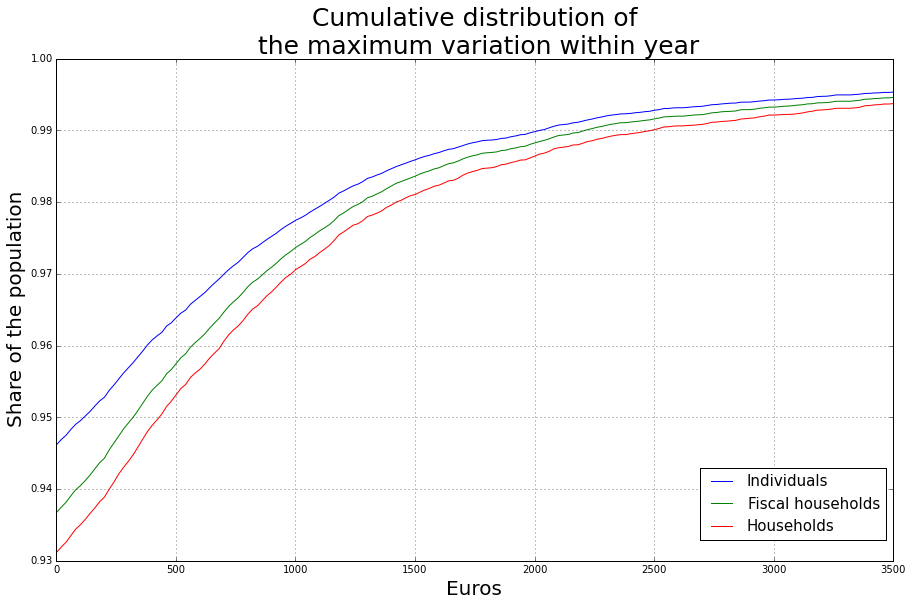

In [46]:

plt.figure(figsize=(15,9))
plt.plot(range_to_use,income_rep_func_unique,label = 'Individuals')
plt.plot(range_to_use,income_rep_func_unique_f,label = 'Fiscal households')
plt.plot(range_to_use,income_rep_func_unique_m,label = 'Households')


plt.ylabel("Share of the population", fontsize=20 )
plt.xlabel("Euros", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year', fontsize = 25)
plt.xlim((0,3500))

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
plt.figure(figsize = (10,20))


In [47]:
unique_income_with_rev = has_rev_filter & unique_income

In [48]:
pd.Series(has_rev_filter).value_counts()

True     64746
False    15685
dtype: int64

In [49]:
has_rev_filter.shape

(80431,)

In [50]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.calculate("revdisp_mensuel_annuel","2009-01").shape[0])
    month_income += simulation.calculate("revdisp_mensuel_annuel","2009-{}".format(month))
    df_m["income_month_{}".format(month)] = month_income
    
df_m["yearly_income"] = df_f[income_month_list].sum(1)
df_m["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)


has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

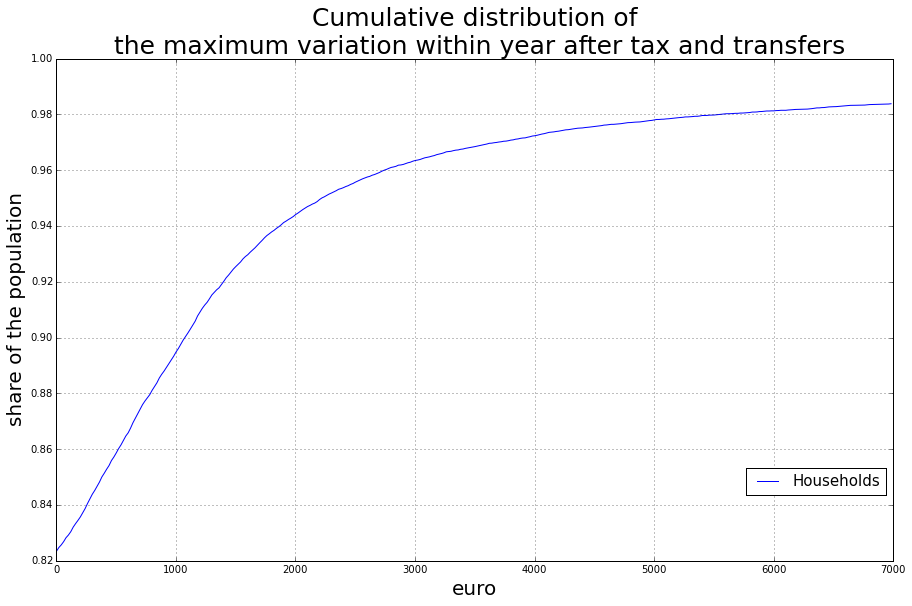

In [51]:

plt.figure(figsize=(15,9))

plt.plot(range_to_use,income_rep_func_m,label = 'Households')


plt.ylabel("share of the population", fontsize=20 )
plt.xlabel("euro", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year after tax and transfers', fontsize = 25)

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
#plt.xlim(0,1000)
plt.figure(figsize = (10,20))


In [52]:
print (pd.Series(simulation.calculate('salaire_imposable'))[(df["diff_rev"]>1000)]>0).value_counts()
print (pd.Series(simulation.calculate('retraite_imposable'))[(df["diff_rev"]>1000)]>0).value_counts()
print (pd.Series(simulation.calculate('chomage_imposable'))[(df["diff_rev"]>1000)]>0).value_counts()

True     3360
False    1963
dtype: int64
False    3090
True     2233
dtype: int64
False    3578
True     1745
dtype: int64


In [53]:
pd.Series(simulation.calculate('retraite_imposable')).value_counts()

0.000000        55394
6064.000488        36
8818.000977        30
6064.999512        27
3143.000244        24
11955.000000       16
10282.000000       12
8608.000977        11
23809.001953       11
10998.999023       11
8847.000000        11
8821.000977        10
6060.000000         9
4050.000000         9
3309.000000         9
10183.000000        9
23496.000000        8
11238.000000        8
3183.000000         8
22375.001953        8
20989.000000        8
9351.000000         7
9803.000000         7
9086.000000         7
28810.001953        7
9060.000000         7
19350.000000        7
22555.998047        7
9565.000000         7
11955.999023        7
23182.998047        7
9600.000000         6
9846.000000         6
18482.000000        6
18492.000000        6
11844.999023        6
14141.000977        6
12480.000000        6
22716.000000        6
11960.000977        6
5752.999512         6
1500.000000         6
21616.000000        6
3009.999756         6
19262.000000        6
14256.0000

In [54]:

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df['revenu_mois{}'.format(month)] = month_income

In [55]:
del month_income

In [56]:
df[(df["diff_rev"]>5000)].head()

,income_month_1,income_month_2,income_month_3,income_month_4,income_month_5,income_month_6,income_month_7,income_month_8,income_month_9,income_month_10,income_month_11,income_month_12,yearly_income,diff_rev,relative_var,revenu_mois1,revenu_mois2,revenu_mois3,revenu_mois4,revenu_mois5,revenu_mois6,revenu_mois7,revenu_mois8,revenu_mois9,revenu_mois10,revenu_mois11,revenu_mois12
112,0.0,0.0,0,0,0,0,17087.000000,0.000000,0.000000,0,0,0,17087.000000,17087.0,1,0.0,0.0,0,0,0,0,17087.000000,0.000000,0.000000,0,0,0
131,6920.0,6920.0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,13840.000000,6920.0,1,6920.0,6920.0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0
325,0.0,0.0,0,0,0,0,0.000000,0.000000,0.000000,0,0,9114,9114.000000,9114.0,1,0.0,0.0,0,0,0,0,0.000000,0.000000,0.000000,0,0,9114
332,5955.5,5955.5,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,11911.000000,5955.5,1,5955.5,5955.5,0,0,0,0,0.000000,0.000000,0.000000,0,0,0
412,8006.0,0.0,0,0,0,0,3845.333252,3845.333252,3845.333252,0,0,0,19541.999756,8006.0,1,8006.0,0.0,0,0,0,0,3845.333252,3845.333252,3845.333252,0,0,0


In [57]:
count,division = np.histogram(df[(df.yearly_income>0)].yearly_income,bins=10)
bins = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))

In [58]:
#### Marginal rates
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
test_case_simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = test_case_simulation.calculate('rbg')
irpp_test_case = test_case_simulation.calculate('irpp')
revdisp_test_case = test_case_simulation.calculate('revdisp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
global_marginal_rate = rates.marginal_rate(revdisp_test_case, rbg_test_case)
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]

#Average
global_average_rate = rates.average_rate(revdisp_test_case[76:] - revdisp_test_case[0], rbg_test_case[76:])
average_rate = rates.average_rate(irpp_test_case[76:] , rbg_test_case[76:])

rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 69309.5
rsa_last_month 71273.5
rsa_last_month 71324.8
rsa_last_month 71401.5
rsa_last_month 71478.1
rsa_last_month 71478.1
rsa_last_month 0.0
rsa_last_month 0.0
rsa_last_month 0.0


In [59]:
rbg_test_case[:48]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  23.51681519,  80.56002808], dtype=float32)

(0, 50000)

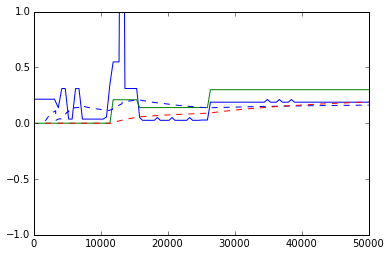

In [60]:
plt.plot( rbg_test_case[::10], global_marginal_rate[::10])
plt.plot(rbg_test_case[::10], marginal_rate[::10])
plt.plot(rbg_test_case[76:], global_average_rate, '--b')
plt.plot(rbg_test_case[76:], average_rate-1, '--r')
plt.ylim(-1,1)
plt.xlim(0,50000)

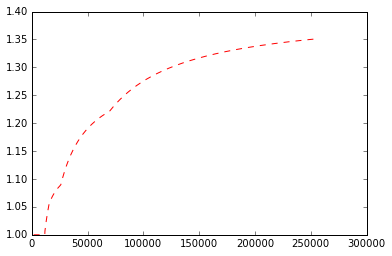

In [61]:
plt.plot(rbg_test_case[76:], average_rate, '--r')

In [62]:
survey_scenario.simulation.calculate("rbg")

array([ 24949.00195312,   4340.        ,      0.        , ...,
         4699.        ,     98.        ,      0.        ], dtype=float32)

In [63]:
income_by_fisal_shares = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))  
df_f["income_by_fiscalshares"] = income_by_fisal_shares
df_m["income_by_fiscalshares"] =  switch_array_entity(income_by_fisal_shares,  "foyer_fiscal", "menage")  #income_by_fiscal_shares
df_f.shape
                                                                     
                              

(52189, 16)

(0, 20000)

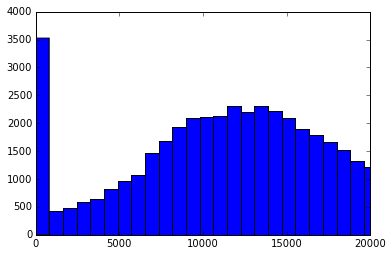

In [64]:
plt.hist(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"), bins = 1000)
plt.xlim(0,20000)

(0, 1)

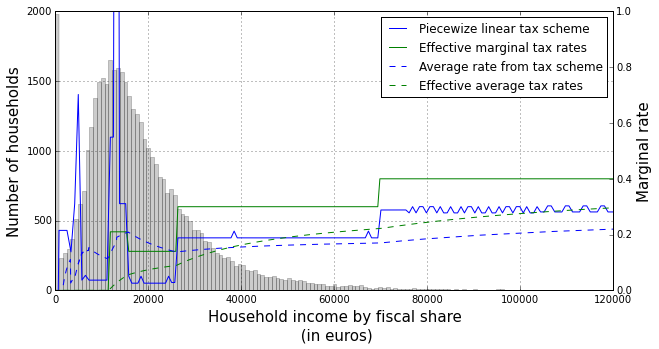

In [65]:
plt.figure(figsize=(10,5))
ax = df_m.income_by_fiscalshares.hist(bins =1000, alpha = 0.2, color = 'k')

ax2 = ax.twinx()
#ax2.plot( rbg_test_case[::35], global_marginal_rate[::35])
ax2.plot( rbg_test_case[::15], global_marginal_rate[::15], '-b',label = "Piecewize linear tax scheme")
ax2.plot(rbg_test_case[::10], marginal_rate[::10],  '-g',label = "Effective marginal tax rates")
ax2.plot(rbg_test_case[76:], global_average_rate, '--b', label = "Average rate from tax scheme")
ax2.plot(rbg_test_case[76:], average_rate-1, '--g', label = "Effective average tax rates")
ax2.legend(loc = 1)
plt.xlim(0,120000)
ax.set_ylabel('Number of households', fontsize=15)
ax.set_xlabel('Household income by fiscal share \n (in euros)', fontsize=15)
ax2.set_ylabel('Marginal rate', fontsize=15)
ax2.set_ylim(0,1)

(0, 1)

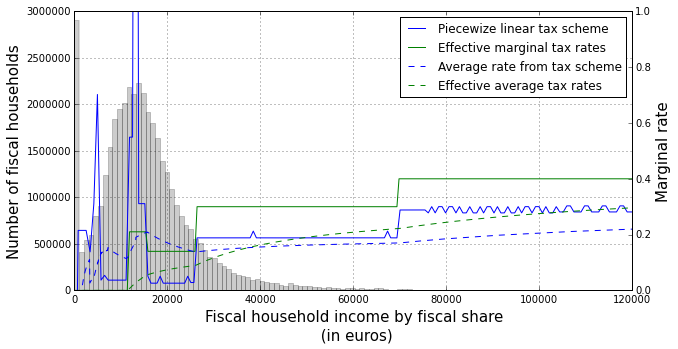

In [66]:
plt.figure(figsize=(10,5))
ax = df_f.income_by_fiscalshares.hist(bins =800, weights = weight_foyers, alpha = 0.2, color = 'k')

ax2 = ax.twinx()
#ax2.plot( rbg_test_case[::35], global_marginal_rate[::35])
ax2.plot( rbg_test_case[::15], global_marginal_rate[::15], '-b',label = "Piecewize linear tax scheme")
ax2.plot(rbg_test_case[::10], marginal_rate[::10],  '-g',label = "Effective marginal tax rates")
ax2.plot(rbg_test_case[76:], global_average_rate, '--b', label = "Average rate from tax scheme")
ax2.plot(rbg_test_case[76:], average_rate-1, '--g', label = "Effective average tax rates")
ax2.legend(loc = 1)
plt.xlim(0,120000)
ax.set_ylabel('Number of fiscal households', fontsize=15)
ax.set_xlabel('Fiscal household income by fiscal share \n (in euros)', fontsize=15)
ax2.set_ylabel('Marginal rate', fontsize=15)
ax2.set_ylim(0,1)

In [67]:
simulation.calculate('rbg_mensuel_times_12', '2009-01')

array([ 25854.,   8680.,      0., ...,  17244.,     98.,      0.], dtype=float32)

In [68]:
rbg_month_by_fs_list = ["rbg_month_by_fs_{}".format(month) for month in range(1,13)]
df_m = pd.DataFrame()

for month in range(1,13):
    month_rbg = np.zeros(52189)
    for var in ['rni_mensuel_times_12']:
        month_rbg += (simulation.calculate(var,"2009-{}".format(month))/12)
    df_m["rbg_month_by_fs_{}".format(month)] = switch_array_entity(month_rbg, 'foyer_fiscal','menage')/switch_entity('nbptr', 'menage')
    

df_m["yearly_rbg_by_fs"] = df_m[rbg_month_by_fs_list].sum(1)
df_m["diff_rbg"] = df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1)
df_m["rbg_relative_var"] = (df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1))/df_m[rbg_month_by_fs_list].max(1)

has_rbg_filter_m = df_m["yearly_rbg_by_fs"]>1

range_to_use = range(1,7000,20)

In [69]:
rbg_month_by_fs_list = ["rbg_month_by_fs_{}".format(month) for month in range(1,13)]
df_f = pd.DataFrame()

for month in range(1,13):
    month_rbg = np.zeros(52189)
    for var in ['rni_mensuel_times_12']:
        month_rbg += (simulation.calculate(var,"2009-{}".format(month))/12)
    df_f["rbg_month_by_fs_{}".format(month)] = month_rbg/simulation.calculate("nbptr")
    

df_f["yearly_rbg_by_fs"] = df_m[rbg_month_by_fs_list].sum(1)
df_f["diff_rbg"] = df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1)
df_f["rbg_relative_var"] = (df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1))/df_m[rbg_month_by_fs_list].max(1)

has_rbg_filter_f = df_m["yearly_rbg_by_fs"]>1

range_to_use = range(1,7000,20)

In [70]:
switch_entity('nbptr', 'menage')

array([ 3.,  1.,  2., ...,  1.,  3.,  2.])

In [71]:
switch_array_entity(month_rbg, 'foyer_fiscal','menage').shape

(42709,)

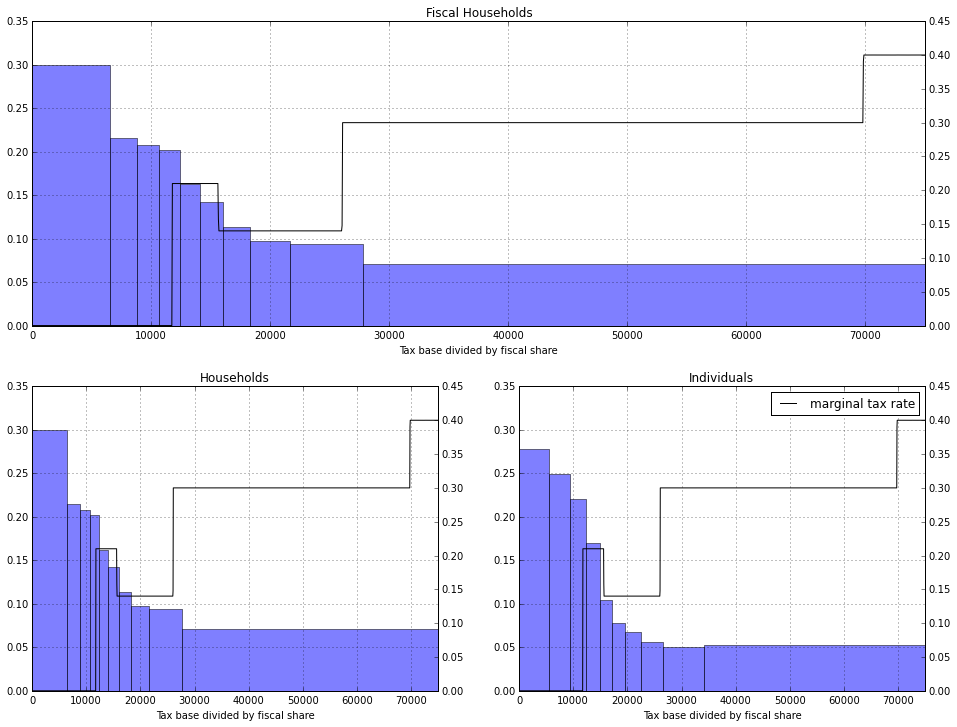

In [72]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(16, 12))


ax1 = plt.subplot2grid((2,2), (1,0), colspan=1) ; plt.figure()

rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))

n,bins,patches = plt.hist(df_m[((df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<rev_max)) & 
                             (df_m.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_m[((df_m.yearly_rbg_by_fs>0)&
                                 (df_m.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax1.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax1.grid()
ax1.set_xlim([0,100000])
ax1.set_title("Households")
ax1_2 = ax1.twinx()
ax1_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax1.set_xlim(0,75000)

ax1.set_xlabel('Tax base divided by fiscal share')






ax2 = plt.subplot2grid((2,2), (0,0), colspan=2,  sharey=ax1)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")
ax2.set_xlabel('Tax base divided by fiscal share')




ax3 = plt.subplot2grid((2,2), (1,1), colspan=1, sharey=ax1)
plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df[((df.yearly_income>0)&(df.yearly_income<rev_max)) & 
                             (df.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df[((df.yearly_income>0)&
                                 (df.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax3.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax3.grid()
ax3_2 = ax3.twinx()
ax3_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax3_2.legend()

ax3.set_xlim([0,75000])
ax3.set_title("Individuals")
ax3.set_xlabel('Tax base divided by fiscal share')

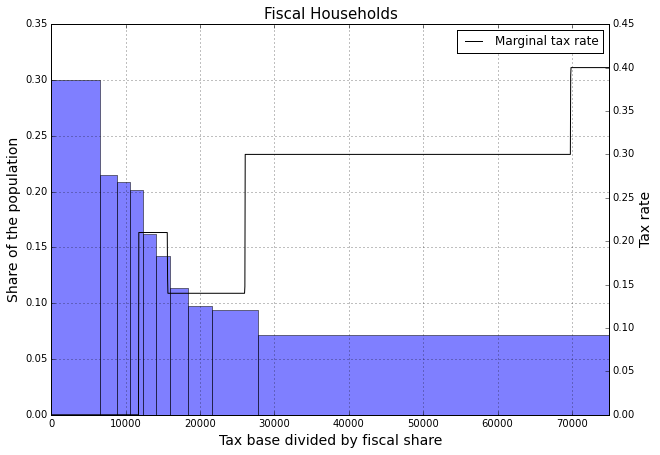

In [73]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(10, 7))








ax2 = plt.subplot2grid((1,1), (0,0), colspan=2)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")
ax2_2.set_ylabel("Tax rate", fontsize = 14)


ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households",  fontsize=15)
ax2.set_ylabel("Share of the population",  fontsize=14)
ax2.set_xlabel('Tax base divided by fiscal share',  fontsize=14)
ax2_2.legend()




### More then 20% only for those with a unique income for each month (with no null income)

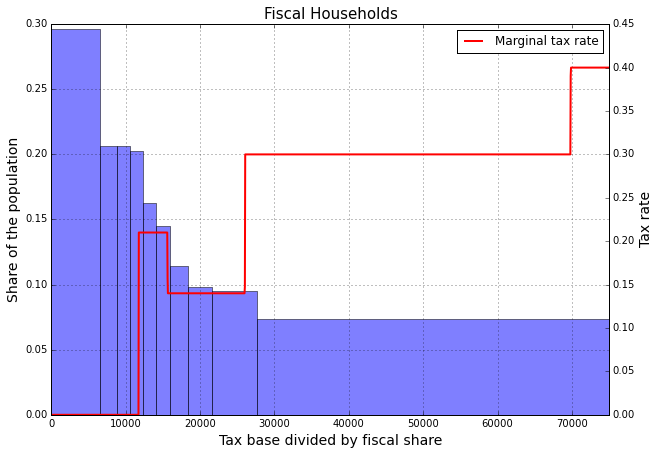

In [76]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(10, 7))








ax2 = plt.subplot2grid((1,1), (0,0), colspan=2)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)) &
                     has_rev_unic_each_month_filter_f
                    ].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2) &
                              has_rev_unic_each_month_filter_f
                            ].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)) &
                    has_rev_unic_each_month_filter_f
                    ].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))&
                                 has_rev_unic_each_month_filter_f].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'r', linewidth = 2, label = "Marginal tax rate")
ax2_2.set_ylabel("Tax rate", fontsize = 14)


ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households",  fontsize=15)
ax2.set_ylabel("Share of the population",  fontsize=14)
ax2.set_xlabel('Tax base divided by fiscal share',  fontsize=14)
ax2_2.legend()




### Reforme

In [99]:
print pd.Series(survey_scenario.simulation.calculate("lambda_compensation", period.this_year) == 0 
         ).value_counts(normalize = True)
print pd.Series(np.abs(survey_scenario.simulation.calculate("lambda_compensation", period.this_year)) <= 0.01 
         ).value_counts(normalize = True)

False    0.810113
True     0.189887
dtype: float64
True     0.583016
False    0.416984
dtype: float64


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


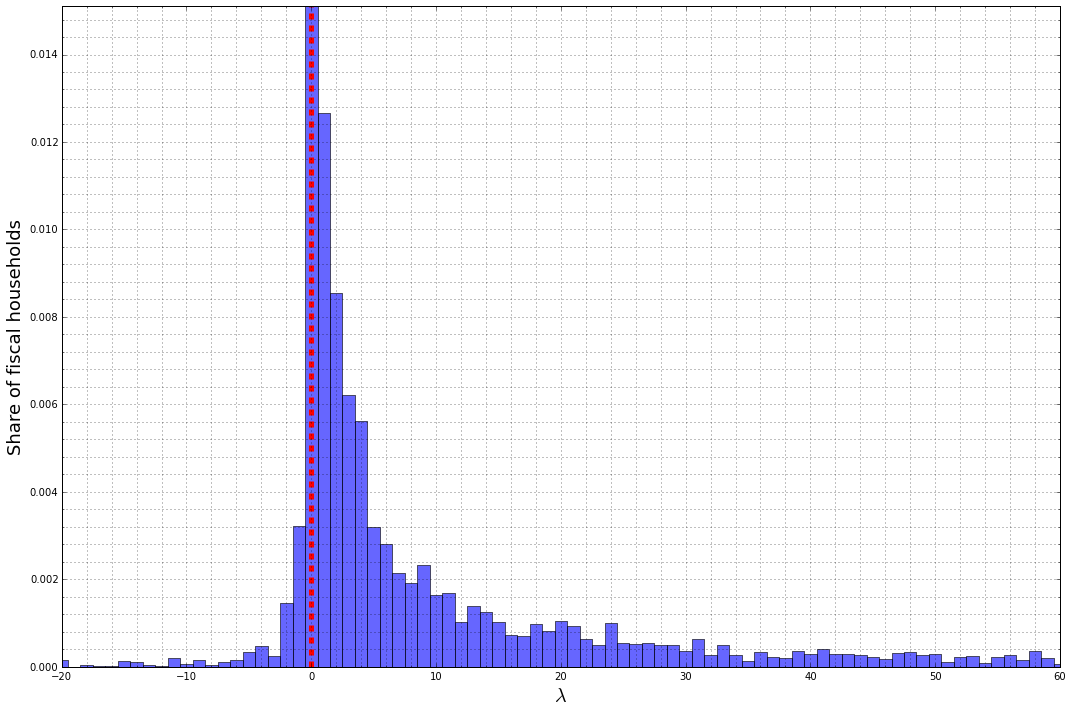

In [100]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)

bins= np.arange(-100.5, 100.5, 1)

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)

graph_filter = (np.abs(lambda_compensation)<100)


fig, ax = plt.subplots(1,1,sharey = True, figsize = (15, 10), tight_layout = True)

ax = [ax,'']

ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))



weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = bins, weights = weights, alpha = 0.6)


ax[0].set_ylim(0,0.0151)
ax[0].set_xlim(-20,60)
#
#ax[0].set_title("Fiscal Households", weight = "bold")
ax[0].set_ylabel('Share of fiscal households', fontsize = 18 )
ax[0].set_xlabel('$\lambda$', fontsize = 20)
ax[0].grid(which = 'both')

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


plt.axvline(linewidth = 5, color = "r", ls = '--')


In [101]:
matplotlib.rcParams.update({'font.size': 10})

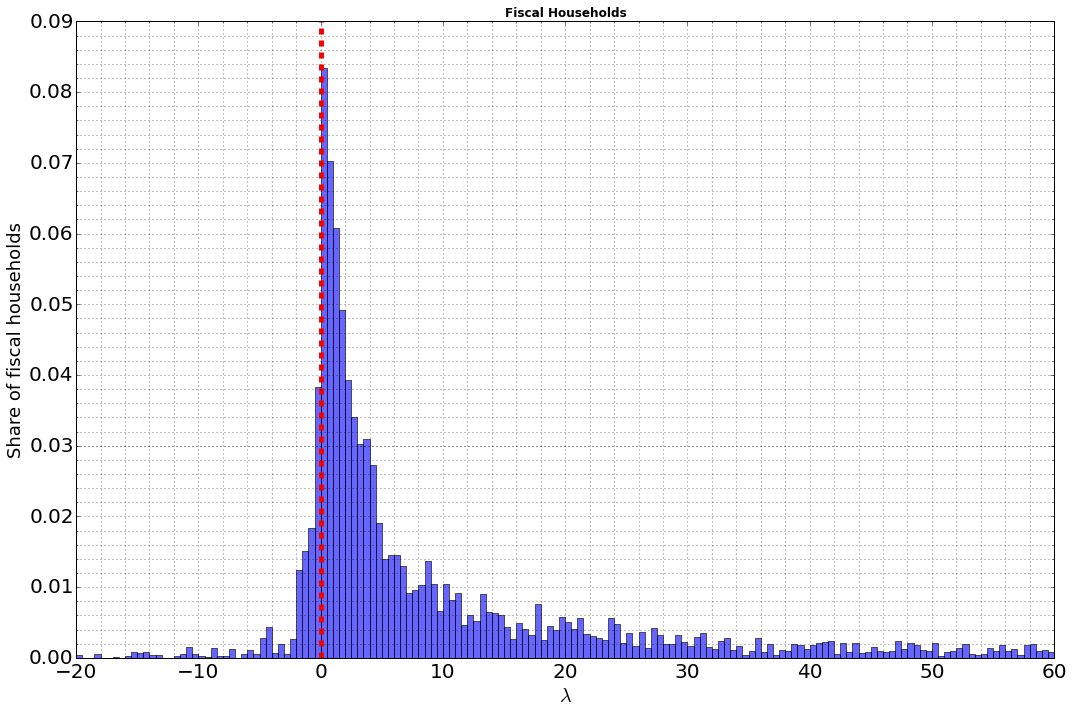

In [102]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)

bins= np.arange(-100, 100, 0.5)

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)

graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


fig, ax = plt.subplots(1,1,sharey = True, figsize = (15, 10), tight_layout = True)

ax = [ax,'']

ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))



weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = bins, weights = weights, alpha = 0.6)
#ax[0].set_ylim(0,0.21)
ax[0].set_xlim(-20,60)
#
ax[0].set_title("Fiscal Households", weight = "bold")
ax[0].set_ylabel('Share of fiscal households', fontsize = 18 )
ax[0].set_xlabel('$\lambda$', fontsize = 20)
ax[0].grid(which = 'both')




plt.axvline(linewidth = 5, color = "r", ls = '--')

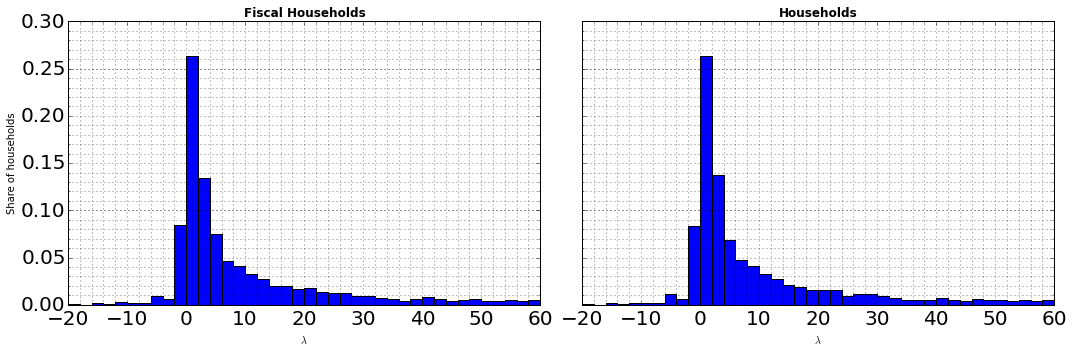

In [103]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)

bins= range(-100,100, 2)

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
lambda_compensation_household = switch_array_entity(lambda_compensation,'foyer_fiscal', 'menage')
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)
graph_filter_household = switch_array_entity(graph_filter, 'foyer_fiscal', 'menage').astype('bool')

fig, ax = plt.subplots(1,2,sharey = True, figsize = (15, 5), tight_layout = True)


ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))

ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))


weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = bins, weights = weights)
#ax[0].set_ylim(0,0.21)
ax[0].set_xlim(-20,60)
ax[0].set_title("Fiscal Households", weight = "bold")
ax[0].set_ylabel('Share of households')
ax[0].set_xlabel('$\lambda$')
ax[0].grid(which = 'both')
ax[1].grid(which = 'both')


weights = weight_menages[graph_filter_household & ~np.isnan(lambda_compensation_household)]/sum(weight_menages[graph_filter_household& ~np.isnan(lambda_compensation_household)])
ax[1].hist(pd.Series(lambda_compensation_household[graph_filter_household]).dropna(), 
           bins = bins, weights= weights)
ax[1].set_xlim(-20,60)

ax[1].set_xlabel('$\lambda$')
ax[1].set_title("Households", weight = "bold")



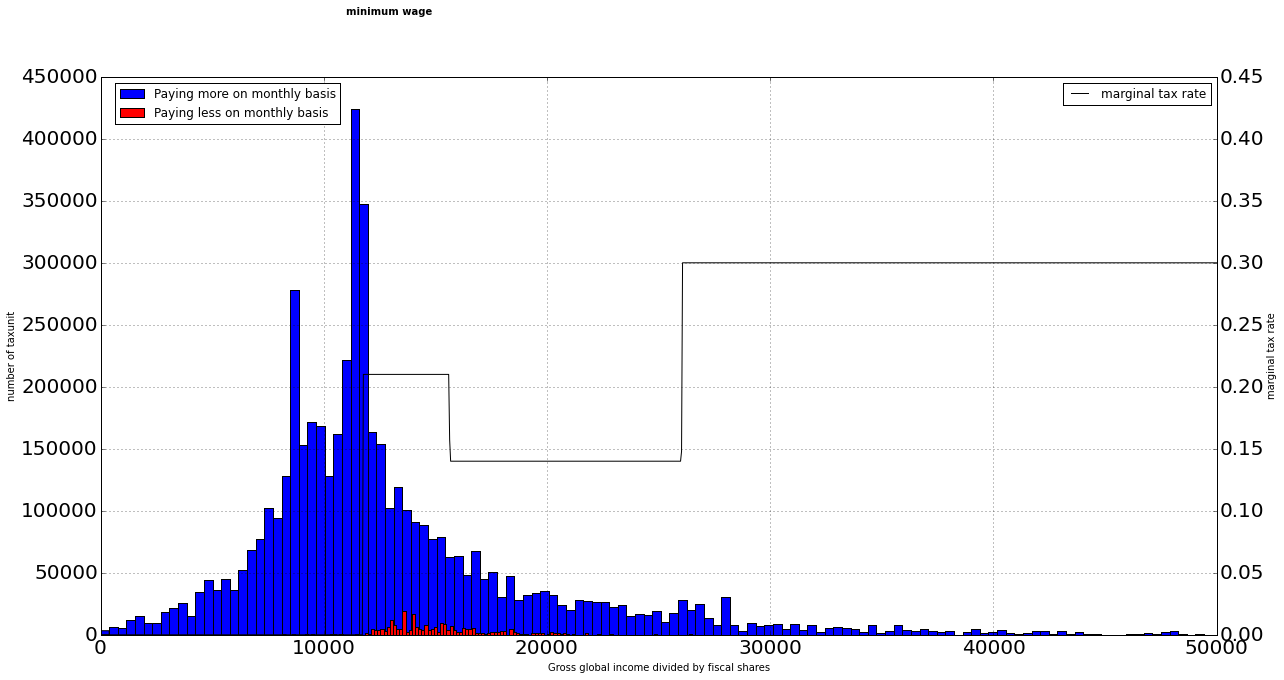

In [104]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", 
         weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",
         weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")


In [105]:
winners_condition = [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1]
winners = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))[winners_condition]

loosers_condition = [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1]
loosers = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))[loosers_condition]


In [111]:
print winners.shape
print loosers.shape

(6532,)
(283,)


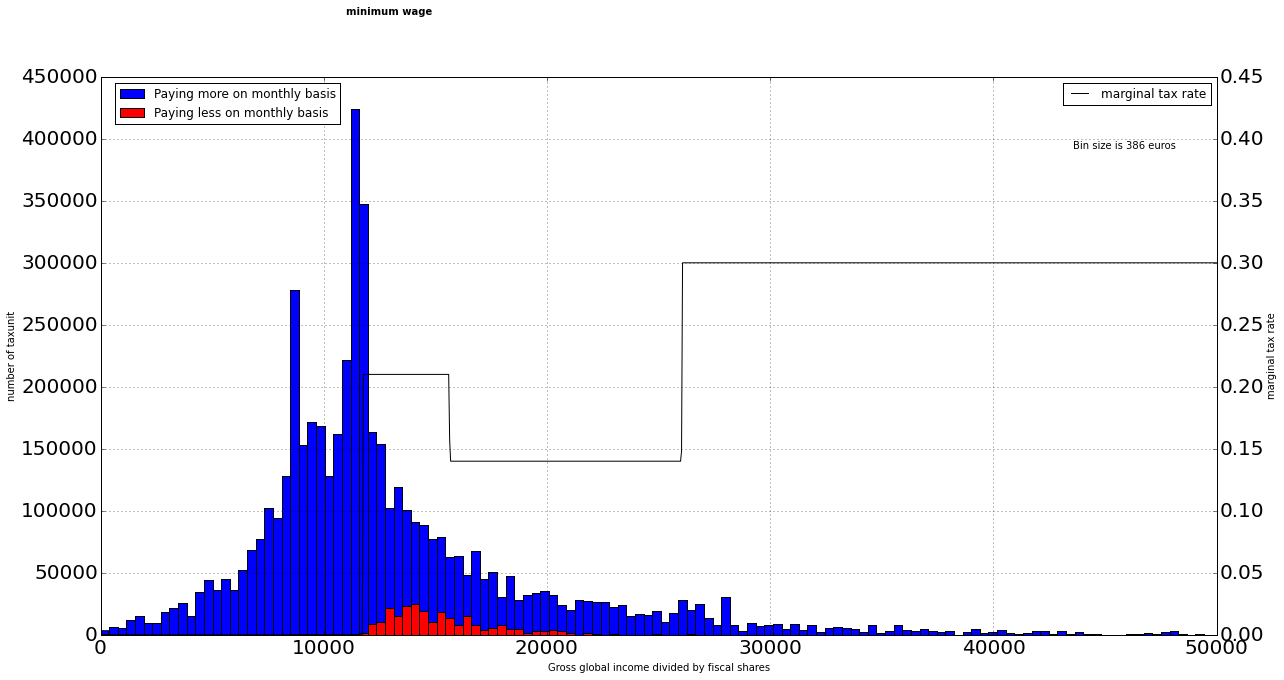

In [106]:

###One euro
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")
fig.text(0.8,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

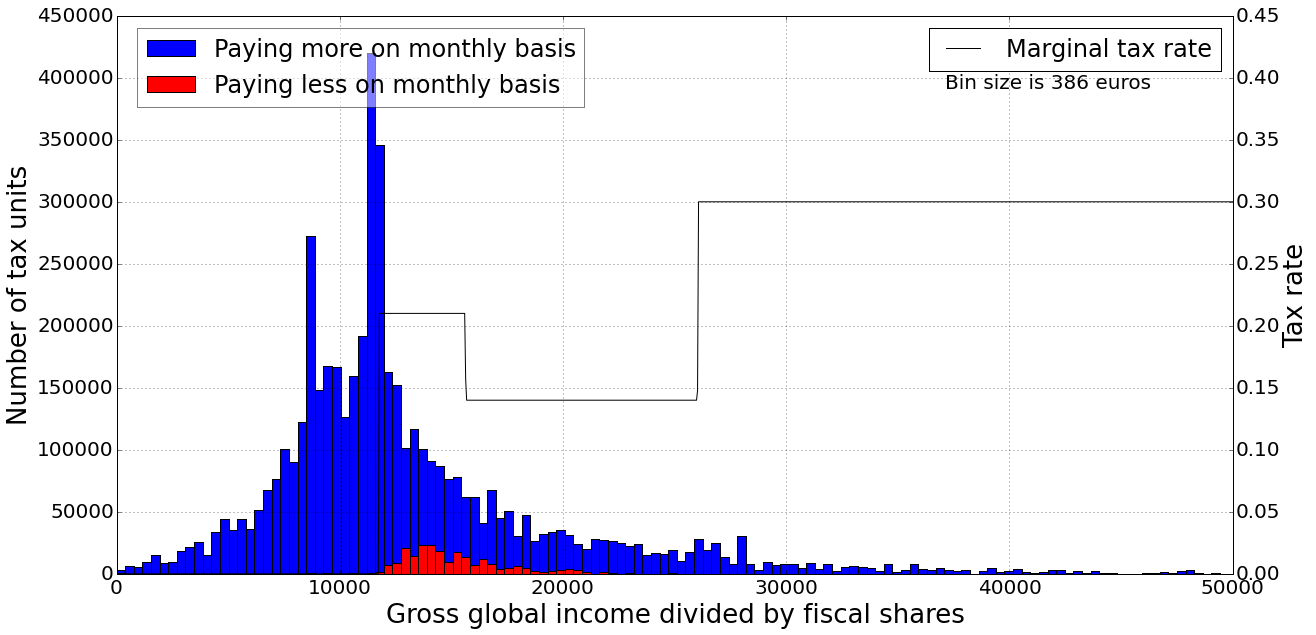

In [107]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
#5 euros
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>5]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-5]

fig, ax1 = plt.subplots(figsize=(20, 10))


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>5], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-5], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
legend = ax1.legend(bbox_to_anchor=(0.43, 1))
ax1.grid(which = 'both')
#ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("Tax rate", fontsize = 26)
ax1.set_xlabel("Gross global income divided by fiscal shares", fontsize = 26)
ax1.set_ylabel("Number of tax units", fontsize = 26)
ax1.set_title("")
legend.get_frame().set_alpha(0.5)
#ax1.set_ylim(0,500000)
fig.text(0.7,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

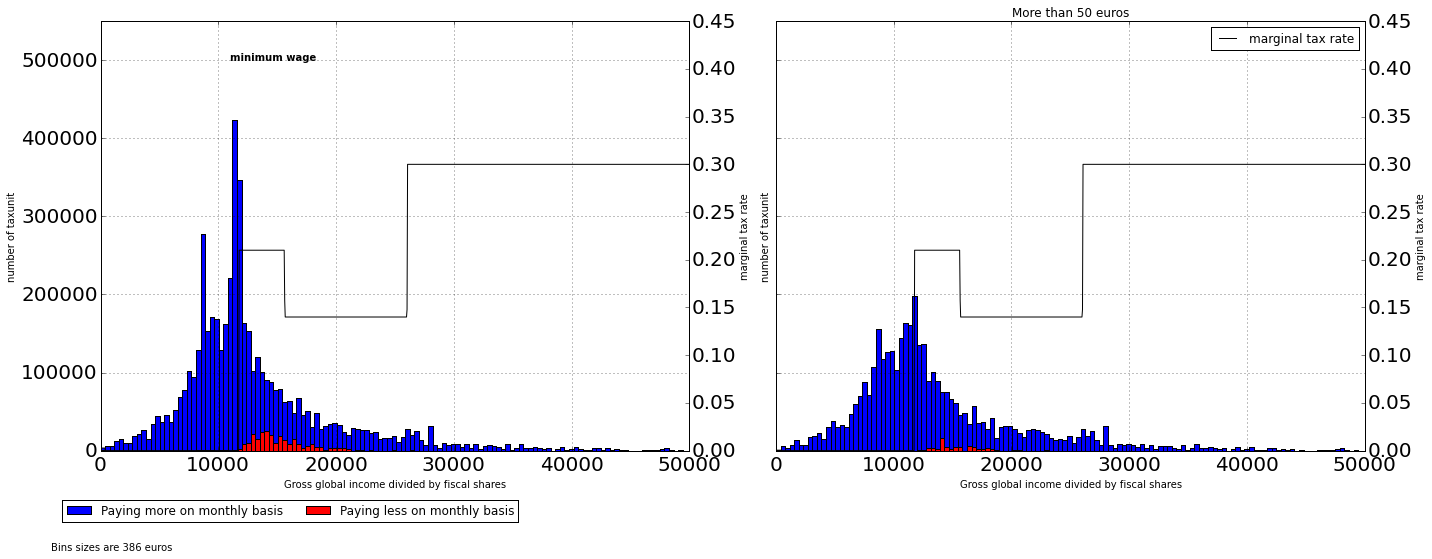

In [83]:
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)


###One euro
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

hist_1 = ax[0].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = bins, label = "Paying more on monthly basis", weights= weights1)
hist_2 = ax[0].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax[0].set_xlim(0,50000)
ax2 = ax[0].twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
#ax2.legend()

ax[0].grid(which = 'both')
ax[0].text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax[0].set_xlabel("Gross global income divided by fiscal shares")
ax[0].set_ylabel("number of taxunit")
ax[0].set_title("")
#fig.text(0.8,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

#50 euros
amount = 50
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>amount]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-amount]



bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax[1].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>amount], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax[1].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-amount], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax[1].set_xlim(0,50000)
ax2 = ax[1].twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
#legend = ax[1].legend(bbox_to_anchor=(0.22, 1))
ax[1].grid(which = 'both')
#ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax[1].set_xlabel("Gross global income divided by fiscal shares")
ax[1].set_ylabel("number of taxunit")
ax[1].set_title("More than {} euros".format(amount))
legend.get_frame().set_alpha(0.5)
ax[1].set_ylim(0,550000)

ax[0].legend(bbox_to_anchor=(0.72, -0.1), ncol = 3)
fig.text(0.038,-0.1,'Bins sizes are {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))
#fig.text(.38,-0.05,'Bins sizes are {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

In [84]:
last_salaire = np.zeros(weight_individus.shape)
last_chomage = np.zeros(weight_individus.shape)
entree_chomage = np.zeros(weight_individus.shape)
sortie_chomage = np.zeros(weight_individus.shape)
last_retraite = np.zeros(weight_individus.shape)
passage_retraite = np.zeros(weight_individus.shape)
passage_inactif = np.zeros(weight_individus.shape)
for month in range(1,13):
    salaire = simulation.calculate('salaire_imposable', '2009-{}'.format(month))
    diff_salaire =  salaire - last_salaire
    chomage = simulation.calculate('chomage_imposable', '2009-{}'.format(month))
    diff_chomage =  chomage - last_chomage
    retraite = simulation.calculate('retraite_imposable', '2009-{}'.format(month))
    diff_retraite =  retraite - last_retraite
    
    
    entree_chomage += (diff_chomage>1) & (diff_salaire < -1)
    sortie_chomage += (diff_chomage<-1) & (diff_salaire > 1)
    
    passage_retraite += (diff_retraite> 1 ) & (diff_salaire < 1)
    passage_inactif += (diff_chomage == 0) & (diff_salaire >1)
    
    last_salaire = simulation.calculate('salaire_imposable', '2009-{}'.format(month))
    last_chomage = simulation.calculate('chomage_imposable', '2009-{}'.format(month))
    last_retraite = simulation.calculate('retraite_imposable', '2009-{}'.format(month))

In [85]:
pd.Series(passage_retraite).value_counts(normalize = True)

0    0.714302
1    0.285039
2    0.000634
4    0.000012
3    0.000012
dtype: float64

In [86]:
amount = 1
winner =(-survey_scenario.simulation.calculate_add("irpp")-
         -survey_scenario.simulation.calculate_add("irpp_mensuel"))>amount

looser =(-survey_scenario.simulation.calculate_add("irpp")-
         -survey_scenario.simulation.calculate_add("irpp_mensuel"))<-amount


In [87]:
survey_scenario.simulation.calculate_add("irpp").sum()

-87099936.0

In [88]:
retraite = passage_retraite
perte_ou_prise_emploi = entree_chomage+sortie_chomage+passage_inactif

In [89]:
retraite = sum_array_by_entity(pd.Series(retraite).astype('bool'),  'foyer_fiscal').astype('bool')
perte_ou_prise_emploi = sum_array_by_entity(pd.Series(perte_ou_prise_emploi).astype('bool'),  'foyer_fiscal').astype('bool')

In [90]:
retraite.shape

(52189,)

In [91]:
winner.shape

(52189,)

In [92]:
print winner[retraite].sum()/winner.shape[0]
print looser[retraite].sum()
print winner[perte_ou_prise_emploi].sum()
print looser[perte_ou_prise_emploi].sum()

0.00136043993945
2533
254
4358


In [93]:
print ((winner*weight_foyers)[retraite].sum()/weight_foyers.sum())*100
print ((looser*weight_foyers)[retraite].sum()/weight_foyers.sum())*100
print ((winner*weight_foyers)[perte_ou_prise_emploi].sum()/weight_foyers.sum())*100
print ((looser*weight_foyers)[perte_ou_prise_emploi].sum()/weight_foyers.sum())*100

0.126266502203
4.49974262092
0.557176511527
8.60830475691


0.12% des foyers sont gagnants à cause d'un passage à la retraite.

4,49% des foyers sont perdants à cause d'un passage à la retraite.

0.56% des foyers sont gagnants à cause d'une perte ou d'une prise d'emploi

8.6% des foyers sont perdants à cause d'une perte ou d'une prise d'emploi.


In [94]:
pd.Series(passage_retraite).value_counts(normalize=True)

0    0.714302
1    0.285039
2    0.000634
4    0.000012
3    0.000012
dtype: float64

In [95]:
print (retraite[winner].sum()/weight_foyers.sum())*100
print ((looser*weight_foyers)[retraite].sum()/weight_foyers.sum())*100
print ((winner*weight_foyers)[perte_ou_prise_emploi].sum()/weight_foyers.sum())*100
print ((looser*weight_foyers)[perte_ou_prise_emploi].sum()/weight_foyers.sum())*100

0.00017368166138
4.49974262092
0.557176511527
8.60830475691


In [321]:
52+8+25+5

90

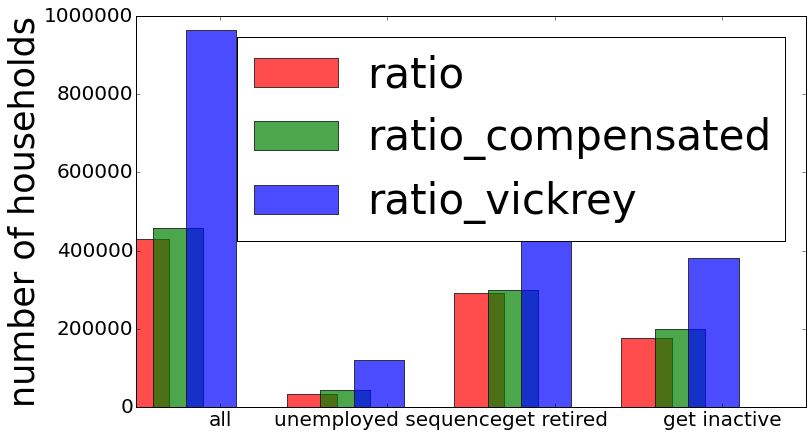

In [277]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = (sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool")) & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    
    condition = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    condition = (sum_array_by_entity(passage_inactif,  'menage').astype("bool")) & ~(sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool"))

    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    

    hello = ax.bar(0.4+ np.array(range(4))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,4.5))
#plt.ylim((0,100000))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired', 'get inactive'))


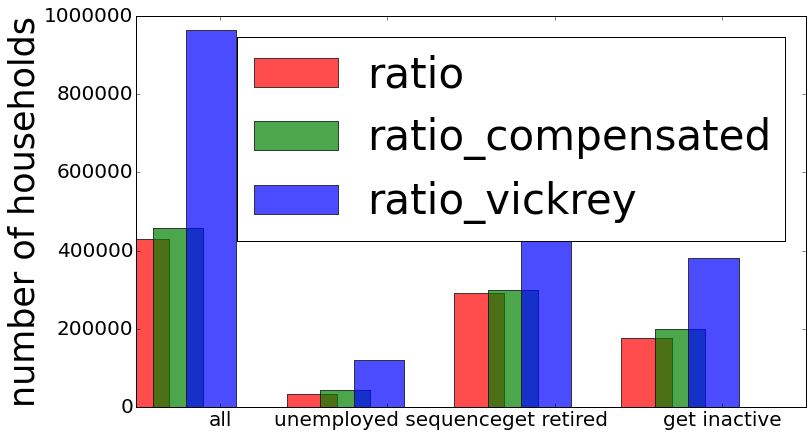

In [165]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = (sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool")) & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    
    condition = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    condition = (sum_array_by_entity(passage_inactif,  'menage').astype("bool")) & ~(sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool"))

    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    

    hello = ax.bar(0.4+ np.array(range(4))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,4.5))
#plt.ylim((0,100000))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired', 'get inactive'))


##  Utility analysis

In [116]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))
u_vickrey = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_vickrey_mensuel','2009'))


In [126]:
print (u_ir_m - u_ir_a<0).value_counts(normalize = True)
print (u_ir_m - u_ir_a>0).value_counts(normalize = True)

False    0.899857
True     0.100143
dtype: float64
False    0.925589
True     0.074411
dtype: float64


In [125]:
print (u_c_ir - u_ir_a<0).value_counts(normalize = True)
print (u_c_ir - u_ir_a>0).value_counts(normalize = True)

False    0.979723
True     0.020277
dtype: float64
False    0.907818
True     0.092182
dtype: float64


In [124]:
print (u_vickrey - u_ir_a<0).value_counts(normalize = True)
print (u_vickrey - u_ir_a>0).value_counts(normalize = True)

False    0.937741
True     0.062259
dtype: float64
False    0.865508
True     0.134492
dtype: float64


In [ ]:
[lambda_compensation!=0]

In [127]:
print (u_ir_m - u_ir_a<0)[lambda_compensation!=0].value_counts(normalize = True)
print (u_ir_m - u_ir_a>0)[lambda_compensation!=0].value_counts(normalize = True)

/usr/local/lib/python2.7/site-packages/pandas/core/internals.py:179: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 42709 but corresponding boolean dimension is 52189
  return self.values[slicer]
/usr/local/lib/python2.7/site-packages/pandas/core/series.py:631: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 42709 but corresponding boolean dimension is 52189
  return self.values[indexer]


IndexError: index 42709 is out of bounds for axis 1 with size 42709

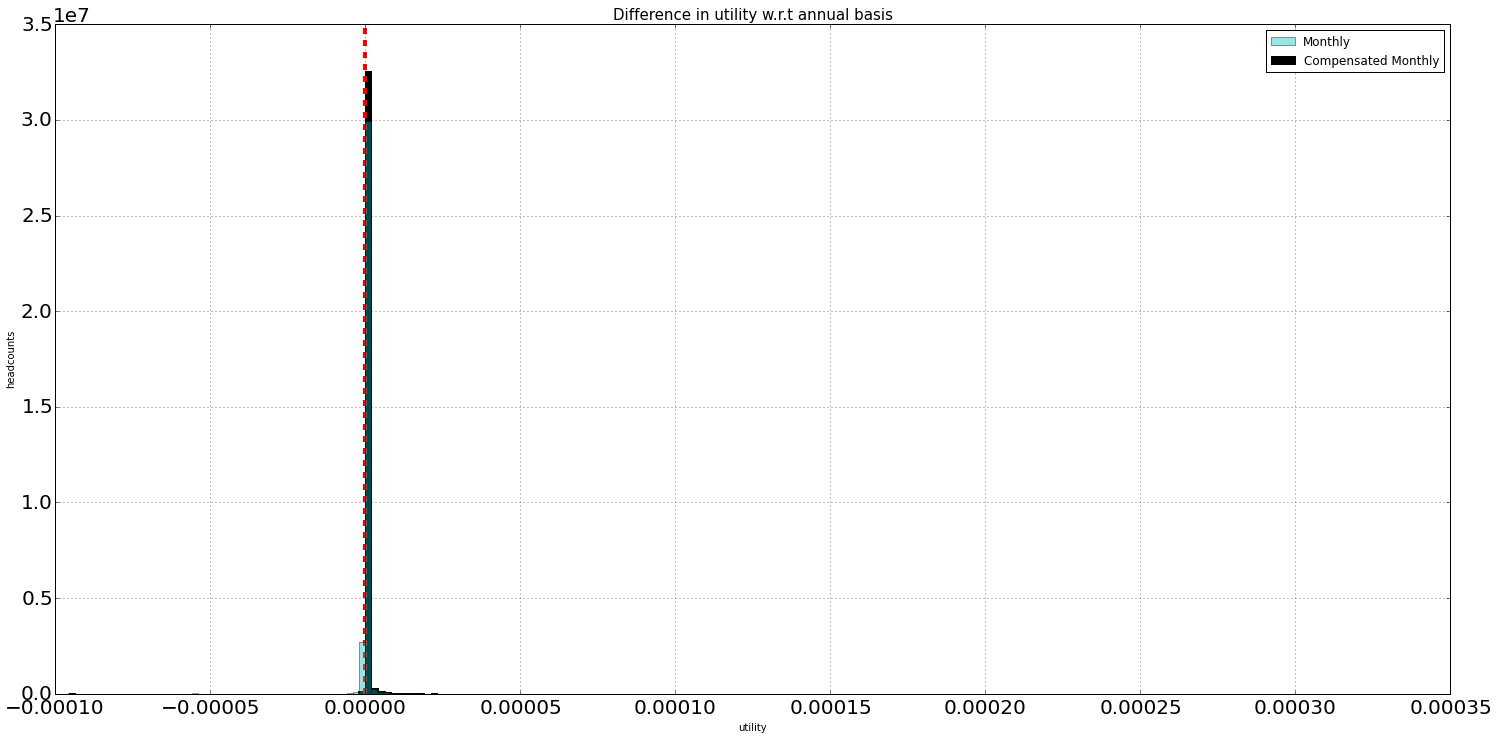

In [85]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,20*10**4)
#plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

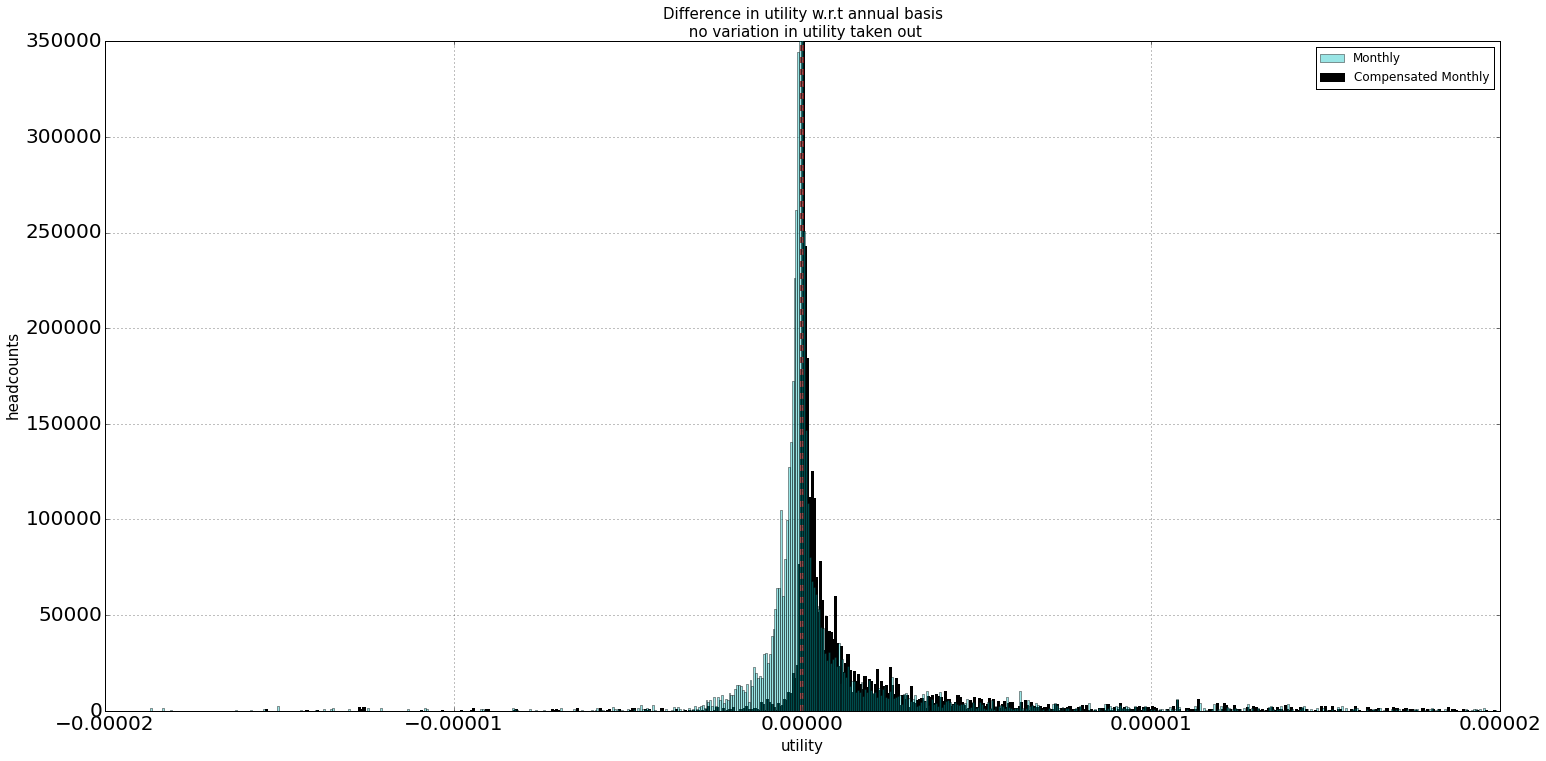

In [86]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    bins = np.histogram(np.hstack((weight_1,weight_2)), bins = 7000)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=7000,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=7000,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [114]:
execute_time_consuming_graph = True
matplotlib.rcParams.update({'font.size': 25})
if execute_time_consuming_graph == True : 
    bins= np.arange(-0.00002, 0.00002, 0.0000005)

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((u_ir_m - u_ir_a))!=0]
                                    ,(u_c_ir - u_ir_a)[((u_c_ir - u_ir_a))!=0]
            )), bins = bins)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=10, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out")
    plt.xlabel('Utility')
    plt.ylabel('Headcounts', size = 20)

NameError: name 'u_ir_m' is not defined

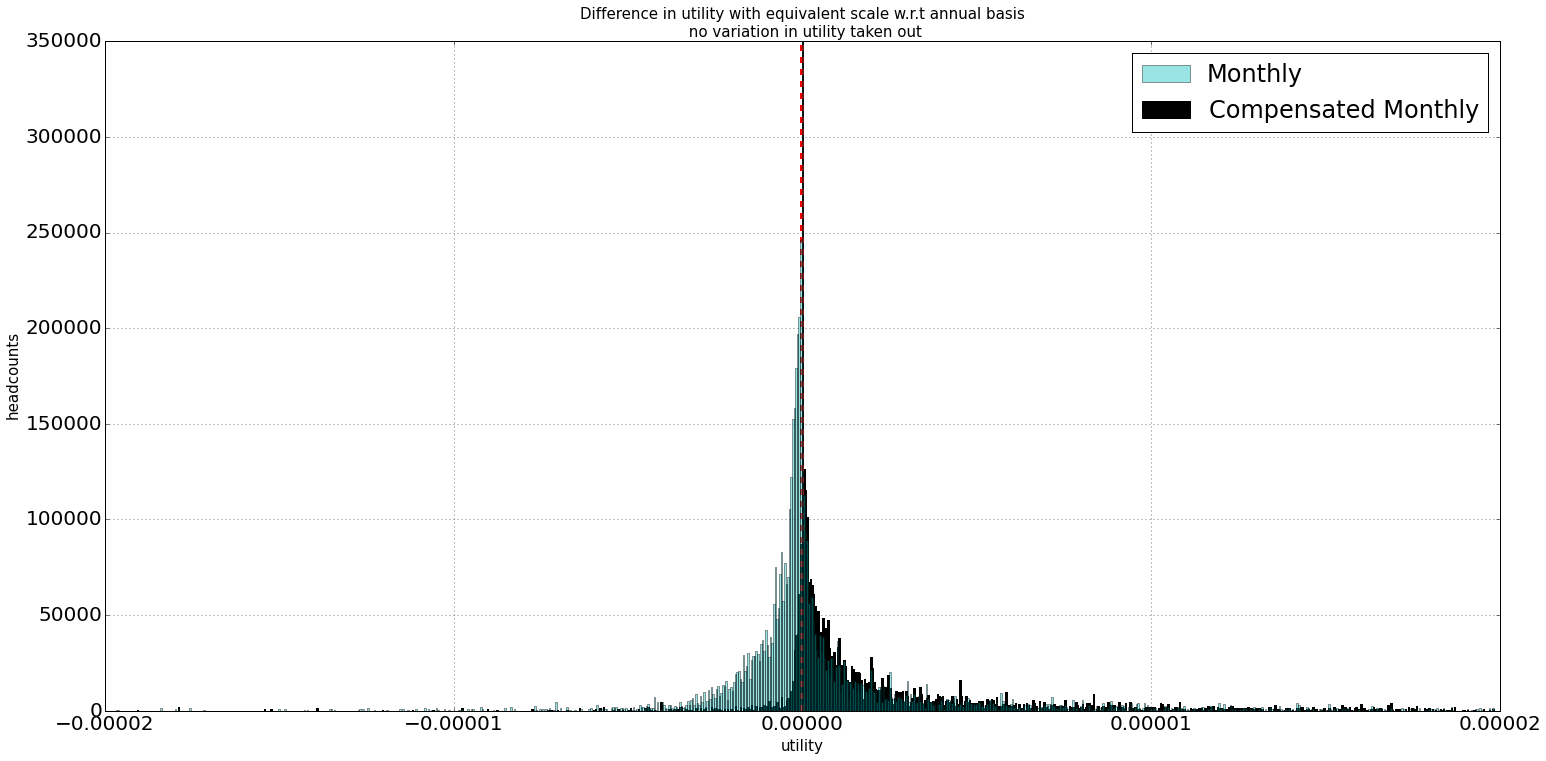

In [113]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 14000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [89]:
matplotlib.rcParams.update({'font.size': 25})

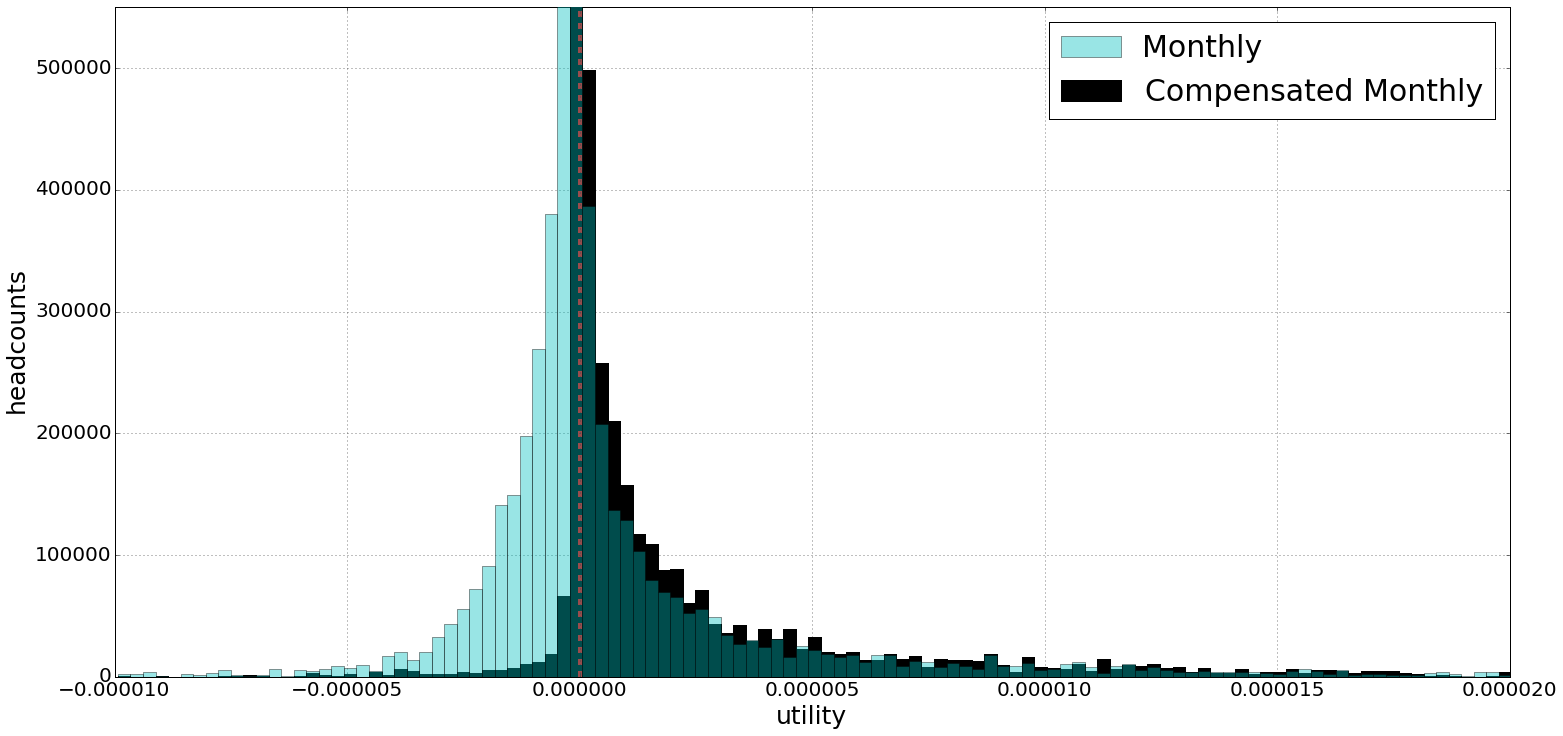

In [90]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))

u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 2300)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,55*10**4)
    plt.xlim(-0.00001, 0.00002)
    plt.legend()
    #plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility')
    plt.ylabel('headcounts')

In [91]:
matplotlib.rcParams.update({'font.size': 10})

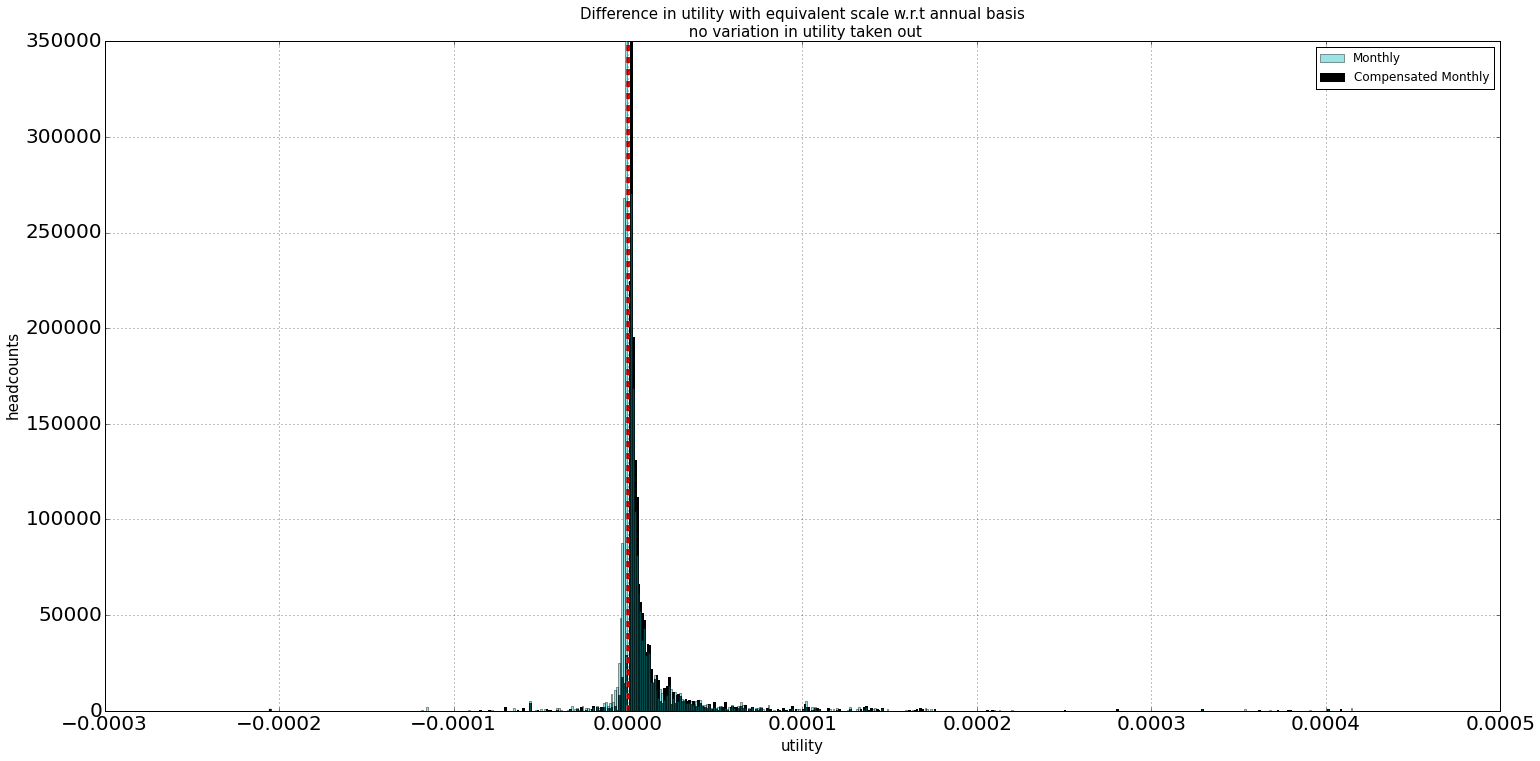

In [92]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    value_near_zero = 0.0000009
    weight_1 = pd.Series(weight_menages)[(np.abs((u_es_ir_m - u_es_ir_a)))>value_near_zero].values
    weight_2 = pd.Series(weight_menages)[np.abs(u_es_c_ir - u_es_ir_a)> value_near_zero].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero]
                                    ,(u_es_c_ir - u_es_ir_a)[np.abs((u_es_c_ir - u_es_ir_a))>value_near_zero]
            )), bins = 600)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[(np.abs(u_es_c_ir - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    #plt.xlim(-0.002, 0.002)
    plt.legend()    

    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

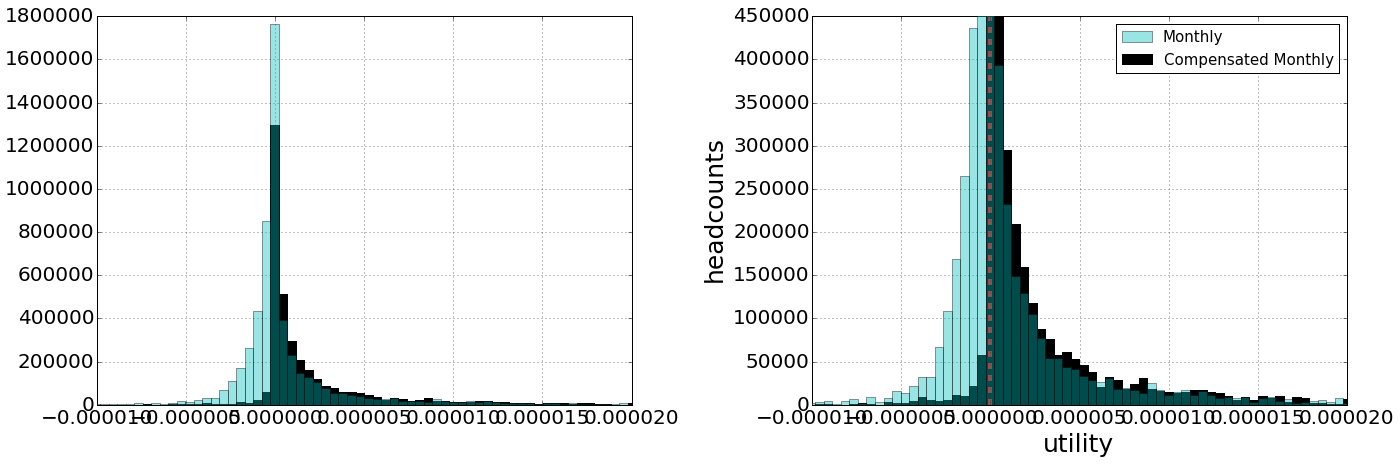

In [93]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
matplotlib.rcParams.update({'font.size': 25})
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 
    fig, ax = plt.subplots(1,2,sharey = False, figsize = (20, 7), tight_layout = True)

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 1300)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist( bins=bins, ax=ax[0],
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist( bins=bins,ax=ax[0],
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    
    
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist( bins=bins, ax=ax[1],
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist( bins=bins,ax=ax[1],
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")


    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,45*10**4)
    plt.xlim(-0.00001, 0.00002)
    
    ax[0].set_xlim((-0.00001, 0.00002))
    
    plt.legend(fontsize = 15)
    #plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility')
    plt.ylabel('headcounts')

##### Ce qui est fait pour le graph with equivalent scale : 
 - $u( \frac{\sum(y)}{ES})$ donne l'utilités d'un ménage, ou l'utilité moyenne des individus composant le ménage.
 - $u( \frac{\sum(y)}{ES})*ES $ donne l'utilité totale d'un ménage
 - et $u(\frac{\sum(y)}{ES})$ donnerait l'utilité d'un seul individu du ménage
 
###### Si on veut comparer une diff d'uilité entre deux système de taxe $u_1$ et $u_2$ : 
 - $u_1( \frac{\sum(y)}{ES}) * ES - u_2( \frac{\sum(y)}{ES}) *ES = ES [u_1( \frac{\sum(y)}{ES}) - u_2( \frac{\sum(y)}{ES})]  $ et créerai des écarts plus grand pour des ménages plus grands, alors que l'écart d'utilité moyenne serait la même.
 - Pour avoir une information individuelle, il faut prendre l'écart d'utilité pour chaque individus $u(\frac{\sum(y)}{ES})$ et multiplier le poids de l'observation par le nombre d'individus du ménage.


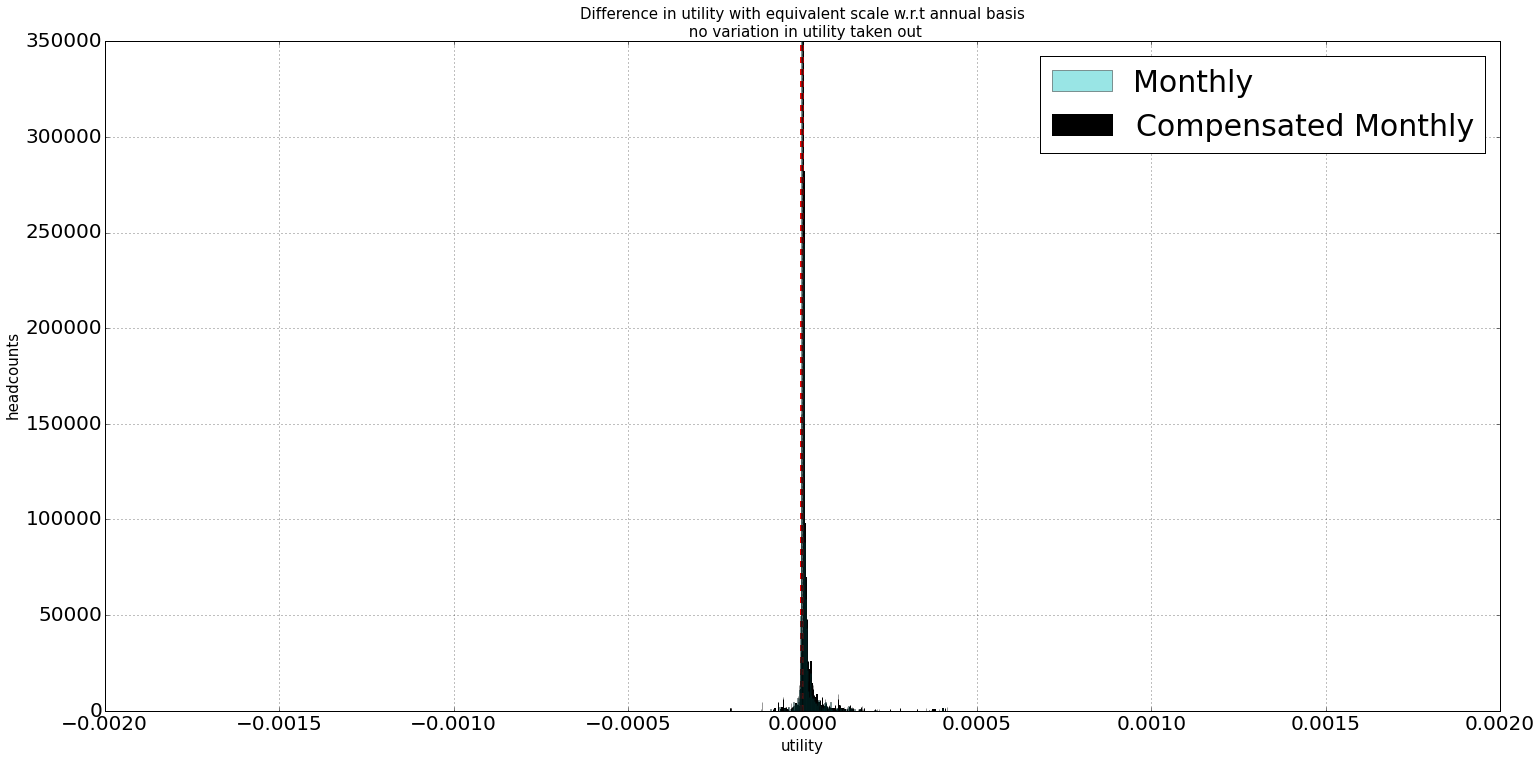

In [94]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    value_near_zero = 0.0000009
    weight_1 = pd.Series(weight_menages*uc('menage'))[(np.abs((u_es_ir_m - u_es_ir_a)))>value_near_zero].values
    weight_2 = pd.Series(weight_menages*uc('menage'))[np.abs(u_es_c_ir - u_es_ir_a)> value_near_zero].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero]
                                    ,(u_es_c_ir - u_es_ir_a)[np.abs((u_es_c_ir - u_es_ir_a))>value_near_zero]
            )), bins = 600)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[(np.abs(u_es_c_ir - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()    

    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

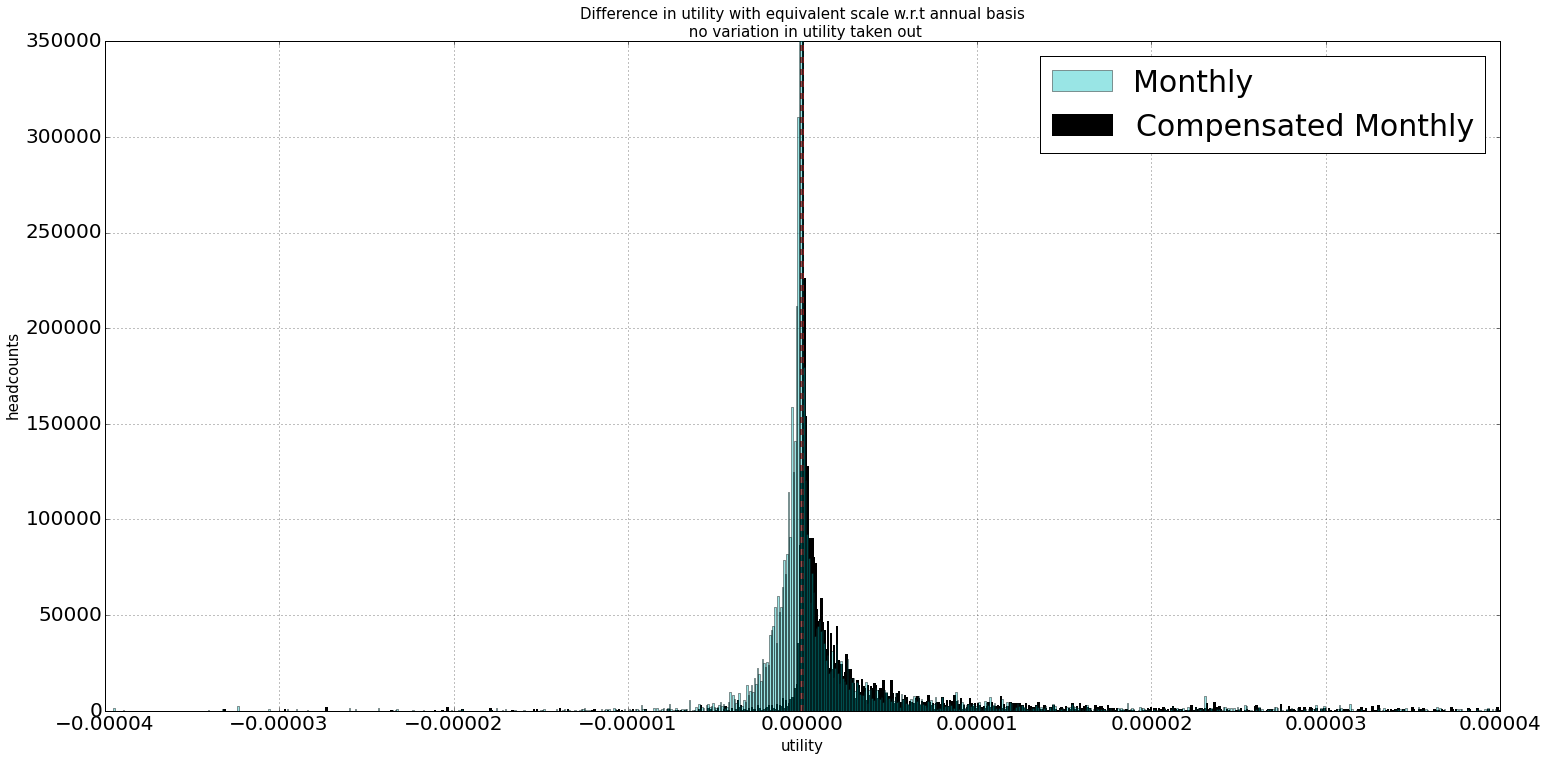

In [95]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 7000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00004, 0.00004)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

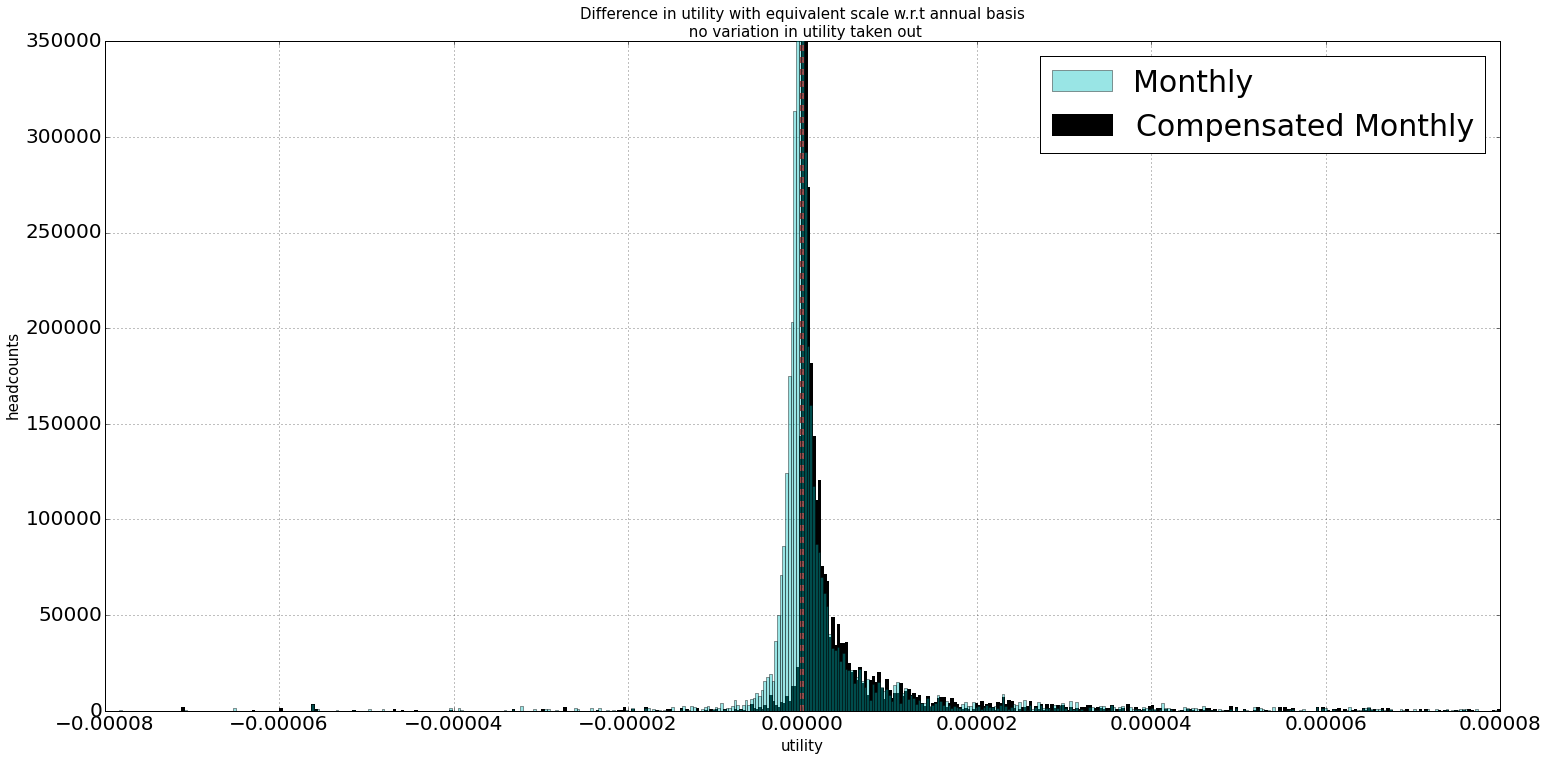

In [96]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 2000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00008, 0.00008)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

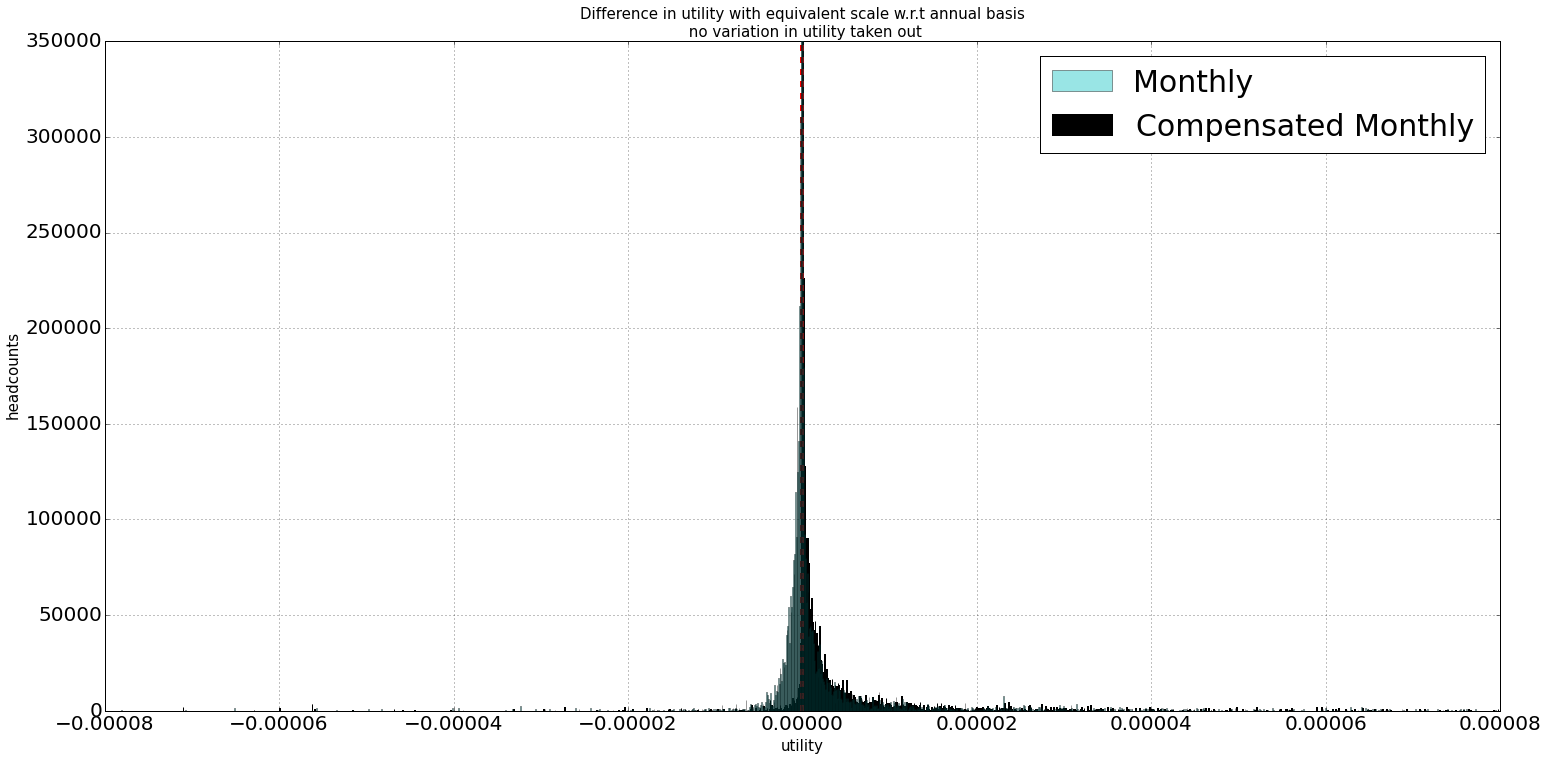

In [97]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 7000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00008, 0.00008)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

### Vickrey utility 

In [98]:
matplotlib.rcParams.update({'font.size': 35})

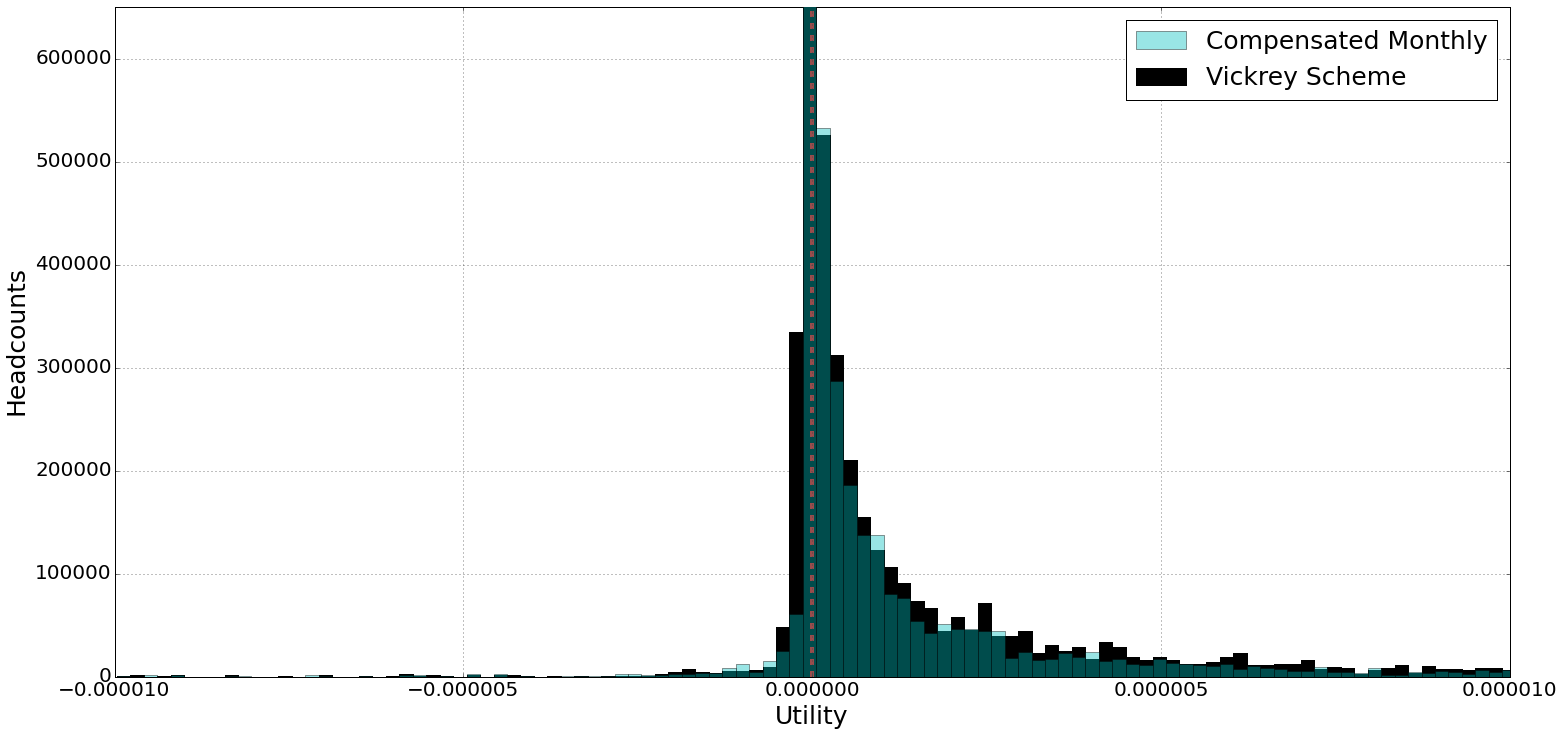

In [99]:

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    weight_3 = pd.Series(weight_menages)[((u_vickrey - u_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((u_ir_m - u_ir_a))!=0]
                                    ,(u_c_ir - u_ir_a)[((u_c_ir - u_ir_a))!=0], (u_vickrey - u_ir_a)[((u_vickrey - u_ir_a))!=0]
            )), bins = 2200)[1]
    
#    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
#                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=10, color = 'c',alpha = 0.4, label = "Compensated Monthly")
    hist3 = ((u_vickrey - u_ir_a))[((u_vickrey - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_3,zorder=1, color = 'k',alpha = 1, label = "Vickrey Scheme")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,65*10**4)
    plt.xlim(-0.00001, 0.00001)
    plt.legend(fontsize = 25)
    #plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('Utility', size = 25)
    plt.ylabel('Headcounts', size = 25)

In [100]:
print (((u_c_ir - u_ir_a)) < -0.0000001).value_counts()
print (((u_vickrey - u_ir_a))< -0.0000001).value_counts()
print (((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0] < -0.0000001).value_counts()
print (((u_vickrey - u_ir_a))[((u_vickrey - u_ir_a))!=0] < -0.0000001).value_counts()

False    42460
True       249
dtype: int64
False    42004
True       705
dtype: int64
False    4538
True      249
dtype: int64
False    7698
True      705
dtype: int64


In [ ]:
print 284 / (48732+284), "% of the individuals loose with compensated tax scheme (if variation is over 0.0000001)"
print 704/(10958+704), "% of the individuals loose with Vickrey tax scheme (if variation is over 0.0000001)"

print 284 / (5598+284), "% of the individuals having a variation in utility with  loose with compensated tax scheme"
print 704/(10958+704), "% of the individuals having a variation in utility with Vickrey loose with Vickrey tax scheme"
 

### TODO : regarder combien font en moyenne les - 0.0000001 utility points de différence en monney metric.

In [ ]:
print ((u_c_ir - u_ir_a))[(
                            ((u_c_ir - u_ir_a)!=0)&
                            (np.abs(u_c_ir - u_ir_a))<.00002)
                               ].shape

weight_2 = pd.Series(weight_menages)[(
                            ((u_c_ir - u_ir_a)!=0)&
                            (np.abs(u_c_ir - u_ir_a))<.00002)].values
print weight_2.shape

In [ ]:
(((u_c_ir - u_ir_a)!=0)&
                                (np.abs(u_c_ir - u_ir_a))<.00002).value_counts()

In [ ]:
(((u_c_ir - u_ir_a)!=0)&
    (np.abs(u_c_ir - u_ir_a))<.00002).value_counts()

In [ ]:
bins-100

## Annexes

In [ ]:
nb_minor_ticks = 5

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter], bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
#plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [ ]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)



lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
lambda_compensation_household = switch_array_entity(lambda_compensation,'foyer_fiscal', 'menage')

graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)
graph_filter_household = switch_array_entity(graph_filter, 'foyer_fiscal', 'menage').astype('bool')
fig, ax = plt.subplots(1,2,sharey = True, figsize = (15, 5), tight_layout = True)

weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = 100)
ax[0].set_title("Fiscal Households", weight = "bold")
ax[1].hist(pd.Series(lambda_compensation_household[graph_filter_household]).dropna(), bins = 100)
ax[1].set_title("Households", weight = "bold")

In [ ]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_m["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'menage')
    
df_m["yearly_income"] = df_m[income_month_list].sum(1)
df_m["diff_rev"] = df_m[income_month_list].max(1) - df_m[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)

has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

In [81]:
df_f = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_f["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'foyer_fiscal')
    
df_f["yearly_income"] = df_f[income_month_list].sum(1)
df_f["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_f["relative_var"] = (df_f[income_month_list].max(1) - df_f[income_month_list].min(1))/df_f[income_month_list].max(1)


has_rev_filter_f = df_f["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_f =[df_f[has_rev_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_filter_f].shape[0] for income in range_to_use]

AttributeError: 'DataFrame' object has no attribute 'yearly_income'

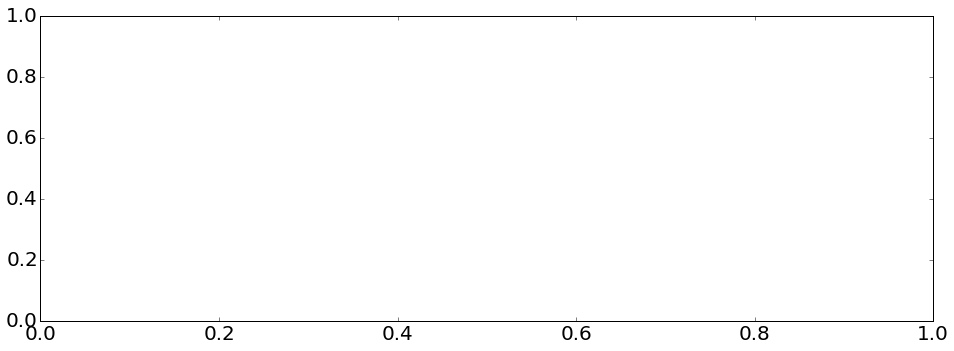

In [82]:

smooth =4

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_income>0)&(df_m.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_m[((df_m.yearly_income>0)&(df_m.yearly_income<rev_max)) & 
                             (df_m.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_income>0)&(df_m.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_m[((df_m.yearly_income>0)&
                                 (df_m.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax1.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax1.grid()
ax1.set_xlim([0,100000])
ax1.set_title("Households")
ax1_2 = ax1.twinx()
ax1_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax1_2.set_ylim(0,1)
ax1.set_xlim(0,70000)



ax3 = plt.subplot2grid((2,2), (1,0), colspan=1)


plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df[((df.yearly_income>0)&(df.yearly_income<rev_max)) & 
                             (df.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df[((df.yearly_income>0)&
                                 (df.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax3.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax3.grid()
ax3_2 = ax3.twinx()
ax3_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax3_2.set_ylim(0,1)

ax3.set_xlim([0,75000])
ax3.set_title("Individuals")


ax2 = plt.subplot2grid((2,2), (1,1), colspan=1)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_income>0)&(df_f.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_income>0)&(df_f.yearly_income<rev_max)) & 
                             (df_f.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_income>0)&(df_f.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_income>0)&
                                 (df_f.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax2_2.set_ylim(0,1)

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")


RSa mensualisé : 

In [ ]:
#fig, axe = plt.subplots(6,2,figsize=(20, 20))
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#for month in range(1,13):
#    i = (month-1)//2 ; j= (month-1)%2
#    ax = axe[i,j]
#    
#    gain_u = (pd.Series(
#     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
#survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
#        ))
#    gain_m =  (
#        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009") - 
#        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
#    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
#    ax.hist((gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)], bins = 100)
#    #ax.hist((gain_m)[(gain_m!=0)], bins = 1500)
#    #print pd.Series(gain_m)[gain_m!=0].shape
#    ax.set_xlim(-300,300)
#    ax.set_xlabel("equivalent monetary gains in euros ")
#    ax.set_ylabel('frequency')
#    ax.set_title('{}'.format(calendar.month_name[month]), weight = 'bold')
##TODO: problème sur les 3 derniers mois !

In [ ]:
#TODO trouver pourquoi il n'y a pas de différences.
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((((u_ir_m - u_ir_a))!=0) &
                                (np.abs(u_ir_m - u_ir_a))<.00002) ].values
    weight_2 = pd.Series(weight_menages)[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((((u_ir_m - u_ir_a))!=0)
                                        & (np.abs(u_ir_m - u_ir_a)<.00002))]
                                    ,(u_c_ir - u_ir_a)[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))])
                                 ), bins = 140)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[(((u_ir_m - u_ir_a)!=0)&
                                (np.abs(u_ir_m - u_ir_a))<.00002)
                               ].hist(figsize = (25,12), bins=bins,
                                            weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))
                               ].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    #plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

# Numbers and tables

## Welfare section

### Utility

#### Without ES

In [ ]:
print "annual tax: ", simulation.calculate("utility_ir_annuel").sum()
print "monthly tax: ", simulation.calculate("utility_ir_mensuel").sum()
print "monthly c tax: ",simulation.calculate("utility_compensated_ir_mensuel").sum()
print "Vickrey tax: ",simulation.calculate("utility_ir_vickrey_mensuel").sum()

In [ ]:
print "annual tax: ",survey_scenario.compute_aggregate("utility_ir_annuel")
print "monthly tax: ",survey_scenario.compute_aggregate("utility_ir_mensuel")
print "monthly c tax: ",survey_scenario.compute_aggregate("utility_compensated_ir_mensuel")
print "Vickrey tax: ",survey_scenario.compute_aggregate("utility_ir_vickrey_mensuel")

#### With ES

In [ ]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")

In [ ]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

In [ ]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")


In [ ]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

### Graph Olivier

In [101]:
basic_money_metric = (simulation.calculate("inverted_utility_ir_annuel")*weight_menages)

In [102]:
mensuel_money_metric = (simulation.calculate("inverted_utility_ir_mensuel")*weight_menages)
compensated_money_metric = (simulation.calculate("inverted_utility_compensated_ir_mensuel")*weight_menages)
vickrey_money_metric = (simulation.calculate("inverted_utility_ir_vickrey_mensuel")*weight_menages)

In [103]:
print basic_money_metric.sum()
print mensuel_money_metric.sum()
print compensated_money_metric.sum()
print vickrey_money_metric.sum()


1.17159653502e+12
1.17371110486e+12
1.17425804866e+12
1.17724022626e+12


In [104]:
ratio = pd.Series(mensuel_money_metric/basic_money_metric)
ratio_compensated = pd.Series(compensated_money_metric/basic_money_metric)
ratio_vickrey = pd.Series(vickrey_money_metric/basic_money_metric)

(0.98, 1.04)

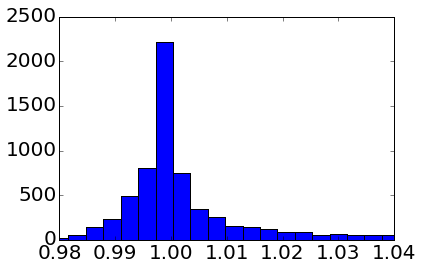

In [105]:
plt.hist(ratio[np.abs(ratio-1) > 0.0002], bins = 2000)
plt.xlim(0.98,1.04)

In [106]:
df0 = pd.DataFrame()

In [107]:
df0['revdisp'] = simulation.calculate('revdisp')

In [108]:
df0.shape

(42709, 1)

In [109]:
df = df0[df0.revdisp>0]

In [110]:
df.shape

(42147, 1)

In [111]:
ratio.shape

(42709,)

In [112]:
ratio[df0.revdisp>0].shape

(42147,)

In [113]:
df0['ratio'] = ratio[df0.revdisp>0]
df0['ratio_compensated'] = ratio_compensated[df0.revdisp>0]
df0["ratio_vickrey"] = ratio_vickrey[df0.revdisp>0]

df['ratio'] = ratio[df0.revdisp>0]
df['ratio_compensated'] = ratio_compensated[df0.revdisp>0]
df["ratio_vickrey"] = ratio_vickrey[df0.revdisp>0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [114]:
df.shape

(42147, 4)

In [115]:
decile_of_disposable_income = df[df.revdisp>0].revdisp.quantile(np.arange(0,1.1,0.1)); print  decile_of_disposable_income
decile_of_disposable_income = np.array(decile_of_disposable_income)

0.0       212.000015
0.1     11948.551172
0.2     16175.014648
0.3     19594.308203
0.4     23299.548047
0.5     27839.919922
0.6     32657.760547
0.7     38018.407812
0.8     45054.846875
0.9     57273.193750
1.0    527534.312500
dtype: float64


In [116]:
decile_of_disposable_income[3]

19594.308203125001

In [117]:
print (df[(df.revdisp >= decile_of_disposable_income[0]) 
   & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05).value_counts()
print (df[(df.revdisp >= decile_of_disposable_income[0]) 
   & (df.revdisp < decile_of_disposable_income[1]) ].ratio<0.95).value_counts()

False    4215
dtype: int64
False    4215
dtype: int64


In [118]:
#(df[(df.revdisp >= decile_of_disposable_income[0]) 
#       & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05)


In [119]:
(df[(df.revdisp >= decile_of_disposable_income[0]) 
       & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05)


1        False
5        False
28       False
51       False
66       False
70       False
115      False
120      False
131      False
136      False
154      False
157      False
159      False
162      False
166      False
175      False
178      False
179      False
182      False
191      False
208      False
209      False
228      False
236      False
261      False
272      False
278      False
294      False
341      False
360      False
365      False
381      False
399      False
423      False
424      False
427      False
434      False
455      False
480      False
482      False
488      False
491      False
496      False
511      False
518      False
526      False
527      False
561      False
575      False
576      False
582      False
595      False
598      False
603      False
609      False
621      False
658      False
683      False
696      False
698      False
700      False
707      False
714      False
721      False
729      False
739      False
742      F

In [120]:
import matplotlib.pyplot as plt

(0.5, 10.5)

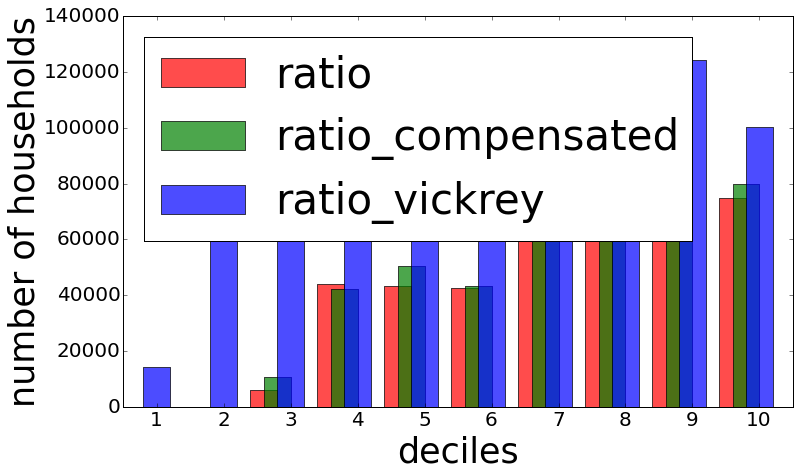

In [121]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    for decile in range(10):
        condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
        condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
        to_plot_array.append(np.sum((df[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))

    hello = ax.bar(0.4+ np.array(range(10))+count/5,to_plot_array,0.4, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households") ; plt.xlabel("deciles") 
plt.xlim((0.5,10.5))


Les gains en money metric sont faible sur les premiers déciles car ils sont peu touchés par l'impôt sur le revenu, et donc un changement de celui-ci a peu d'impact.
Sur les déciles plus élevés ont voir que le gain augmente au fur à mesure que l'on monte dans les déciles. Ce qui semble en opposition avec le fait que les gains monétaires et d'utilités sont principalement du aux plus pauvres. C'est sans oublier que les gains en money metric sont une inversion du gains de la fonction d'utilité, et donc que pour un très riche un tout petit gain d'utilité nécessitera beaucoup d'argent, se traduisant par un gros gain en money metric ; tandis qu'un pauvre pourra avoir un gros gain d'utilité avec très peu d'argent (une réforme impliquant le passage de zéro à 1 euro de revenu disponible fait un gain infini d'utilité, mais impliquerait un gain en money metric d'uniquement 1 euros).

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


(0.5, 10.5)

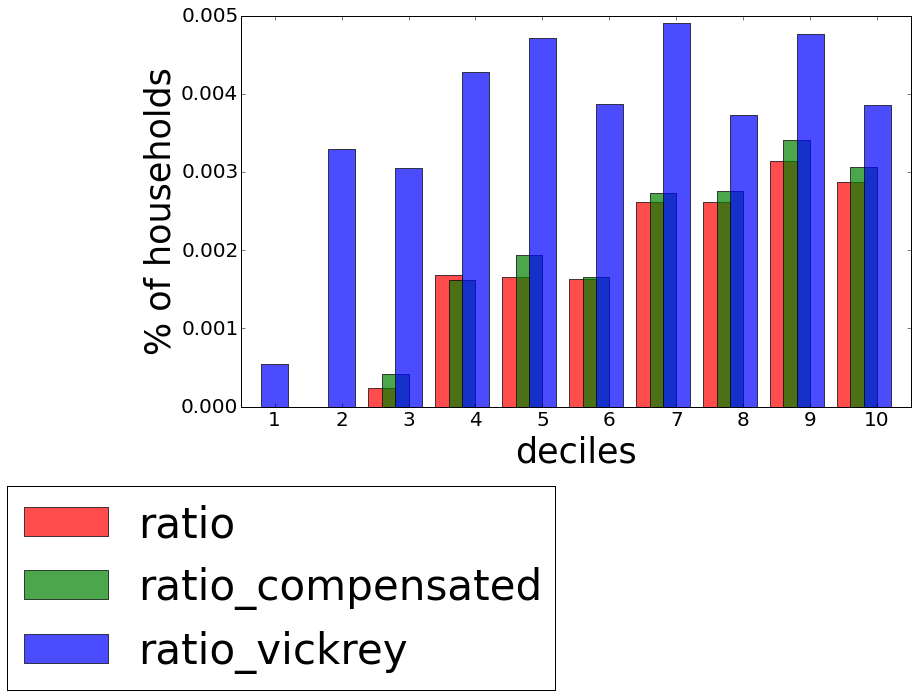

In [122]:
# En poucentage

count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    for decile in range(10):
        condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
        condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
        to_plot_array.append(np.sum((df[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))

    hello = ax.bar(0.4+ np.array(range(10))+count/5,(to_plot_array/np.sum(weight_menages[condition])),0.4, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(bbox_to_anchor=(0.5, -0.15) ,loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel(u"% of households") ; plt.xlabel("deciles") 
plt.xlim((0.5,10.5))


In [123]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

[0.0, 1159.1365966796875, 597.26507568359375, 6684.944580078125, 13058.72119140625, 14683.872009277344, 8916.2086791992188, 15304.732727050781, 14291.594329833984, 30833.624114990234]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[3372.7041625976562, 8417.7503662109375, 19938.329803466797, 24160.477645874023, 47835.769302368164, 36775.305358886719, 47962.596038818359, 33955.624298095703, 49090.763305664062, 45421.638854980469]
[     0.           1159.13659668    597.26507568   6684.94458008
  13058.72119141  14683.87200928   8916.2086792   15304.73272705
  14291.59432983  30833.62411499]
[3801.8501586914062, 46397.908897399902, 47180.989959716797, 65383.564651489258, 88722.617645263672, 65603.298736572266, 77381.955368041992, 66582.518569946289, 84755.598083496094, 68436.252502441406]
[  3372.7041626    9576.88696289  20535.59487915  30845.42222595
  60894.49049377  51459.17736816  56878.80471802  49260.35702515
  63382.3576355   76255.26296997]
[14107.253143310547, 85954.552040100098, 794

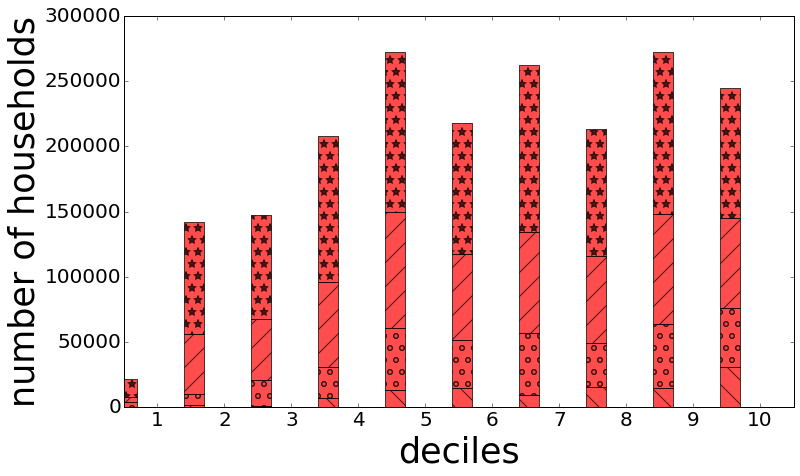

In [124]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
to_plot_array = None

last_plot_array = np.zeros(10) 
for taux in [1.5, 1.2, 1.1, 1.05]:
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"o" , 1.5 : "\\"}
    count1 = 0


    count0 = 0
    for var in ["ratio_vickrey"]:#,"ratio_compensated","ratio_vickrey"]:
        to_plot_array = list()
        for decile in range(10):
            condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
            condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
            to_plot_array.append(np.sum((df[condition ][var]>taux)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
        #print count

        to_plot_np_array = np.array(to_plot_array)
        #last_plot_array = to_plot_np_array last_plot_array
        print to_plot_array
        print last_plot_array
        hello = ax.bar(0.4+ np.array(range(10))+count0/5,to_plot_np_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux], bottom=last_plot_array)
        last_plot_array = to_plot_np_array + last_plot_array
        
        count0 +=1
        
    count1 += 1
    #plt.legend(loc = 0)
    plt.xticks(np.arange(0,11, 1.0)) 
    plt.yticks()
    plt.ylabel("number of households") ; plt.xlabel("deciles") 
    plt.xlim((0.5,10.5))

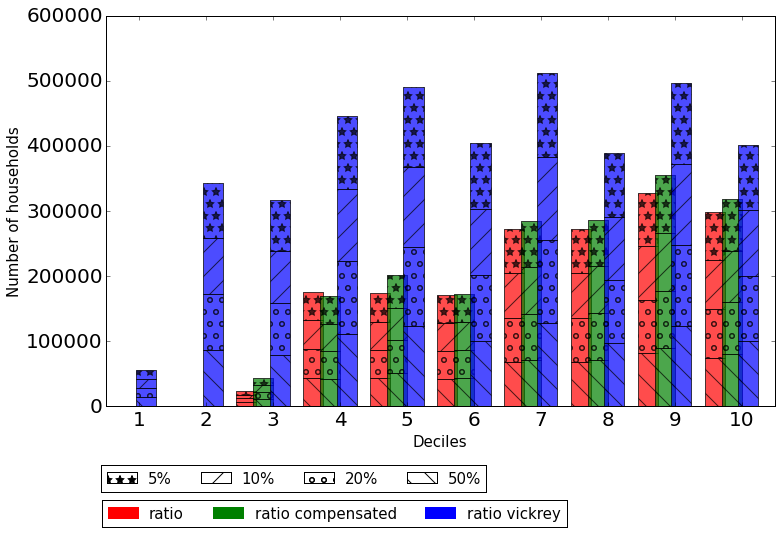

In [125]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
to_plot_array = None


count0 = 0
for var in ["ratio","ratio_compensated","ratio_vickrey"]:#,"ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    for decile in range(10):
        condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
        condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
        to_plot_array.append(np.sum((df[condition ][var]>taux)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))

    last_plot_array = np.zeros(10) 
    for taux in [1.5, 1.2, 1.1, 1.05]:
        hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"o" , 1.5 : "\\"}
        count1 = 0




        to_plot_np_array = np.array(to_plot_array)
        hello = ax.bar(0.45+ np.array(range(10))+count0/4,to_plot_np_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux], bottom=last_plot_array)
        last_plot_array = to_plot_np_array + last_plot_array
        
        count1 +=1
        
    count0 += 1
    #plt.legend(loc = 0)
    plt.xticks(np.arange(0,11, 1.0)) 
    plt.yticks()
    plt.ylabel("Number of households",  fontsize=15) ; plt.xlabel("Deciles",  fontsize=15) 
    plt.xlim((0.5,10.5))


near_patch = Patch(facecolor='w', 
                   label='5%', hatch ='*')
near_patch2 = Patch(facecolor='w', 
                   label='10%', hatch ='/')
near_patch3 = Patch(facecolor='w', 
                   label='20%', hatch ='o')
near_patch4 = Patch(facecolor='w', 
                   label='50%', hatch ='\\')

legend_1 = ax.legend(bbox_to_anchor=(0.58, -0.13),handles=[near_patch, near_patch2, near_patch3, near_patch4], ncol = 4, fontsize=15 )
plt.gca().add_artist(legend_1)

red_patch = mpatches.Patch(color='red', label='ratio')
green_patch = mpatches.Patch(color='green', label='ratio compensated')
blue_patch = mpatches.Patch(color='blue', label='ratio vickrey')
color_legend = ax.legend(bbox_to_anchor=(0.70, -0.22),handles=[red_patch, green_patch, blue_patch], ncol = 4,  fontsize=15)



In [126]:
[near_patch, near_patch2]

In [127]:
near_patch

In [128]:
to_plot_array

[14107.253143310547,
 85954.552040100098,
 79414.131271362305,
 111457.03330993652,
 122768.20042419434,
 101005.63185119629,
 127913.52827453613,
 97178.711441040039,
 124169.19270324707,
 100405.41775512695]

In [129]:
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"x" , 1.5 : "\\"}

In [130]:
{16 : 'hello', 18 :"goodbye"}

{16: 'hello', 18: 'goodbye'}

In [131]:
salaire_not_null = (pd.Series(simulation.calculate_add("rev_sal"))>0); print salaire_not_null.value_counts()
chomage_not_null = (pd.Series(simulation.calculate_add("chomage_imposable"))>0); print chomage_not_null.value_counts()
retraite_not_null = (pd.Series(simulation.calculate_add("retraite_imposable"))>0); retraite_not_null.value_counts()

True     42639
False    37792
dtype: int64
False    73519
True      6912
dtype: int64


False    55394
True     25037
dtype: int64

In [132]:
print weight_individus.shape
print weight_foyers.shape
print weight_familles.shape
print weight_menages.shape

(80431,)
(52189,)
(48195,)
(42709,)


In [133]:
passage_retraite = salaire_not_null & retraite_not_null ; print passage_retraite.value_counts()
passage_chomage = salaire_not_null & chomage_not_null ; print passage_chomage.value_counts()
passage_cho_ret_emp = salaire_not_null & retraite_not_null & chomage_not_null ; print passage_cho_ret_emp.value_counts()
passage_cho_ret = retraite_not_null & chomage_not_null ; print passage_cho_ret.value_counts()


False    77501
True      2930
dtype: int64
False    73519
True      6912
dtype: int64
False    79846
True       585
dtype: int64
False    79846
True       585
dtype: int64


In [134]:
changement_situation = retraite_not_null & chomage_not_null

In [135]:
df0['passage_retraite'] = sum_array_by_entity(passage_retraite,  'menage')
df0['passage_chomage'] = sum_array_by_entity(passage_chomage,  'menage')
#df0['passage_retraite'] = passage_retraite
#df0['passage_chomage'] = passage_chomage


/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


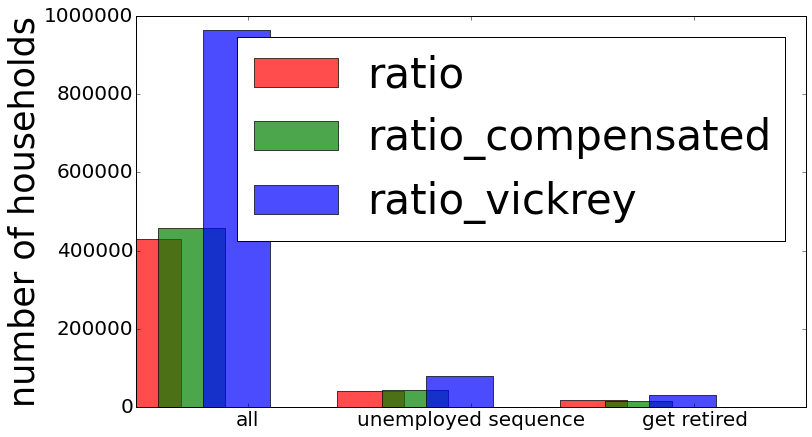

In [136]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = passage_chomage & (df0.revdisp >0)
    condition0 = passage_chomage & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    condition = passage_retraite
    condition0 = passage_retraite
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    

    hello = ax.bar(0.4+ np.array(range(3))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired'))


(3676, 6)
(80431,)
(3676, 6)
(80431,)
(3676, 6)
(80431,)


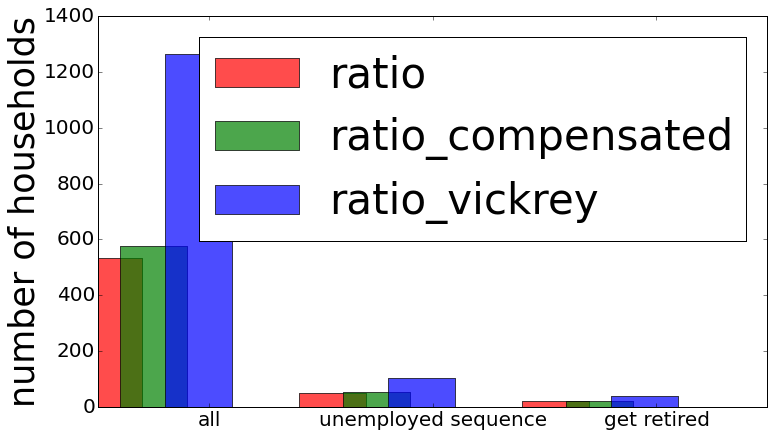

In [137]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)))
    
    condition = passage_chomage & (df0.revdisp >0)
    condition0 = passage_chomage & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)))
    print df0[condition].shape ; print condition.shape
    condition = passage_retraite
    condition0 = passage_retraite
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)))
    

    hello = ax.bar(0.4+ np.array(range(3))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")
plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired'))


17% du sample à un ratio différent de 1 soit 7309 personnes sur 42709 ; parmis eux 952 ont eu un passage à la retraite dans le ménage (33% des ménages ayant eu un passage à la retraite), et 622 un pagge au chomage(17%).

In [138]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio != 1).value_counts()
print pd.Series(ratio != 1)[passage_retraite].value_counts()
print pd.Series(ratio != 1)[passage_chomage].value_counts()
print 952+622

(42709,)
(42709,)
False    35400
True      7309
dtype: int64
False    1286
True      245
dtype: int64
False    3102
True      622
dtype: int64
1574


In [139]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio != 1).value_counts(normalize = True)
print pd.Series(ratio != 1)[passage_retraite].value_counts(normalize = True)
print pd.Series(ratio != 1)[passage_chomage].value_counts(normalize = True)

(42709,)
(42709,)
False    0.828865
True     0.171135
dtype: float64
False    0.839974
True     0.160026
dtype: float64
False    0.832975
True     0.167025
dtype: float64


In [140]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio > 1.002).value_counts()
print pd.Series(ratio > 1.002)[passage_retraite].value_counts()
print pd.Series(ratio > 1.002)[passage_chomage].value_counts()
print 952+622

(42709,)
(42709,)
False    40377
True      2332
dtype: int64
False    1453
True       78
dtype: int64
False    3513
True      211
dtype: int64
1574


In [141]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio > 1.05).value_counts()
print pd.Series(ratio > 1.05)[passage_retraite].value_counts()
print pd.Series(ratio > 1.05)[passage_chomage].value_counts()
print 

(42709,)
(42709,)
False    42175
True       534
dtype: int64
False    1511
True       20
dtype: int64
False    3675
True       49
dtype: int64



In [142]:
Series_list = [simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month)) for month in range(1,13)]

In [143]:
coucou = pd.DataFrame(Series_list).T

In [144]:
coucou.T*weight_menages

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,42609,42610,42611,42612,42613,42614,42615,42616,42617,42618,42619,42620,42621,42622,42623,42624,42625,42626,42627,42628,42629,42630,42631,42632,42633,42634,42635,42636,42637,42638,42639,42640,42641,42642,42643,42644,42645,42646,42647,42648,42649,42650,42651,42652,42653,42654,42655,42656,42657,42658,42659,42660,42661,42662,42663,42664,42665,42666,42667,42668,42669,42670,42671,42672,42673,42674,42675,42676,42677,42678,42679,42680,42681,42682,42683,42684,42685,42686,42687,42688,42689,42690,42691,42692,42693,42694,42695,42696,42697,42698,42699,42700,42701,42702,42703,42704,42705,42706,42707,42708
0,1886228.302034,556414.251831,603497.530791,3196508.954588,5533199.997952,539077.577425,1446192.692901,465695.005743,7763091.65231,2766333.244542,1843282.178044,1224446.095352,745222.5345,1325897.10785,1602845.039929,-0.000000,812675.358455,2844201.604551,792803.837322,1250275.999807,1085539.364429,665929.576907,1550608.387876,1569409.110122,7213095.477008,2959817.6899,6825500.207960,2128248.053344,734160.959437,-0,1017979.516334,810051.949209,684157.812881,1118231.296052,1027882.259001,1175769.98949,1295201.950249,1048217.873854,1260230.406465,1800703.868518,2093184.953433,2677539.430927,807655.680898,5524479.562284,1132807.160631,904927.373263,571928.732621,1804265.897415,6293392.435627,2122131.79819,1902258.600533,302497.920782,441583.775467,4302282.665030,1357577.342635,-0,1712205.95534,2362980.711363,1802198.964898,674404.354622,842145.985776,1789113.524554,850989.289192,5222528.970583,1938300.453907,2246099.239354,425479.841248,1382098.99017,281642.283869,-0,326615.057796,1299949.667876,809646.315209,4031642.649829,836804.79627,1218289.429945,804842.751170,1294625.583215,4880090.063534,2866301.27216,7276571.049303,5859111.211564,867238.535997,1593336.107415,3557436.140988,1948281.568628,-0,570053.050682,902528.711149,1261851.44577,942200.281581,1061167.192809,1080080.119565,366263.232449,2006576.93651,1919535.746463,1210150.682729,5100347.043363,4152268.517499,704813.468287,...,284838.295635,14361083.223458,2037763.785139,1588499.611382,241029.978202,179677.544763,754207.678615,8816421.508579,2554746.062994,68056.074367,2059923.58689,2144176.662335,228768.355846,3940665.972873,1446071.298513,725659.806254,6514101.912629,2634632.113168,0,1311999.859413,2869631.362571,255669.220475,695538.080039,3981670.100167,2565248.233653,2925620.576587,1689875.17253,837832.872834,454091.397117,1428660.112746,6953279.175692,0,954649.905017,4197284.836171,-0,1342836.497779,2589389.708579,1616384.471061,447192.687944,4288119.233555,5282649.915584,446593.417697,2079645.116818,1335662.055422,1894133.292495,1071508.964577,834765.347737,1861229.871895,872930.187161,4066508.657742,2056178.877771,1254468.027431,2420693.596182,771516.43957,2622878.757649,4266371.904385,2339256.609298,1425916.528477,2951185.262764,3751525.179904,600449.599661,607489.523611,0,657823.709169,3099970.908108,497496.667458,1095138.101495,1757024.353002,357656.095147,968862.555175,1602527.313477,0,1811479.120652,1459600.491846,1601612.952948,1493385.197487,1516989.598888,4202561.895212,2908686.943959,4557391.979738,904917.357641,831903.787377,1308347.748733,4011526.449926,1937224.656620,861271.592858,4360812.424347,628006.394627,215676.193309,1135654.657959,4764024.018662,1646499.622024,728524.348236,-0.000000,1506040.201232,5306530.862842,3936635.033356,1016440.082724,1326842.715851,136263.720410
1,1856796.958083,556414.251831,603497.530791,2516443.551379,5533199.997952,539077.577425,975761.708699,480011.895505,7763091.65231,2766339.565424,1843282.178044,1224446.095352,745222.5345,1325897.10785,1602845.039929,-0.000000,812675.358455,2844201.604551,649787.656563,1312914.312975,1085539.364429

In [145]:
(pd.Series(simulation.calculate("revdisp")*weight_menages).sum()- (coucou.T*weight_menages).sum(1).sum())/10**9

63.826955910102662

In [146]:
print pd.Series(simulation.calculate("revdisp")*weight_menages).sum()/10**9
print (coucou.T*weight_menages).sum(1).sum()/10**9

1064.14829481
1000.3213389


In [147]:
to_plot_array

[1264, 105, 39]

In [148]:
(df0.revdisp>5500).value_counts()

True     41743
False      966
dtype: int64

In [149]:
2700*0.3 + 6000*0.14

1650.0

In [150]:
passage_retraite.value_counts()

False    77501
True      2930
dtype: int64

In [151]:
print df0.passage_chomage.value_counts(normalize=True)
print df0.passage_retraite.value_counts(normalize=True)
print df0.passage_chomage.value_counts()
print df0.passage_retraite.value_counts()

0    0.851928
1    0.134749
2    0.012948
3    0.000304
4    0.000070
dtype: float64
0    0.934229
1    0.062961
2    0.002786
3    0.000023
dtype: float64
0    36385
1     5755
2      553
3       13
4        3
dtype: int64
0    39900
1     2689
2      119
3        1
dtype: int64


In [152]:
passage_retraite = df0.passage_retraite.astype("bool")

print (ratio[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_compensated[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_vickrey[passage_retraite] != 1).value_counts(normalize =True)

False    0.661089
True     0.338911
dtype: float64
False    0.735493
True     0.264507
dtype: float64
False    0.677109
True     0.322891
dtype: float64


In [153]:
passage_chomage = df0.passage_retraite.astype("bool")

print (ratio[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_compensated[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_vickrey[passage_retraite] != 1).value_counts(normalize =True)

False    0.661089
True     0.338911
dtype: float64
False    0.735493
True     0.264507
dtype: float64
False    0.677109
True     0.322891
dtype: float64


In [154]:
df = pd.DataFrame()

In [155]:
#no_income_on_one_month

array = np.zeros(simulation.calculate("salaire_imposable").shape)
for month in range(1,13):

        retraite = pd.Series(simulation.calculate_add('retraite_imposable', '2009-{}'.format(month))==0)
        chomage = pd.Series(simulation.calculate_add('chomage_imposable', '2009-{}'.format(month))==0)
        salaire = pd.Series(simulation.calculate_add("salaire_imposable", '2009-{}'.format(month))==0)
        
        array += retraite & chomage & salaire







In [156]:
pd.Series(array).value_counts()

0     59336
12    15685
11      748
1       716
3       581
2       515
9       482
8       462
6       451
4       389
10      368
5       357
7       341
dtype: int64

In [157]:
pd.Series(array).value_counts()

0     59336
12    15685
11      748
1       716
3       581
2       515
9       482
8       462
6       451
4       389
10      368
5       357
7       341
dtype: int64

In [158]:
# salaire_imposable_all_year

salaire = np.zeros(simulation.calculate("salaire_imposable").shape)
for month in range(1,13):
        salaire += (pd.Series(simulation.calculate("salaire_imposable", '2009-{}'.format(month)))>0)
# salaire_imposable_all_year

chomage = np.zeros(simulation.calculate("chomage_imposable").shape)
for month in range(1,13):
        chomage += (pd.Series(simulation.calculate("chomage_imposable", '2009-{}'.format(month)))>0)
retraite = np.zeros(simulation.calculate("retraite_imposable").shape)
for month in range(1,13):
        retraite += (pd.Series(simulation.calculate("retraite_imposable", '2009-{}'.format(month)))>0)
        
        

In [159]:
pd.Series(salaire).value_counts()

0     39457
12    34715
9       724
11      676
6       655
10      651
4       593
3       561
7       535
8       532
2       460
5       443
1       429
dtype: int64

In [160]:
pd.Series(retraite).value_counts()

0     55394
12    22403
1       592
3       287
4       247
11      216
2       206
9       197
8       191
5       184
6       175
7       174
10      165
dtype: int64

In [161]:
pd.Series(chomage).value_counts()

0     73519
12     3320
3       431
5       384
2       370
6       364
4       360
8       340
9       315
1       310
7       290
10      238
11      190
dtype: int64

In [162]:
(pd.Series(simulation.calculate_add('salaire_imposable'))>0).value_counts()

True     40974
False    39457
dtype: int64

In [163]:
pd.Series(array).value_counts()

0     59336
12    15685
11      748
1       716
3       581
2       515
9       482
8       462
6       451
4       389
10      368
5       357
7       341
dtype: int64

# End selected for article

In [101]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    #print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

KeyError: 'inverted_utility_compenstaed_ir_mensuel_rsa_mensuel'

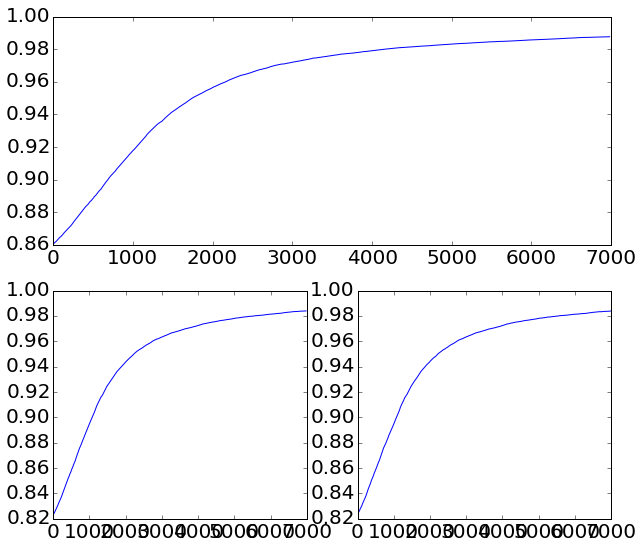

In [102]:
fig = plt.figure(figsize=(10, 9))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

ax1.plot(range_to_use,income_rep_func)




ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
ax2.plot(range_to_use,income_rep_func_f)
ax3 = plt.subplot2grid((2,2), (1,1), colspan=2)
ax3.plot(range_to_use,income_rep_func_m)


In [103]:
sum_array_by_entity(month_income, 'menage')

array([ 2260.33325195,    17.66666603,  2789.58337402, ...,  2259.91674805,
        1602.41662598,    84.        ])

In [104]:
sum_array_by_entity(month_income, 'menage')

array([ 2260.33325195,    17.66666603,  2789.58337402, ...,  2259.91674805,
        1602.41662598,    84.        ])

(<matplotlib.figure.Figure at 0x1b1acdf50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ae13ea10>)

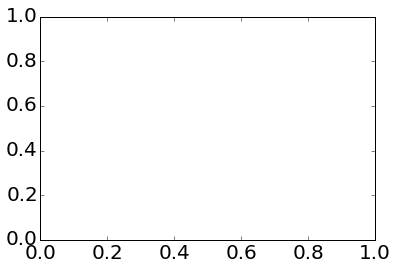

In [105]:
plt.subplots()

In [106]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    42146
1     5914
2      135
dtype: int64


##### weights

In [107]:
weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)

In [108]:
print weight_foyers.shape , "foyers fiscaux"
print weight_menages.shape , "ménages"
print weight_familles.shape, "familles"
print weight_individus.shape, "individus"

(52189,) foyers fiscaux
(42709,) ménages
(48195,) familles
(80431,) individus


In [109]:
print weight_foyers.sum() , "foyers fiscaux"
print weight_menages.sum() , "ménages"
print weight_familles.sum(), "familles"
print weight_individus.sum(), "individus"

40879387.8617 foyers fiscaux
33576064.6928 ménages
37434879.1817 familles
61267045.2607 individus


In [110]:
variable = 'revdisp_mensuel_ir_mensuel'
monthly_df = pd.DataFrame(
                dict((column_name+"_"+period, survey_scenario.simulation.calculate_add(column_name, period)) 
                for period in ['{}-{}'.format( 2009, str(month).zfill(2)) for month in range(1, 13)] for column_name in [variable]) #TODO mensualize : allow for periods
                )
#monthly_df.T

In [111]:
#monthly_df.T
monthly_df['revdisp_mensuel_ir_mensuel_2009-09'].mean()

2474.4233

In [112]:
survey_scenario.compute_aggregate('revdisp_mensuel_annuel')/27000000

36996.511532579068

In [113]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

36830.347051674471

In [114]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

36830.347051674471

#### Pourcentage du sample entre -20 et 20

In [115]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)>70].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda supérieur  à 70 ".format(round(prct1,2)*100)

1.0 % du sample à un lambda supérieur  à 70 


#### Lambda compensation négatif du à la décote ?

In [116]:
pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12).mean()

162.66545

In [117]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add("decote"))

In [118]:
filtre_unequal_decote = decote_monthly != decote_annual

In [119]:
lambda_compensation[filtre_unequal_decote].shape

(16114,)

(-20, 20)

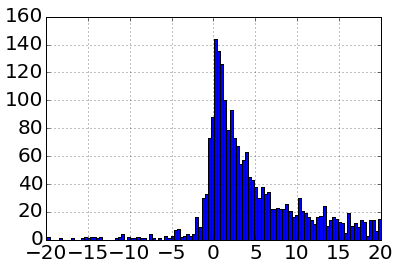

In [120]:
lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)].hist(bins = 500)
plt.xlim(-20,20)

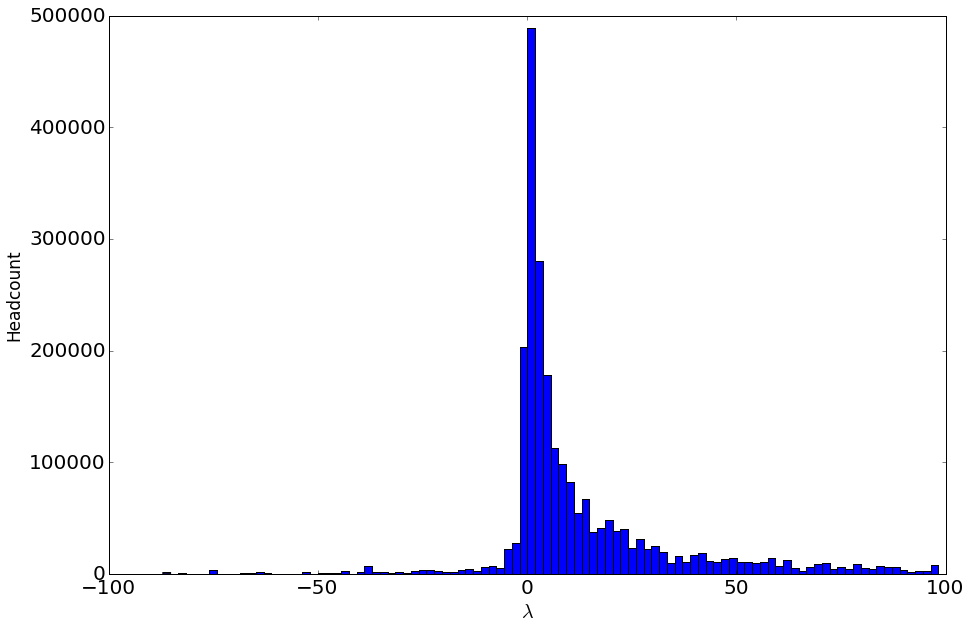

In [121]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1) & (np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[graph_filter]
poids = pd.Series(weight_foyers)[graph_filter]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

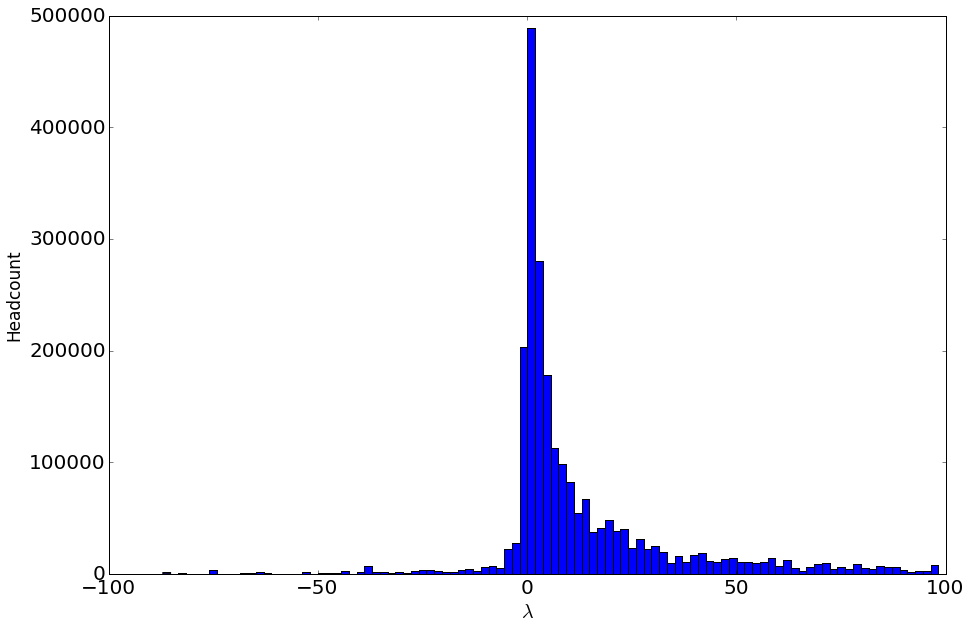

In [122]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]
poids = pd.Series(weight_foyers)[
        filtre_unequal_decote&
        (np.abs(lambda_compensation)>.1)&
        (np.abs(lambda_compensation)<100)]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [123]:
#weights = np.ones_like(myarray)/float()


AttributeError: 'numpy.ndarray' object has no attribute 'values'

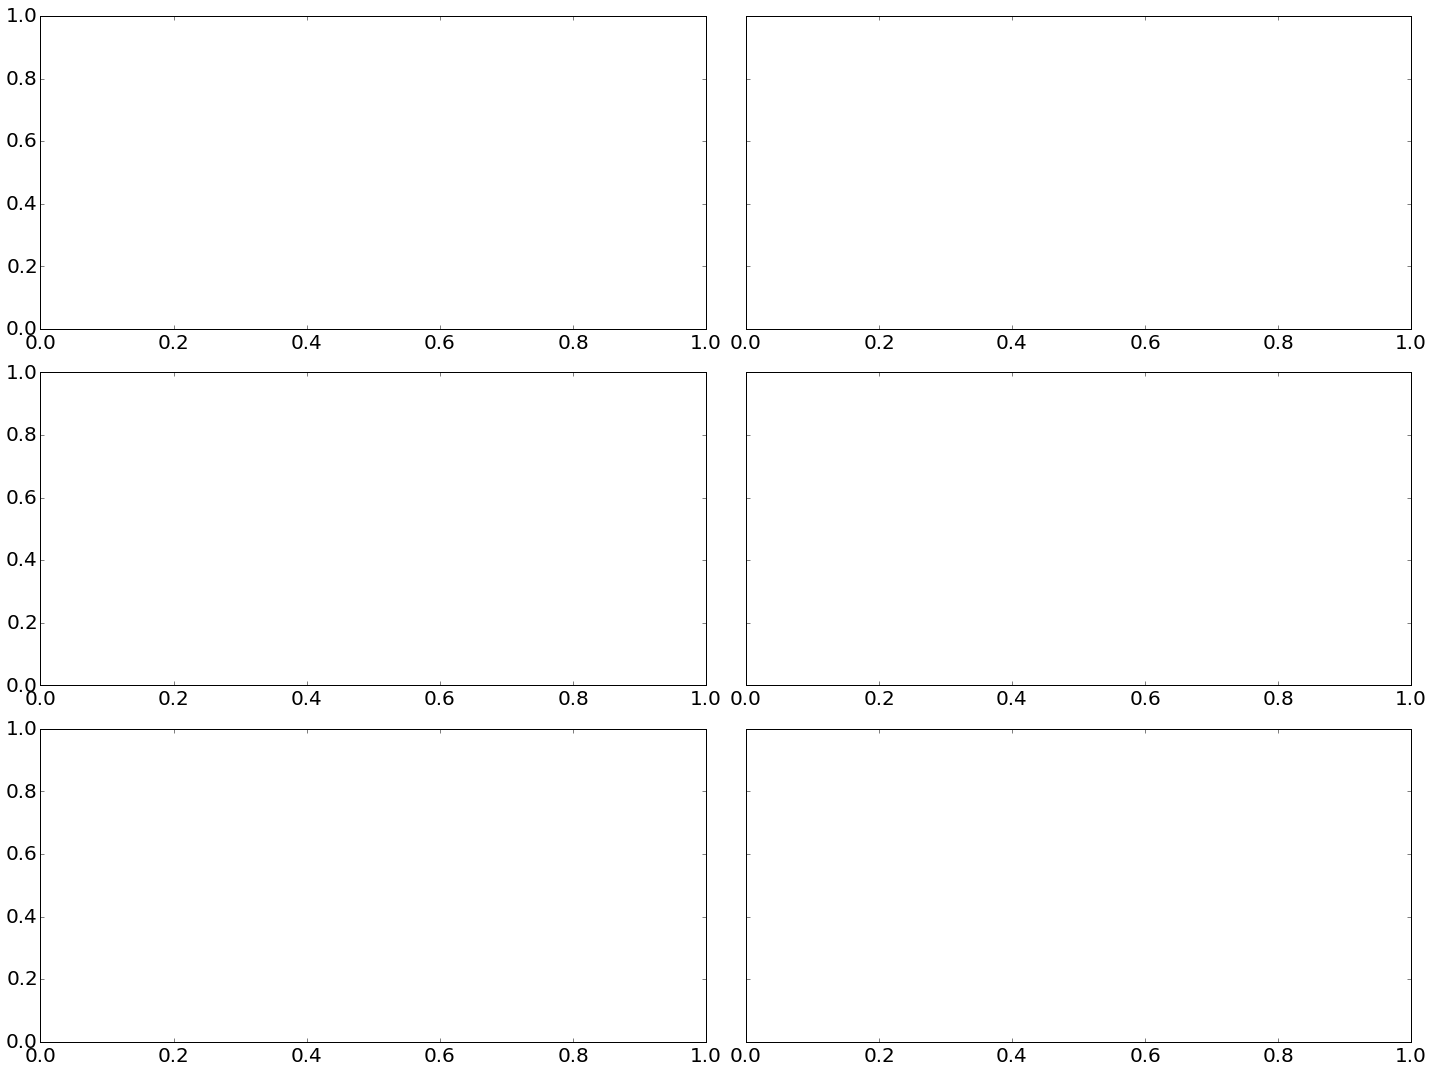

In [126]:
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter].values, bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [127]:
lambda_compensation_menage = pd.Series(switch_entity('lambda_compensation', 'menage'))
graph_filter_menage =  (np.abs(lambda_compensation_menage)>.1)&(np.abs(lambda_compensation_menage)<100)

In [128]:
to_graph_foyer = lambda_compensation[graph_filter]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

AttributeError: 'numpy.ndarray' object has no attribute 'values'

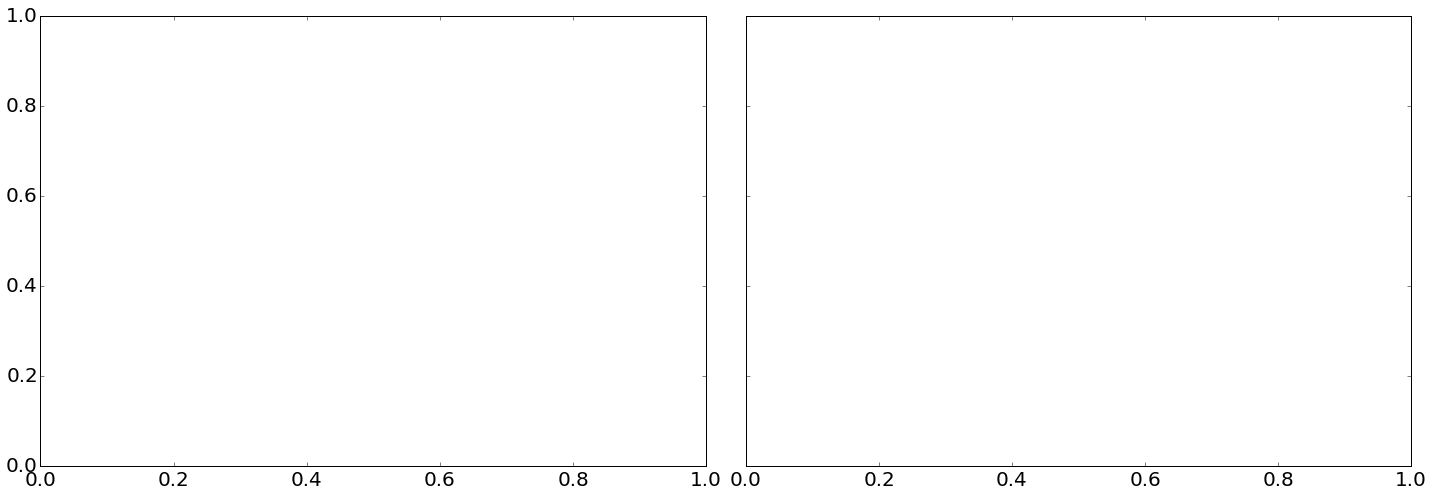

In [129]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]


ax[0].hist(to_graph_foyer.values, bins = 100, weights = poids.values)
ax[0].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[0].set_ylabel('Headcount',fontsize = 17)
ax[0].set_title('Fiscal Household')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].grid(which = 'both')



ax[1].hist(to_graph_menage.values, bins = 100, weights = poids_menage.values)
ax[1].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[1].set_title('Household')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].grid(which = 'both')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

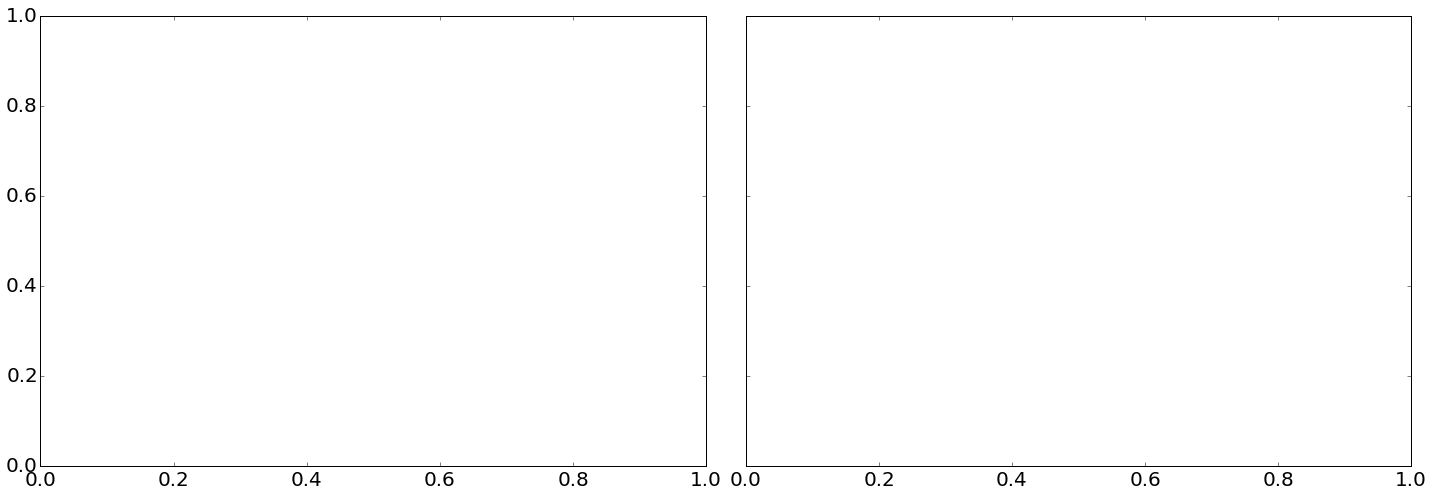

In [130]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]
ax_nb = 0
ax[ax_nb].hist(to_graph_foyer.values, bins = 100,normed = True, weights = poids.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[ax_nb].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Fiscal Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')


ax_nb = 1
ax[ax_nb].hist(to_graph_menage.values, bins = 100, normed = True ,weights = poids_menage.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')

In [131]:
index_exceptional_lambda = lambda_compensation[np.abs(lambda_compensation)>100].index

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [132]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df['decote_gain_fiscal_mensuel'] = df.decote_gain_fiscal_mensuel_times_12/12
df.iloc[index_exceptional_lambda]

NameError: name 'index_exceptional_lambda' is not defined

In [133]:
survey_scenario.simulation.calculate("irpp_mensuel","2009-08")[4]

-196.90581

In [134]:
df["difference"] = np.abs(df.decote_gain_fiscal- df.decote_gain_fiscal_mensuel)>0.01
df[lambda_compensation == -12].difference.value_counts()

Series([], dtype: int64)

In [135]:
df.shape

(52189, 7)

In [136]:
df[lambda_compensation == -12][['decote_gain_fiscal', 'decote_gain_fiscal_mensuel', 'lambda_compensation',"irpp",'irpp_mensuel' ]]

,decote_gain_fiscal,decote_gain_fiscal_mensuel,lambda_compensation,irpp,irpp_mensuel


In [137]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
df.lambda_compensation[df.lambda_compensation< -70] = 0

In [138]:
df[np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)+1>0].shape

(52189, 5)

(-20, 20)

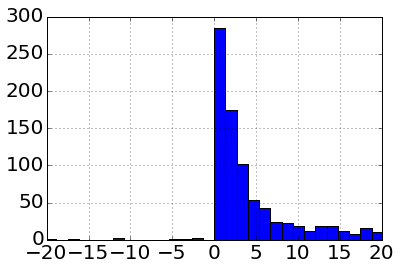

In [139]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-1<0)
                      & (np.abs(df.lambda_compensation)>0.1)].hist(bins = 100)
plt.xlim(-20,20)

In [140]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)].mean()

9.1103029

In [141]:
df[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
4,222.450867,0.000000,-198.647400,-984.529053,47.473965
8,102.428314,50.640320,153.500000,-124.341667,-21.720520
50,-0.000000,99.622520,-975.020630,-1119.121704,1.773515
65,16.179199,0.000000,-817.462402,-5112.797852,63.053696
133,221.758743,56.897495,-131.223770,-364.255066,21.309975
146,42.919189,0.000000,-737.242432,-1047.363403,5.047800
152,160.924164,81.883415,-383.227509,-470.173218,2.722530
188,142.412506,0.000000,-393.762482,-804.537537,12.518461
190,201.789124,0.000000,-260.632629,-1085.869385,37.995399
191,-0.000000,61.431255,-2300.627197,-2342.895508,0.220470


In [142]:
df[df.lambda_compensation<-1]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
8,102.428314,50.640320,153.500000,-124.341667,-21.720520
1391,287.512512,63.286880,280.500000,-179.139389,-19.663717
1587,98.505005,10.954166,658.315063,422.085144,-4.306083
2120,278.608124,199.355637,116.824371,-28.473122,-14.924710
2605,3.882507,164.979385,-854.352478,-693.255432,-2.262725
3231,171.357574,0.000000,88.072723,-303.172577,-53.307575
3321,175.911713,1.549131,1230.935181,-370.053955,-15.607540
3533,-0.000000,0.000000,42.001831,-120.870804,-46.533012
3826,125.595215,0.000000,103.185669,-352.241028,-52.963951
3898,77.015015,75.863335,192.045044,-23.080063,-13.442165


In [143]:
df[df.lambda_compensation<-1][df.decote_gain_fiscal> df.decote_gain_fiscal_mensuel_times_12]

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
8,102.428314,50.640320,153.500000,-124.341667,-21.720520
1391,287.512512,63.286880,280.500000,-179.139389,-19.663717
1587,98.505005,10.954166,658.315063,422.085144,-4.306083
2120,278.608124,199.355637,116.824371,-28.473122,-14.924710
3231,171.357574,0.000000,88.072723,-303.172577,-53.307575
3321,175.911713,1.549131,1230.935181,-370.053955,-15.607540
3826,125.595215,0.000000,103.185669,-352.241028,-52.963951
3898,77.015015,75.863335,192.045044,-23.080063,-13.442165
6109,182.027008,118.143959,423.500000,272.765259,-4.271114
6852,265.434448,250.735855,37.500000,-4.125753,-13.320241


## Compensated irpp

In [149]:
print max(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  
                    survey_scenario.simulation.calculate_add('irpp')))
print min(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  
                    survey_scenario.simulation.calculate_add('irpp')))

0.09375
-0.046875


In [145]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
0,0.000000,-0.000000,21.742493,0.000000,21.742470,0.000000e+00
1,0.000000,0.000000,77.137505,0.000000,-0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
3,-1378.829956,-0.000000,-0.000000,-1378.829956,-1378.829956,0.000000e+00
4,-198.647400,222.450867,0.000000,-198.647400,-984.529053,4.747396e+01
5,-792.612549,24.462494,24.462494,-792.612549,-792.612366,-2.861023e-06
6,-11461.149414,-0.000000,-0.000000,-11461.150391,-11461.149414,-9.536743e-07
7,0.000000,102.015839,155.870041,0.000000,-0.000000,0.000000e+00
8,153.500031,102.428314,50.640320,153.500000,-124.341667,-2.172052e+01
9,-2104.827637,-0.000000,-0.000000,-2104.827637,-2104.827881,9.536743e-07


In [146]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
0,0.000000,-0.000000,21.742493,0.000000,21.742470,0.000000e+00
1,0.000000,0.000000,77.137505,0.000000,-0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
3,-1378.829956,-0.000000,-0.000000,-1378.829956,-1378.829956,0.000000e+00
4,-198.647400,222.450867,0.000000,-198.647400,-984.529053,4.747396e+01
5,-792.612549,24.462494,24.462494,-792.612549,-792.612366,-2.861023e-06
6,-11461.149414,-0.000000,-0.000000,-11461.150391,-11461.149414,-9.536743e-07
7,0.000000,102.015839,155.870041,0.000000,-0.000000,0.000000e+00
8,153.500031,102.428314,50.640320,153.500000,-124.341667,-2.172052e+01
9,-2104.827637,-0.000000,-0.000000,-2104.827637,-2104.827881,9.536743e-07


In [147]:
df[df.compensated_irpp_mensuel - df.irpp<2][['irpp', 'compensated_irpp_mensuel', 'irpp_mensuel']]

,irpp,compensated_irpp_mensuel,irpp_mensuel
0,0.000000,0.000000,21.742470
1,0.000000,0.000000,-0.000000
2,0.000000,0.000000,-0.000000
3,-1378.829956,-1378.829956,-1378.829956
4,-198.647400,-198.647400,-984.529053
5,-792.612549,-792.612549,-792.612366
6,-11461.150391,-11461.149414,-11461.149414
7,0.000000,0.000000,-0.000000
8,153.500000,153.500031,-124.341667
9,-2104.827637,-2104.827637,-2104.827881


In [148]:
print survey_scenario.compute_aggregate('compensated_irpp_mensuel')
print survey_scenario.compute_aggregate('irpp')

-67713927388.7
-67713927343.4


In [150]:
impot_mensuel_times_12 = survey_scenario.simulation.calculate("irpp_mensuel", period)*12
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)



compensated_irpp = impot_mensuel_times_12/(12 + lambda_compensation)

In [151]:
compensated_irpp[743]

-0.0

In [152]:
(survey_scenario.simulation.calculate("irpp", period.this_year) == 0)*0

array([0, 0, 0, ..., 0, 0, 0])

In [153]:
compensated_irpp = (survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * 0 + \
                ~(survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * np.nan_to_num(compensated_irpp) ;compensated_irpp[[4,743]]

array([-198.6473999,    0.       ])

In [154]:
compensated_irpp = (
                (survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * #Condition
                (survey_scenario.simulation.calculate("irpp", period.this_year)/12) # on répartit sur l'année
            ) + ~(survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * compensated_irpp #condition opposée
compensated_irpp[[4,743]]

array([-198.6473999,    0.       ])

In [155]:
df[df.lambda_compensation.isnull()]

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation


In [156]:
survey_scenario.simulation.calculate_add('irpp')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [157]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

-67713927388.682755

In [158]:
lambda_compensation = survey_scenario.simulation.calculate('lambda_compensation')
np.all(lambda_compensation != np.nan)
lambda_compensation != np.nan
hello = lambda_compensation[1]
assert np.all(np.isfinite(lambda_compensation))


In [159]:
sal_pen_df = survey_scenario.create_data_frame_by_entity_key_plural_with_monthly_basis_selector(['irpp'], ['irpp_mensuel','compensated_irpp_mensuel'])['foyers_fiscaux']

sal_pen_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,52089,52090,52091,52092,52093,52094,52095,52096,52097,52098,52099,52100,52101,52102,52103,52104,52105,52106,52107,52108,52109,52110,52111,52112,52113,52114,52115,52116,52117,52118,52119,52120,52121,52122,52123,52124,52125,52126,52127,52128,52129,52130,52131,52132,52133,52134,52135,52136,52137,52138,52139,52140,52141,52142,52143,52144,52145,52146,52147,52148,52149,52150,52151,52152,52153,52154,52155,52156,52157,52158,52159,52160,52161,52162,52163,52164,52165,52166,52167,52168,52169,52170,52171,52172,52173,52174,52175,52176,52177,52178,52179,52180,52181,52182,52183,52184,52185,52186,52187,52188
irpp,0.000000,0,0,-1378.829956,-198.647400,-792.612549,-11461.150391,0,153.500000,-2104.827637,0,-693.510254,-5236.649902,-2124.675049,737.799988,0,-1072.574951,-1089.632446,-433.722504,0,0.00000,-1747.150024,0.000000,0,-2433.450195,-79.077515,-5260.950195,-568.148743,-2369.692383,-8168.149902,-7609.375000,0,-700.632507,0,0,0,0,0,-613.062500,-557.202515,-1022.315002,-773.432434,0.00000,-100.775009,0,-1177.890015,0,-1053.290039,-176.052505,-25070.474609,-975.020630,0.000000,-7382.575195,0,-464.382507,-19810.775391,-306.282501,-839.862549,-2150.909912,0,-3082.330078,-1024.975098,221.765015,-781.380005,0,-817.462402,-1687.921509,-2443.070068,-712.655029,-1361.569946,-504.814941,-1770.290039,0.000000,0,-244.102478,-607.182495,-97.092499,-1016.015015,-1271.149902,-203.772522,0,-1550.395020,-320.322510,0,-1681.944946,0,0,0,0,-402.852478,-188.301331,-505.332489,0.000000,-184.677505,-1057.435059,0,-651.175049,229.050049,-30161.775391,-24377.976562,...,-8082.974609,-2030.059570,0,0,-4311.649902,0,0,-138.734985,-1745.834961,-3921.610107,-466.745026,-289.197540,0,0,-1462.055054,-2327.509766,0,0,-295.096985,-2161.594971,-100.692520,0.000000,-601.30249,0.00000,-1093.915039,0,-4020.969971,-1445.371460,0,-1058.574951,-2052.189941,-267.612518,-499.992493,-4005.495117,-319.692505,-563.888794,0,-4398.750000,-2004.694946,-687.770020,-748.354980,-244.002533,-1614.723267,-12232.699219,-1883.630493,0,-1735.875000,-6221.949707,720.532471,0,0,0,0,0,-1870.689941,0,-1313.714966,0,-694.752563,-130.433746,0,-2510.689941,-122.678726,0,-881.647339,0,-1013.950012,0,-2144.870117,-1179.814941,-1893.200195,-820.122437,-15807.650391,-476.045013,0,-994.734985,-1435.175049,-1235.873413,-322.265015,0,0,-2653.750000,0,0,0,0,-15060.699219,-303.522522,0,-7257.799805,-2652.369873,-3179.347412,0.000000,-2050.929932,-199.012421,-1824.655029,0,0.000000,0,0
compensated_irpp_mensuel_2009-01,0.000000,0,0,-114.902504,0.000000,-66.051056,-955.095947,0,-15.791336,-175.402283,0,-57.792530,-436.387512,-177.056259,61.483334,0,-89.381256,-90.802696,-36.143539,0,0.00000,-145.595840,0.000000,0,-202.787506,-6.589793,-438.412476,-47.345730,-197.474365,-680.679138,-634.114563,0,-58.386044,0,0,0,0,0,-51.088543,-46.433548,-85.192909,-64.452705,0.00000,-8.397917,0,-98.157509,0,-87.774170,-14.671043,-2089.206055,-19.217947,0.000000,-615.214478,0,-38.698540,-1650.897705,-25.523539,-69.988548,-179.242508,0,-256.860840,-85.414581,18.480419,-65.115005,0,0.000000,-337.584290,-203.589188,-59.387913,-113.464172,-42.067917,-147.524170,0.000000,0,-20.341873,-50.598541,-8.091042,-84.667923,-105.929161,-101.886261,0,-129.199585,-26.693544,0,-140.162064,0,0,0,0,-33.571037,-15.691777,-42.111038,0.000000,-15.389793,-88.119606,0,-54.264587,19.087505,-2513.481689,-2031.498047,...,-673.581299,-220.335800,0,0,-379.145966,0,0,-11.561249,-145.486252,-326.800873,-38.895420,-24.099794,0,0,-121.837944,-193.959122,0,0,-2.035790,-180.132919,-8.391043,0.000000,-50.10854,0.00000,-91.159599,0,-335.080841,-289.074280,0,-88.214569,-171.015808,-22.301043,-41.666039,-15.985015,-26.641043,-46.990738,0,-366.562469,-167.057922,-57.314175,-62.3629

In [160]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

-67713927388.682755

## Utility annalysis 

In [161]:
survey_scenario.compute_aggregate("utility_ir_annuel") #TODO : find why Nan

-3986.4053486559851

In [162]:
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009')).mean()

-0.00012352
-0.000123202
-0.000123162
-0.000123109


In [163]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))


In [164]:
print u_ir_m_rsa_m.mean(),1/u_ir_m_rsa_m.mean()
print u_c_ir.mean(),1/u_c_ir.mean()
print u_ir_m.mean(),1/u_ir_m.mean()
print u_ir_a.mean(),1/u_ir_a.mean()

-0.000123109 -8122.8628695
-0.000123162 -8119.37231008
-0.000123202 -8116.77625178
-0.00012352 -8095.84802309


In [165]:
print u_c_ir.describe()
print u_ir_m.describe()
print u_ir_a.describe()

count    42709.000000
mean        -0.000123
std          0.000083
min         -0.000434
25%         -0.000141
50%         -0.000101
75%         -0.000073
max         -0.000008
dtype: float64
count    42709.000000
mean        -0.000123
std          0.000083
min         -0.000434
25%         -0.000141
50%         -0.000101
75%         -0.000073
max         -0.000008
dtype: float64
count    42709.000000
mean        -0.000124
std          0.000083
min         -0.000434
25%         -0.000141
50%         -0.000101
75%         -0.000073
max         -0.000008
dtype: float64


In [166]:
print 1/u_c_ir.describe()
print 1/u_ir_m.describe()
print 1/u_ir_a.describe()

count         0.000023
mean      -8119.372310
std       12117.661544
min       -2304.382731
25%       -7097.557008
50%       -9867.097815
75%      -13746.970545
max     -125075.249431
dtype: float64
count         0.000023
mean      -8116.776252
std       12115.361748
min       -2304.382731
25%       -7096.627614
50%       -9861.386585
75%      -13744.368153
max     -125075.249431
dtype: float64
count         0.000023
mean      -8095.848023
std       12072.578452
min       -2304.382731
25%       -7085.739309
50%       -9854.158454
75%      -13723.311752
max     -125075.249431
dtype: float64


(0, 200)

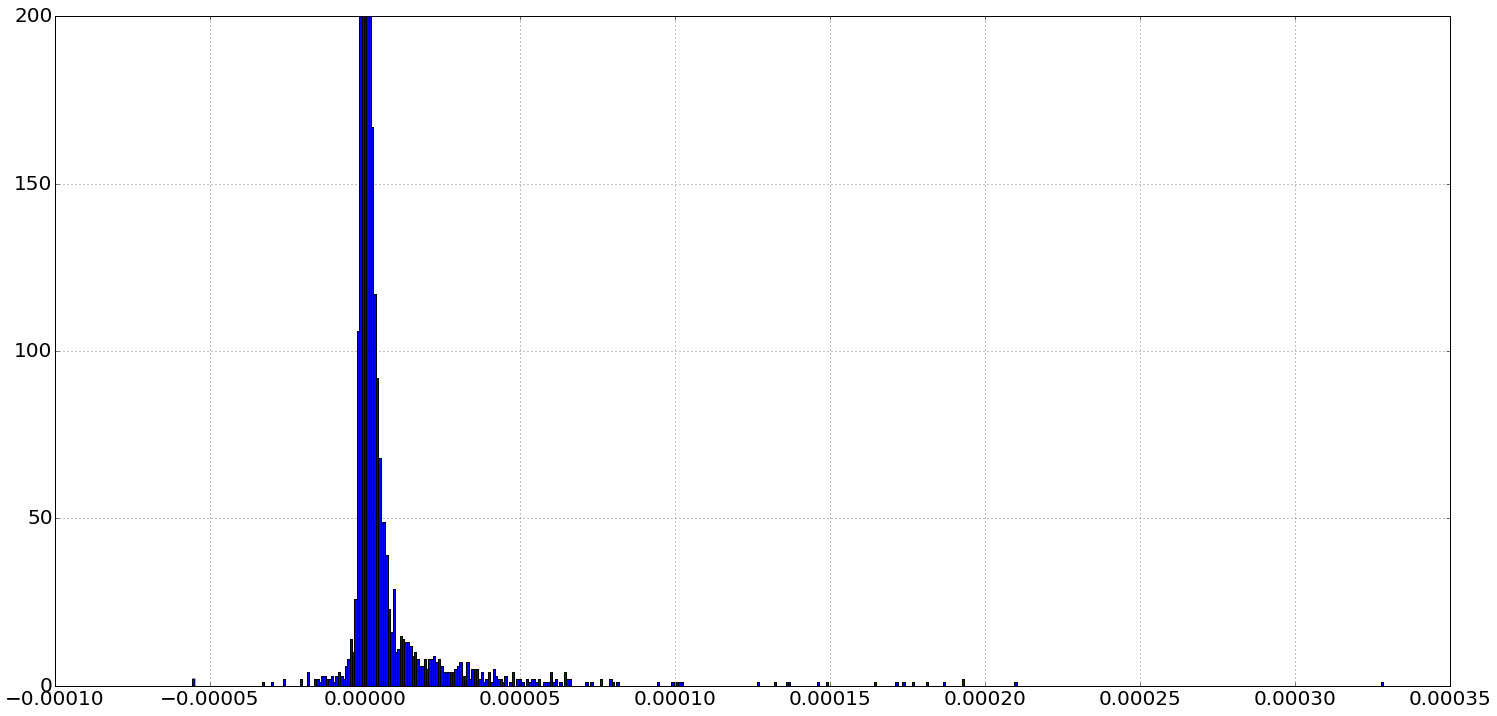

In [167]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [168]:
((u_ir_m - u_ir_a)<-0.0000001).value_counts()

False    39782
True      2927
dtype: int64

(0, 200)

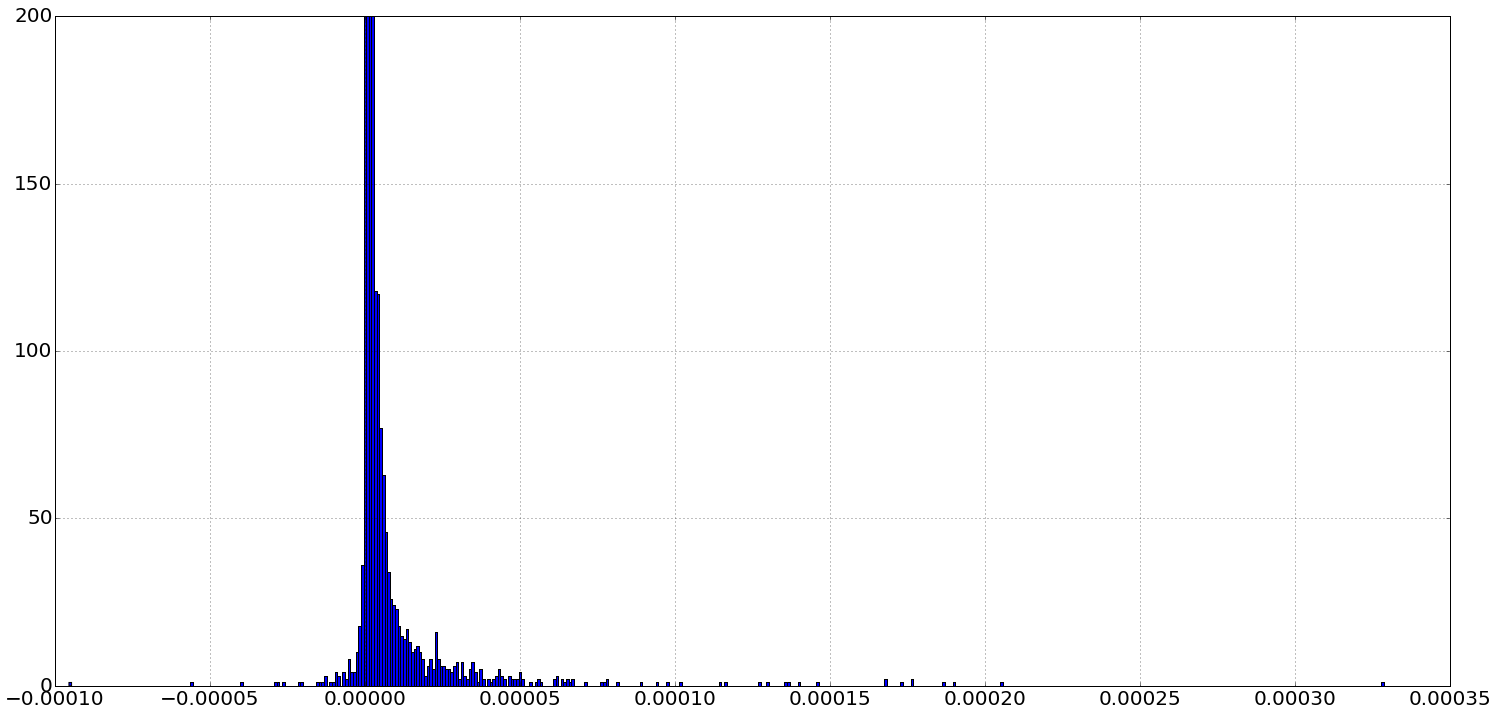

In [169]:
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [170]:
((u_c_ir - u_ir_a)<-0.0000001).value_counts()

False    42460
True       249
dtype: int64

##### Graphs with weights

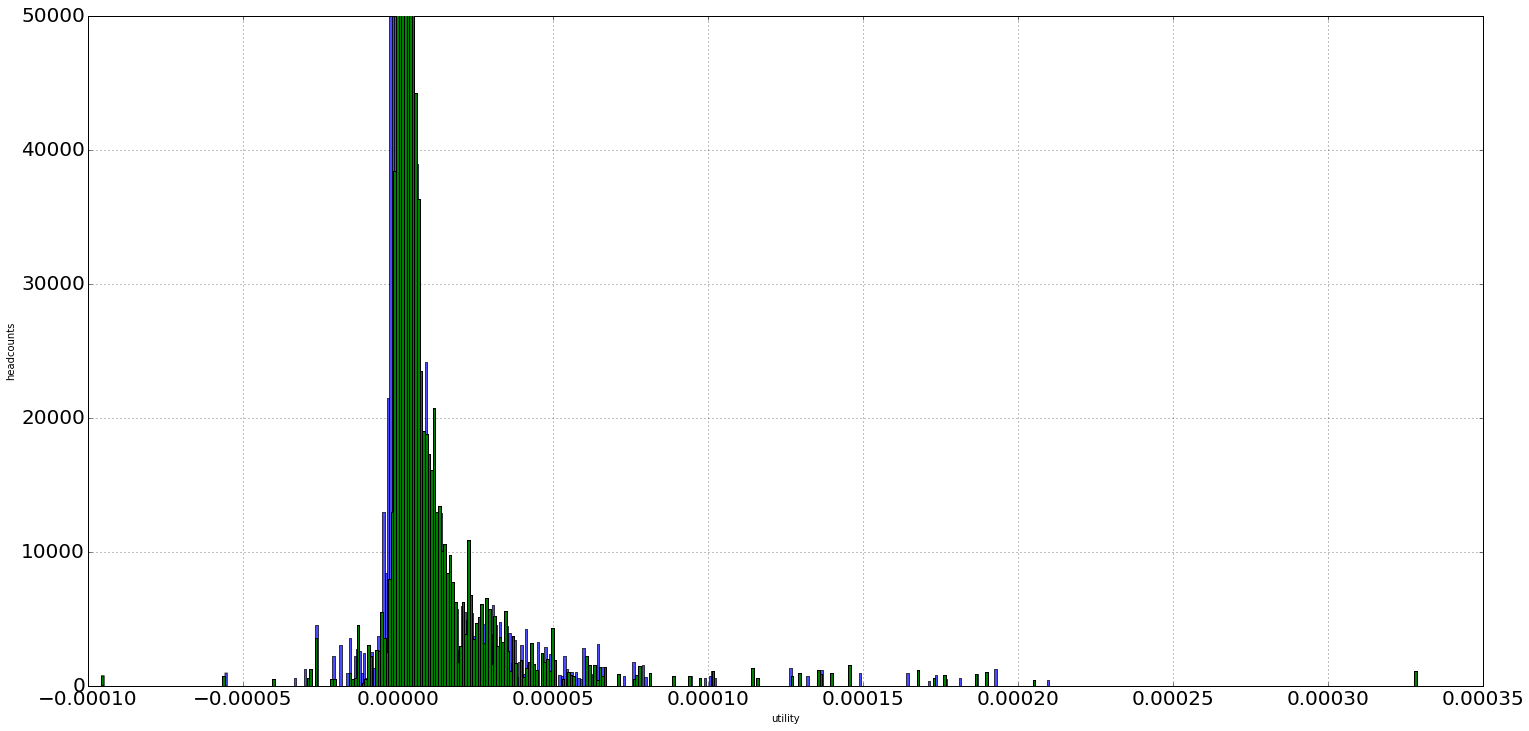

In [171]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12), zorder=1, alpha = 0.7, weights = weight_menages,)
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12), weights = weight_menages,zorder=10, alpha = 1)
plt.ylim(0,5*10**4)
plt.xlabel('utility')
plt.ylabel('headcounts')

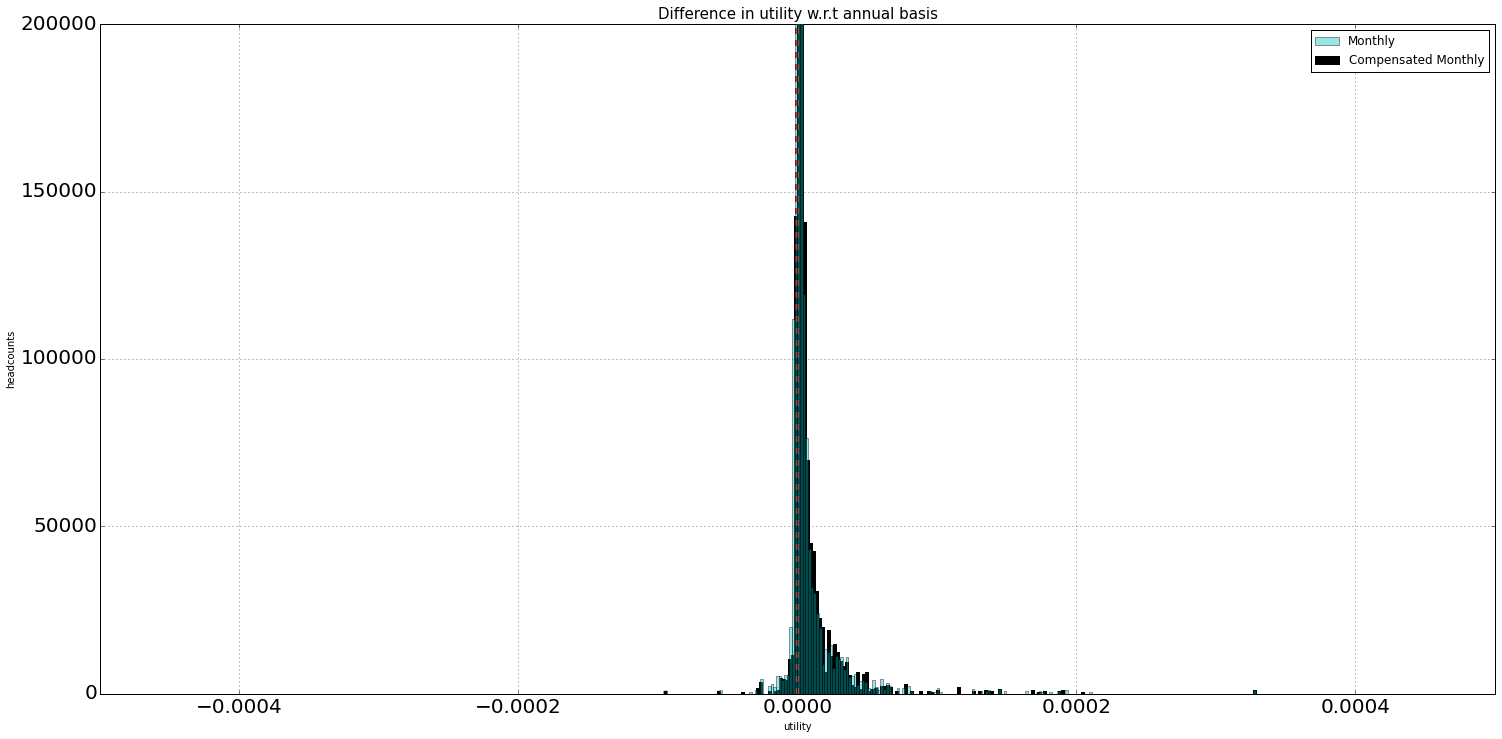

In [172]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

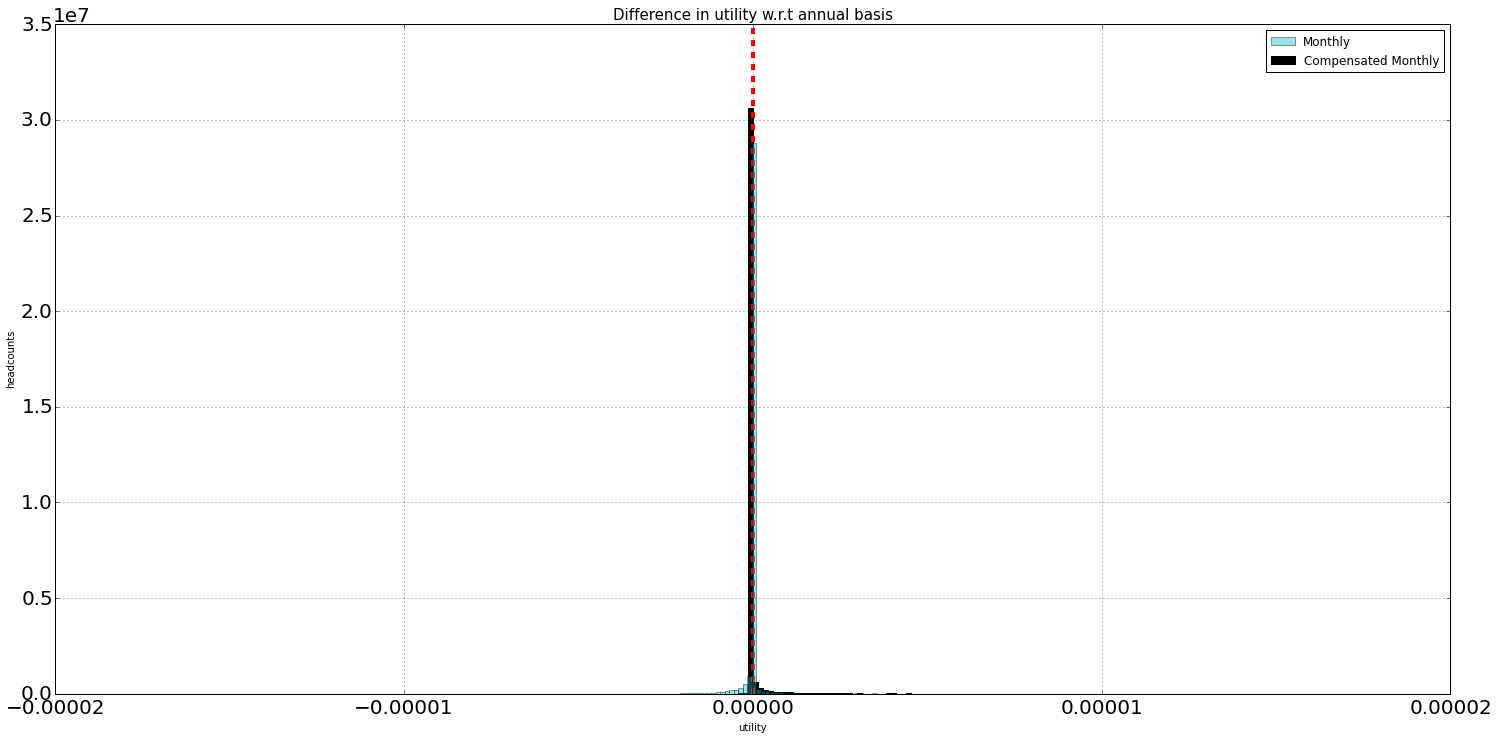

In [173]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,70*10**5)
plt.xlim(-0.00002, 0.00002)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [174]:
weight_menages = pd.Series(weight_menages)

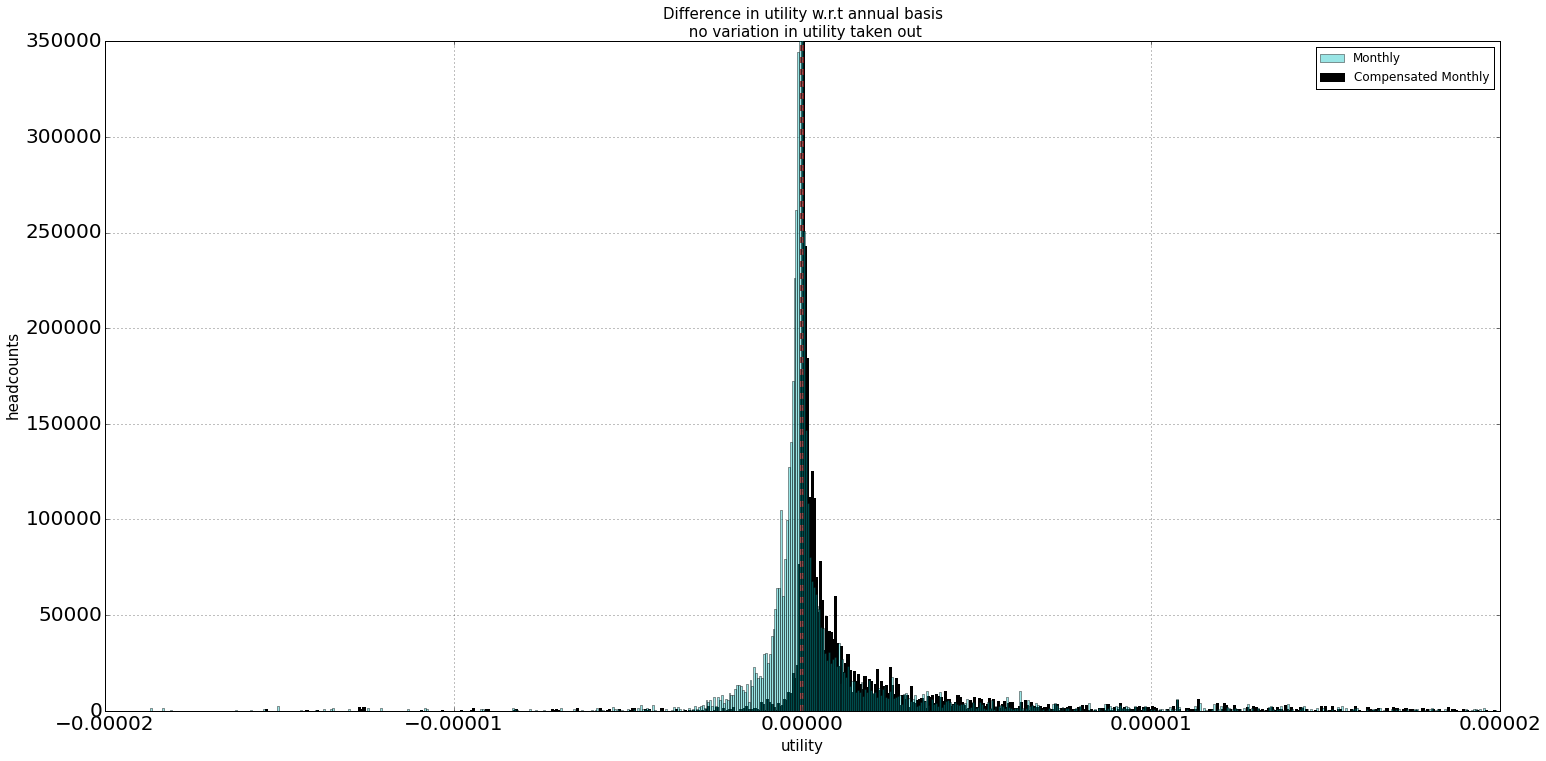

In [175]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [176]:
outliers = pd.Series(np.abs(((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0])>0.00002).value_counts(normalize = True); outliers

False    0.969933
True     0.030067
dtype: float64

In [177]:
"This graph represent {}% of the tax-unit with varying utility, {}% of that sample are over 0.0002 utility points variation".format(outliers[0], outliers[1])

'This graph represent 0.969932885906% of the tax-unit with varying utility, 0.030067114094% of that sample are over 0.0002 utility points variation'

In [178]:
pd.Series(weight_menages).shape

(42709,)

In [179]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

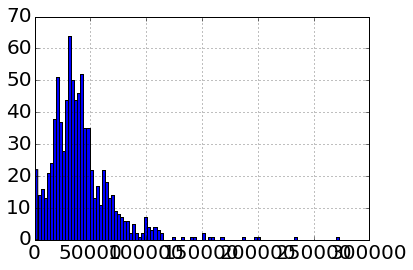

In [180]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel'))[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [181]:
pay_irpp = (simulation.calculate('irpp') > 0)
print pay_irpp.shape
pd.value_counts(cast_array_from_entity_to_role(pay_irpp, 'foyer_fiscal', roles = [0]))

(52189,)


0    78972
1     1459
dtype: int64

In [182]:
decote_mensuel = simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12
decote = simulation.calculate_add("decote_gain_fiscal")


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(int)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

nb_decote_diff_menage = sum_array_by_entity(has_decote_difference, 'menage')

print pd.value_counts(nb_decote_diff_menage)


utility_loss = (u_c_ir - u_ir_a)<-0.00000001
pd.value_counts(nb_decote_diff_menage[utility_loss])

#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    37572
1     4872
2      257
3        8
dtype: int64


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


2    42216
0      493
dtype: int64

In [183]:
revdisp_loss = (simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel')) < -1
#no_decote_or_payment_threshold_concern =  
good_rev_trav = switch_entity('rfr', 'menage')/switch_entity('nbptr', 'menage') > 20000
pd.value_counts(pd.Series(revdisp_loss)[good_rev_trav])

False    9906
True      180
dtype: int64

In [184]:
dico = {} #bizare, qu'est-ce qu'il se passe exactement ?
a = 7
for month in range(1,13):
    dico[month] = zip(pd.Series(simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", period = "2009-{}".format(month)))[good_rev_trav&revdisp_loss][a:a+1], 
                      pd.Series(simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel'))[good_rev_trav&revdisp_loss][a:a+1],
                      pd.Series(switch_entity('irpp', 'famille'))[good_rev_trav&revdisp_loss][a:a+1],
                      
                     
                     )

/usr/local/lib/python2.7/site-packages/pandas/core/internals.py:179: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 48195 but corresponding boolean dimension is 42709
  return self.values[slicer]
/usr/local/lib/python2.7/site-packages/pandas/core/index.py:1087: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 48195 but corresponding boolean dimension is 42709
  result = getitem(key)


In [185]:
dico

{1: [(33936.684, -10428.211, -2574.284912109375)],
 2: [(33936.684, -10428.211, -2574.284912109375)],
 3: [(33936.684, -10428.211, -2574.284912109375)],
 4: [(1076.0078, -10428.211, -2574.284912109375)],
 5: [(303.17395, -10428.211, -2574.284912109375)],
 6: [(303.17395, -10428.211, -2574.284912109375)],
 7: [(876.00781, -10428.211, -2574.284912109375)],
 8: [(876.00781, -10428.211, -2574.284912109375)],
 9: [(876.00781, -10428.211, -2574.284912109375)],
 10: [(876.00781, -10428.211, -2574.284912109375)],
 11: [(876.00781, -10428.211, -2574.284912109375)],
 12: [(876.00781, -10428.211, -2574.284912109375)]}

In [186]:
good_rev_trav.shape

(42709,)

In [187]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

True     0.535497
False    0.464503
dtype: float64

In [188]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

True     0.535497
False    0.464503
dtype: float64

In [189]:
(nb_decote_diff_menage.astype('bool')*weight_menages.values).sum()/weight_menages.sum()

0.12030640518169905

In [190]:
nb_decote_diff_menage

array([ 2.,  0.,  0., ...,  0.,  0.,  0.])

In [191]:
pd.Series(utility_loss)[nb_decote_diff_menage.astype('bool')].value_counts(normalize = True) #Parmis les ménages ayant eu une différence de décote 5% ont eu une perte d'utilité

False    0.948608
True     0.051392
dtype: float64

In [192]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts()

True     264
False    229
dtype: int64

In [193]:
u_c_ir.shape

(42709,)

In [194]:
pd.value_counts(sum_array_by_entity(has_decote_difference, 'menage'))

0    37572
1     4872
2      257
3        8
dtype: int64

In [195]:
ax = ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]).value_counts( normalize = True)*100).plot(kind = "bar",)
plt.ylim((0,100))

labels = ["{}%".format(np.round(i,2)) for i in ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.0000001)]).value_counts( normalize = True)*100) ] #0.000001 pour éviter les erreurs d'arrondis.
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

IndexingError: Unalignable boolean Series key provided

In [ ]:
survey_scenario.simulation.persons.count

In [ ]:
is_decote_different = pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]

In [ ]:
#TODO for famille and check if it coorrespond to the 46.43%
below_collection_thrshld = np.zeros(weight_foyers.shape[0], dtype=bool)
for month in range(1,13):
    irpp_mensuel = pd.Series(survey_scenario.simulation.calculate("irpp_mensuel", '2009-{}'.format(month)))
    below_collection_thrshld += (irpp_mensuel>1) & (irpp_mensuel<5.16)
    

In [ ]:
pd.Series(below_collection_thrshld).value_counts()

In [ ]:
np.array([True, False])+np.array([True, True])

In [ ]:
#Qui sont les gagnants ? :


In [ ]:
is_decote_different[is_decote_different==False]

In [ ]:
pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<0.000001)].value_counts(normalize = True)

In [ ]:
(pd.Series(decote!= decote_mensuel)[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
revdisp[(u_c_ir>=u_ir_a)]

In [ ]:
print u_c_ir[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_m[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_a[(decote_annual==0) & (decote_monthly==0)].mean()

## Qui sont les gagnants ?

In [ ]:
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)

In [ ]:
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
                     *weight_menages).sum()
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)
                      *weight_menages).sum()

In [ ]:
np.mean(
    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
    )

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1], bins = 200, label = "Paying less on monthly basis")
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1], bins = 65, color= 'r', label = "Paying more on monthly basis")
plt.xlim(0,50000)
plt.title("paying more or less")

###### Weighted

In [ ]:
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = simulation.calculate('rbg')
irpp_test_case = simulation.calculate('irpp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]
plt.plot(marginal_rate)

In [ ]:
to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index


In [ ]:
pd.Series(marginal_rate)[marginal_rate>1]

In [ ]:
np.mean(survey_scenario.simulation.calculate("rbg"))

In [ ]:
np.array([True,True,False]) *np.array([2,3,4])

In [ ]:
pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel") - survey_scenario.simulation.calculate_add("revdisp_mensuel_compensated_ir_mensuel")>1))

In [ ]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
#plt.title("")


In [ ]:
-(100 -  110)

In [ ]:
survey_scenario.simulation.calculate_add("irpp_mensuel").mean()

### Gains monetaires

#### Same annalysis with benefits

In [ ]:
survey_scenario.compute_aggregate("rsa_socle_majore_mensualise")

In [ ]:
survey_scenario.compute_aggregate("rsa_non_majore")

In [ ]:
pd.Series(survey_scenario.simulation.calculate("rsa_eligibilite_tns", "2009-01")).value_counts()

# Utilitarian monetary gains

In [ ]:
#monetary_gain_ir = np.zeros(weight_menages.shape[0])
#for month in range(1,10):
#    monetary_gain_ir += (
#    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
#    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
#    )*weight_menages

In [ ]:
#((monetary_gain_ir.sum(0)/10)*12)/10**9

Gains moyens par ménages.

In [ ]:
monetary_gain_ir  = (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009".format(month))
)#*weight_menages

In [ ]:
monetary_gain_ir = pd.Series(monetary_gain_ir)
monetary_gains_ir_0 = monetary_gain_ir[monetary_gain_ir != 0]
monetary_gains_ir_0.hist(bins = 800, weights = (pd.Series(weight_menages)[monetary_gain_ir != 0]).values)
plt.xlim(-1000,5000)

In [ ]:
print pd.Series(monetary_gain_ir<-10).value_counts()
print pd.Series(monetary_gain_ir>10).value_counts()
pd.Series(monetary_gain_ir)[monetary_gain_ir>10].shape

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009".format(month))
    )
gain[np.abs(gain)>1].mean()


In [ ]:
 diff_in_income = pd.Series(
    np.abs(survey_scenario.simulation.calculate("revdisp_mensuel_annuel", "2009".format(month))
          - survey_scenario.simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", "2009".format(month)))>1
    )

In [ ]:
weight_menages.sum(0)

In [ ]:
#monetary_gain.sum(0)/10**9

#### Non compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,12):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
(u_monetary_gain_ir.sum(0))/10**9

In [ ]:
month = 6
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain for each month

In [ ]:
u_money_gain = np.zeros(weight_menages.shape[0])
mean_gain = np.zeros(1)
for month in range(1,13):
    u_money_gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
        )
    mean_gain += (u_money_gain[np.abs(u_money_gain)>1]).mean()
print('{} gain on average'.format(mean_gain[0]))

In [ ]:
#mean_gain = (u_gain[np.abs(u_gain)>1]).mean()

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))

#### Compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


### RSA+IR

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
temp = pd.Series(gain_m)

In [ ]:
pd.Series(survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
monetary_gain_ir_rsa = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir_rsa += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir_rsa.sum(0)/10)*12)/10**9

## Gains et perte passage à la retraite.

In [ ]:
print survey_scenario.simulation.persons.simulation.entity_by_key_plural

In [ ]:
coucou.entity.simulation

In [ ]:
c = np.zeros(1)
a = np.array([1,2,3])
b = np.array([True,True,False])
c += a[b]; c

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
for month in range(1,13):
    is_retired += survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))>0
    is_active += survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month))>0
    is_inactive += (survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)) + survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))) == 0

In [ ]:
(pd.Series(is_retired + is_active + is_inactive).hist(bins= 12))

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
is_retire_active = np.zeros(weight_individus.shape[0])

for month in range(1,13):
    retraite_imposable = survey_scenario.simulation.compute("retraite_imposable", "2009-{}".format(month))
    salaire_imposable = survey_scenario.simulation.compute("salaire_imposable", "2009-{}".format(month))
    is_retired += retraite_imposable.array >0
    is_active += salaire_imposable.array > 0 
    is_retire_active += (retraite_imposable.array >0) & (salaire_imposable.array > 0 )
    is_inactive += (retraite_imposable.array == 0) & (salaire_imposable.array == 0 )
    

In [ ]:
is_retire_is_active_not_retire_active = ((is_retire_active == 0)
                                         & (is_active>0)
                                         & (is_inactive >0)
                                         )

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity(retraite_imposable)

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity('h')

In [ ]:
 type(class_name.encode('utf-8'), (Reform.DatedVariable,), definitions_by_name)

In [ ]:
pd.Series(is_retire_is_active_not_retire_active).value_counts()

In [ ]:
(pd.Series(is_retired + is_active + is_inactive)).value_counts()

In [ ]:
passage_a_la_retraite = pd.Series(is_retired) & pd.Series(is_not_retired)

## Revdisp over the year

## Annual IR Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel',]:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
    

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_annual.png")

## Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Rsa monthly

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel_rsa_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel_rsa_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_rsa_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['rev_trav_mensuel', 'pen_mensuel', 'chomage_imposable', 'pen_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

In [ ]:

undecompsed_revdisp = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    temp['revdisp_mensuel_annuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('revdisp_mensuel_annuel', "2009-{}".format(month))))
    undecompsed_revdisp = undecompsed_revdisp.append(temp, ignore_index=True)
    

In [ ]:
undecompsed_revdisp.index = range(1,13)

In [ ]:
df1 = pd.DataFrame({'revdisp_mensuel_annuel':revdisp_oy.sum(1).values}) 
df1.index = range(1,13)
(df1 - undecompsed_revdisp)/10**9

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5,1)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.2, figsize=(15,9) )
#ax = fig.add_subplot(111)
plt.bar(undecompsed_revdisp.index, undecompsed_revdisp.values, color = 'k', alpha = 0.4)
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp


## Monthly IR basis 

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
        temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
plt.close()
plt.figure()

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

## Monthly IR compensated

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'compensated_impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("rev_trav_mensuel", "2009-{}".format(month)))

In [ ]:
'a'

In [ ]:
revdisp_oy.sum(0).plot(kind = 'bar', color = 'b')

#### By income type

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')
plt.ylim(8*10**7)


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("pen_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("psoc_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("ppe", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("impo_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))

# END

### Taux d'intérêt

In [ ]:
def revdisp_tx(var = None, taux = None):
    revdisp_i = 0
    for month in range(0,12):
        monthly_taux = ((1+taux)**(1/12)) 
        revdisp_i += (
            survey_scenario.simulation.calculate(var, survey_scenario.simulation.period.offset(month, 'month').this_month) 
            / (monthly_taux)**month 
                      )
    return revdisp_i


In [ ]:
revdisp_tx('revdisp_mensuel_ir_mensuel', 1.6)

In [ ]:
survey_scenario.simulation.period.offset(2, 'month').this_month